##  Results of MoBYGRN

STRING:
    hESC500:     0.8777987718129536   0.4044246706213809;
    hESC1000:    0.8814913750747931   0.34936482661728646

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.distributed as dist 
from torchvision.transforms.functional import to_pil_image 
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts 
import torch.cuda.amp as amp 
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.ops import * 
from torchvision.models import *
from torchsummary import summary
from matplotlib import pyplot as plt
import bitsandbytes as bnb
import numpy as np
import pandas as pd
import scipy.stats
import os
import time
import copy
import random
from tqdm import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

!nvidia-smi
!fuser -v /dev/nvidia* 

# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device('cuda:1')
device1 = torch.device('cuda:1')
print(torch.cuda.is_available())


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/bucea-03/.local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda112.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda-11.2/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 112
CUDA SETUP: Loading binary /home/bucea-03/.local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda112.so...


/home/bucea-03/.local/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /home/bucea-03/.conda/envs/cal did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


Wed Oct 18 08:22:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 30%   19C    P8    20W / 220W |      8MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:D9:00.0 Off |                  N/A |
| 30%   

In [2]:
# GENIE3 in hESC 500
import math
import csv
import pandas as pd
import numpy as np
import time
import random
from multiprocessing import cpu_count  
from concurrent.futures import ProcessPoolExecutor  
from tqdm import * 

def split(X):   
    cores = cpu_count()
    part = len(X)//cores
    
    parts = []
    for i in range(cores-1):
        temp = X[i*part: (i+1)*part]
        parts.append(temp)
    parts.append(X[(i+1)*part:])
    return parts, cores

def RegMap_Preprocess(data, start_end):
    print('STRING dataset preprocessing...')
    start = time.time()
    if __name__ == '__main__':
        data_part, cores = split(data)
        network = []
        p = ProcessPoolExecutor(max_workers=cores)
        process = [p.submit(regmap, (data_part[i], start_end, i)) for i in range(cores)]
        p.shutdown()
        for j in range(cores):
            results = process[j].result()
            network.extend(results[0])
    RuningTime = time.time() - start
    print('Runing Time:', round(RuningTime / 60, 2), 'min')
    return np.array(network)

def regmap(params):
    # data: List(network)    start: str
    data, start_end, core = params
    network_ = []
    if core == 1:
        for edge in tqdm(data):
            tf_end, target_end = edge[0].find(start_end[1]), edge[2].find(start_end[1])
            tf, target = edge[0][: tf_end], edge[2][: target_end]
            network_.append([tf.upper(), target.upper()])
    else:
        for edge in data:
            tf_end, target_end = edge[0].find(start_end[1]), edge[2].find(start_end[1])
            tf, target = edge[0][: tf_end], edge[2][: target_end]
            network_.append([tf.upper(), target.upper()])
            
    return network_, core

def STRING_Preprocess(data, start_end):
    print('STRING dataset preprocessing...')
    start = time.time()
    if __name__ == '__main__':
        data_part, cores = split(data) 
        network = []
        p = ProcessPoolExecutor(max_workers=cores)
        process = [p.submit(string, (data_part[i], start_end, i)) for i in range(cores)]
        p.shutdown()
        for j in range(cores):
            results = process[j].result()
            network.extend(results[0])
    RuningTime = time.time() - start
    print('Runing Time:', round(RuningTime / 60, 2), 'min')
    return np.array(network)

def string(params):
    # data: List(network)    start: str
    data, start_end, core = params
    network_ = []
    if core == 1:
        for edge in tqdm(data):
            tf_start, target_start = edge.find(start_end[0])+len(start_end[0]), edge.rfind(start_end[0])+len(start_end[0])
            tf_end, target_end = edge.find(start_end[1]), edge.rfind(start_end[1])
            tf, target = edge[tf_start: tf_end], edge[target_start: target_end]
            network_.append([tf.upper(), target.upper()])
    else:
        for edge in data:
            tf_start, target_start = edge.find(start_end[0])+len(start_end[0]), edge.rfind(start_end[0])+len(start_end[0])
            tf_end, target_end = edge.find(start_end[1]), edge.rfind(start_end[1])
            tf, target = edge[tf_start: tf_end], edge[target_start: target_end]
            network_.append([tf.upper(), target.upper()])
            
    return network_, core

def Intersect(exp, net): 
    if __name__ == '__main__':
        print('Intersect searching...')
        exp_genes = exp[:, 0].tolist()
        for i in range(len(exp_genes)):
            gene = exp_genes[i]
            if type(gene) == str and gene.find('_') != -1:
                exp_genes[i] = gene[:gene.find('_')]
        exp = exp[:, 1:]
        net_genes = net[:, :2].reshape(-1,)
        genes_intersect = np.intersect1d(net_genes, exp_genes)
        genes_part, cores = split(genes_intersect)
        all_genes, exp_intersect = [], []
        p = ProcessPoolExecutor(max_workers=cores)
        process = [p.submit(intersect, (genes_part[i], exp_genes, exp, i)) for i in range(cores)]
        p.shutdown()
        for j in range(cores):
            results = process[j].result()
            all_genes.extend(results[0])
            exp_intersect.extend(results[1])
    return np.array(all_genes), np.array(exp_intersect)

def intersect(params):
    # data: List(network)    start: str
    genes, exp_genes, exp, core = params
    all_genes, network_ = [], []
    exp_intersect = np.empty((1, exp.shape[1]))
    
    if core == 1:
        for gene in tqdm(genes):
            # gene_exp = exp[exp_genes.index(gene), :]
            gene_exp = exp[exp_genes.index(gene)]
            if np.mean(gene_exp) >= 1:
                
                # log transformation
                # gene_exp = np.log10(gene_exp+10**-2)
                # Normalize
                gene_exp = (gene_exp - np.mean(gene_exp)) / np.std(gene_exp)
                
                all_genes.append(gene)
                exp_intersect = np.vstack((exp_intersect, gene_exp))
    else:
        for gene in genes:
            # gene_exp = exp[exp_genes.index(gene), :]
            gene_exp = exp[exp_genes.index(gene)]
            if np.mean(gene_exp) >= 1:
                
                # log transformation
                # gene_exp = np.log10(gene_exp+10**-2)
                # Normalize
                gene_exp = (gene_exp - np.mean(gene_exp)) / np.std(gene_exp)
                
                all_genes.append(gene)
                exp_intersect = np.vstack((exp_intersect, gene_exp))
    
    return all_genes, exp_intersect[1:]

def BuildDatasets(net, tfs, genes):
    if __name__ == '__main__':
        for i in range(len(tfs)):
            tf = tfs[i]
            if type(tf) == str and tf.find('_') != -1:
                tfs[i] = tf[:tf.find('_')]
        print('Network Searching...')
        net_part, cores = split(net)
        all_tfs, targets, networks = [], [], []
        p = ProcessPoolExecutor(max_workers=cores)
        process = [p.submit(buildnet, (net_part[i], tfs, genes, i)) for i in range(cores)]
        p.shutdown()
        for j in range(cores):
            results = process[j].result()
            all_tfs.extend(results[0])
            targets.extend(results[1])
            networks.extend(results[2])
    return np.unique(all_tfs), np.unique(targets), np.array(networks)

def buildnet(params):
    # data: List(network)    start: str
    net, tfs, genes, core = params
    tf_gene = np.intersect1d(tfs, genes)
    all_tfs, all_targets, all_reg = [], [], []
    if core == 1:
        for regulation in tqdm(net):
            tf, target = regulation[0], regulation[1]
            if tf in tf_gene and target in genes:
                all_tfs.append(tf)
                all_targets.append(target)
                all_reg.append(regulation)
    else:
        for regulation in net:
            tf, target = regulation[0], regulation[1]
            if tf in tf_gene and target in genes:
                all_tfs.append(tf)
                all_targets.append(target)
                all_reg.append(regulation)
    return all_tfs, all_targets, all_reg

def processing(tfs, targets, genes, exp, gold):
    print('Multi-core processing...')
    start = time.time()
    if __name__ == '__main__':
        targets_part, cores = split(targets) 
        gene_pair, expression, all_labels = [], [], []
        p = ProcessPoolExecutor(max_workers=cores)
        process = [p.submit(GenData, (tfs, targets_part[i], genes.tolist(), exp, gold.tolist(), i)) for i in range(cores)]
        p.shutdown()
        for j in range(cores):
            results = process[j].result()
            gene_pair.extend(results[0])
            expression.extend(results[1])
            all_labels.extend(results[2])
            print(len(results[1]))

        end = time.time()
        RuningTime = end - start
        print('multiprocessing Done! Runing Time:', round(RuningTime / 60, 2), 'min')

    return np.array(gene_pair), np.array(expression), np.array(all_labels)

# Gather Expression dataset
def GenData(paras):  # (gene_part, sub_tf, sub_tf_exp, genesexp_part, sub_gold, time_lag)
    error = 0
    gene_pair, expression, labels = [], [], []
    tfs, targets, genes, exp, gold, core = paras
    if core == 1:
        for tf in tqdm(tfs):
            tf_exp = exp[genes.index(tf)]
            for target in targets:
                target_exp = exp[genes.index(target)]
                relation = [tf, target]
                if relation in gold:
                    labels.append(1)
                else:
                    labels.append(0)
                gene_pair.append([tf, target])
                expression.append(np.vstack((tf_exp, target_exp)))
    else:
        for tf in tfs:
            tf_exp = exp[genes.index(tf)]
            for target in targets:
                target_exp = exp[genes.index(target)]
                relation = [tf, target]
                if relation in gold:
                    labels.append(1)
                else:
                    labels.append(0)
                gene_pair.append([tf, target])
                expression.append(np.vstack((tf_exp, target_exp)))
    return (gene_pair, expression, labels)

def split_datasets(labels):
    print('labels', np.sum(labels))
    pos_index, neg_index = [], []
    pos_index = [index for index, value in enumerate(labels) if value == 1]
    neg_index = [index for index, value in enumerate(labels) if value == 0]
    pos_shuffle, neg_shuffle = random.sample(pos_index, len(pos_index)), random.sample(neg_index, len(neg_index))
    pos_part, neg_part = len(pos_shuffle) // 5, len(neg_shuffle) // 5
    pos_train, neg_train = pos_shuffle[ :3*pos_part], neg_shuffle[ :3*neg_part]
    pos_val, neg_val = pos_shuffle[3*pos_part : 4*pos_part], neg_shuffle[3*neg_part : 4*neg_part]
    pos_test, neg_test = pos_shuffle[4*pos_part: ], neg_shuffle[4*neg_part: ]
    train_index = pos_train + neg_train
    val_index = pos_val + neg_val
    test_index = pos_test + neg_test

    return train_index, val_index, test_index

# Gather Expression dataset
class PretrainFeeder(Dataset):
    def __init__(self, exp_data, label, patch_size, base=256):
        self.exp_data = exp_data
        self.label = label
        self.arange = np.arange(exp_data.shape[-1])
        if exp_data.shape[-1] < base:
            self.index = 'fill'
            self.fill = base - exp_data.shape[-1]
        elif exp_data.shape[-1] % base in [i for i in range(0, base, patch_size)]:
            self.index = 'just right'
        else:
            self.index = 'fill'
            self.fill = patch_size - (exp_data.shape[-1] % patch_size)
            
    def __len__(self):
        return len(self.label)
    
    # Data Augmentation
    def DA_Adapt(self, X):
        if self.index == 'fill':
            index = np.random.choice(self.arange, self.fill)
            return np.insert(X, index, X[index]) 
        elif self.index == 'just right':
            return X
        else:
            print(' Adapt ERROR!!')
    
    def DA_Jitter(self, X, sigma=0.2):  
        if random.randint(0,10) >= 8: # 80% probability
            nums = np.ones_like(X, dtype=np.int64)
            nums[:int(0.8*len(nums))] = 0
            np.random.shuffle(nums)
            X +=  nums*np.random.normal(loc=0, scale=sigma, size=X.shape)   
        return X
    
    def DA_Scaling(self, X, sigma=1.1):
        if random.randint(0,10) >= 8: # 80% probability
            scale = np.random.normal(loc=2.0, scale=sigma)  
            X *= scale
        return X
    
    def DA_Contrast(self, X, s=0.8):
        if random.randint(0,10) >= 8: # 80% probability
            highlight = X * np.random.uniform(1-0.5*s, 1+0.5*s)
            shadow = X * np.random.uniform(1-0.5*s, 1+0.5*s)  
            X = np.where(X >= np.mean(X), highlight, shadow)
        return X
    
    def DA_Drouput(self, X):
        if random.randint(0,10) >= 8: # 80% probability
            nums = np.ones_like(X, dtype=np.int64)
            drouput = np.random.uniform(.2, 1.)
            nums[:int(drouput*len(nums))] = 0
            np.random.shuffle(nums)   
            X *= nums
        return X
    
    def DA_RandomFlip(self, X, s=0.5):
        if np.random.uniform(0, 1) >= s:
            return X[::-1]
        else:
            return X
    
    def Augment(self, X):
        X = self.DA_Adapt(X)
        X = self.DA_Jitter(X)
        X = self.DA_Scaling(X)
        X = self.DA_Contrast(X)
        X = self.DA_Drouput(X)
        # X = self.DA_RandomFlip(X)
        return X
    
    def __getitem__(self, index):
        
        tf, target = copy.deepcopy(self.exp_data[index][0]), copy.deepcopy(self.exp_data[index][1])
        label = self.label[index]
        
        tf0, target0 = self.Augment(tf), self.Augment(target)
        tf1, target1 = self.Augment(tf), self.Augment(target)
        
        X0 = np.concatenate([tf0.reshape(1,-1), target0.reshape(1,-1)], axis=0).astype(np.float16)
        X1 = np.concatenate([tf1.reshape(1,-1), target1.reshape(1,-1)], axis=0).astype(np.float16)
        
        return X0, X1, label
        
class Feeder(Dataset):
    def __init__(self, exp_data, label, patch_size, base=256):
        
        self.exp_data = exp_data
        self.label = label
        self.arange = np.arange(exp_data.shape[-1])
        
        if exp_data.shape[-1] < base:
            self.index = 'fill'
            self.fill = base - exp_data.shape[-1]
        elif exp_data.shape[-1] % base in [i for i in range(0, base, patch_size)]:
            self.index = 'just right'
        else:
            self.index = 'fill'
            self.fill = patch_size - (exp_data.shape[-1] % patch_size)
            
    def __len__(self):
        return len(self.label)
    
    # Data Augmentation
    def DA_Adapt(self, X):
        if self.index == 'fill':
            index = np.random.choice(self.arange, self.fill)
            return np.insert(X, index, X[index])
        elif self.index == 'just right':
            return X
        else:
            print(' Adapt ERROR!!')
        
    def __getitem__(self, index):
        
        tf, target = copy.deepcopy(self.exp_data[index][0]), copy.deepcopy(self.exp_data[index][1])
        label = self.label[index]
        
        tf, target = self.DA_Adapt(tf), self.DA_Adapt(target)
        X = np.concatenate([tf.reshape(1,-1), target.reshape(1,-1)], axis=0).astype(np.float16)
        return X, label

In [3]:
top =  2000
patch_size = 8
batch_size = 256
queue_length = 8192

# TF_ID->             Gene_ID->      Family:
#GRMZM2G163813_P03 -> GRMZM2G163813 -> SBP     
tfs = pd.read_csv('data/Zma_TF_list.txt', sep='\t', engine='c').values[:, 1]  

#基因表达量数据
ExpressionData = pd.read_csv('data/Maize_Seed.csv', engine='c').values
#ExpressionData = pd.read_csv('data/maize_SacOvule.csv', engine='c').values
#ExpressionData = pd.read_csv('data/Maize_Nucellus.csv', engine='c').values


network = pd.read_csv('data/4577.protein.links.v11.5.txt', engine='c').values.reshape(-1,)


#network = pd.read_csv('data/regulation_from_FunTFBS_Zma.txt', sep='\t', header=None, engine='c').values

#network = pd.read_csv('data/regulation_from_motif_CE_Zma.txt', sep='\t', header=None, engine='c').values
#network = pd.read_csv('data/regulation_from_motif_Zma.txt', sep='\t', header=None, engine='c').values
#network = pd.read_csv('data/regulation_merged_Zma.txt', sep='\t', header=None, engine='c').values

start_end = ('4577.', '_')

net = STRING_Preprocess(network, start_end)
#net = np.hstack((network[:,0].reshape(-1,1), network[:,2].reshape(-1,1)))
genes, expression = Intersect(ExpressionData, net) 

var = np.var(expression, axis=1)

# range by Varience
arange = np.var(expression, axis=1).argsort()[::-1]
genes_pretrain, exp_pretrain = genes[arange[:2000]], expression[arange[:2000]]
genes1000, exp1000 = genes[arange[:1000]], expression[arange[:1000]]
genes2000, exp2000 = genes[arange[:2000]], expression[arange[:2000]]
# genes_range, exp_range = genes[arange[:]], expression[arange[:]]

# Search top tfs, targets and net
pretrain_tfs, pretrain_targets, pretrain_networks = BuildDatasets(net, tfs, genes_pretrain)
tfs1000, targets1000, networks1000 = BuildDatasets(net, tfs, genes1000)
tfs2000, targets2000, networks2000 = BuildDatasets(net, tfs, genes2000)


pretrain_pair, pretrain_exp, pretrain_labels = processing(pretrain_tfs, pretrain_targets, genes_pretrain, exp_pretrain, pretrain_networks)



gene_pair, all_exp, labels = processing(tfs1000, targets1000, genes1000, exp1000, networks1000)
labels_unique, counts = np.unique(labels, return_counts=True)
class_weight = [i / sum(counts) for i in counts]
print(1000, 'num of tfs:', len(tfs1000), 'num of targets:', len(targets1000))
train_index, val_index, test_index = split_datasets(labels)
print('negative VS postive:', class_weight, 'Density:', round(class_weight[0]/sum(class_weight), 3))
exp_train1000 = np.array(all_exp)[np.array(train_index)].copy()
y_train1000 = np.array(labels)[np.array(train_index)].copy()
exp_val1000 = np.array(all_exp)[np.array(val_index)].copy()
y_val1000 = np.array(labels)[np.array(val_index)].copy()
exp_test1000 = np.array(all_exp)[np.array(test_index)].copy()
y_test1000 = np.array(labels)[np.array(test_index)].copy()

gene_pair, all_exp, labels = processing(tfs2000, targets2000, genes2000, exp2000, networks2000)
labels_unique, counts = np.unique(labels, return_counts=True)
class_weight = [i / sum(counts) for i in counts]
print(2000, 'num of tfs:', len(tfs2000), 'num of targets:', len(targets2000))
train_index, val_index, test_index = split_datasets(labels)
print('negative VS postive:', class_weight, 'Density:', round(class_weight[0]/sum(class_weight), 3))
exp_train2000 = np.array(all_exp)[np.array(train_index)].copy()
y_train2000 = np.array(labels)[np.array(train_index)].copy()
exp_val2000 = np.array(all_exp)[np.array(val_index)].copy()
y_val2000 = np.array(labels)[np.array(val_index)].copy()
exp_test2000 = np.array(all_exp)[np.array(test_index)].copy()
y_test2000 = np.array(labels)[np.array(test_index)].copy()

# DATA INPUT
data = PretrainFeeder(np.array(all_exp), labels, patch_size)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)

train_data1000 = Feeder(np.array(exp_train1000), y_train1000, patch_size)
val_data1000 = Feeder(np.array(exp_val1000), y_val1000, patch_size)
test_data1000 = Feeder(np.array(exp_test1000), y_test1000, patch_size)
train_dl1000 = DataLoader(train_data1000, batch_size=batch_size, shuffle=True)
val_dl1000 = DataLoader(val_data1000, batch_size=batch_size, shuffle=True)
test_dl1000 = DataLoader(test_data1000, batch_size=batch_size, shuffle=True)

train_data2000 = Feeder(np.array(exp_train2000), y_train2000, patch_size)
val_data2000 = Feeder(np.array(exp_val2000), y_val2000, patch_size)
test_data2000 = Feeder(np.array(exp_test2000), y_test2000, patch_size)
train_dl2000 = DataLoader(train_data2000, batch_size=batch_size, shuffle=True)
val_dl2000 = DataLoader(val_data2000, batch_size=batch_size, shuffle=True)
test_dl2000 = DataLoader(test_data2000, batch_size=batch_size, shuffle=True)

STRING dataset preprocessing...


100%|██████████| 353950/353950 [00:01<00:00, 265998.90it/s]


Runing Time: 1.1 min
Intersect searching...


100%|██████████| 274/274 [00:00<00:00, 2170.21it/s]


Network Searching...


100%|██████████| 353950/353950 [00:02<00:00, 120856.05it/s]


Network Searching...


100%|██████████| 353950/353950 [00:02<00:00, 148167.54it/s]


Network Searching...


100%|██████████| 353950/353950 [00:02<00:00, 121278.89it/s]


Multi-core processing...


100%|██████████| 135/135 [00:00<00:00, 258.25it/s]


2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
7695
multiprocessing Done! Runing Time: 0.19 min
Multi-core processing...


100%|██████████| 71/71 [00:00<00:00, 1071.92it/s]


426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
426
4828
multiprocessing Done! Runing Time: 0.16 min
1000 num of tfs: 71 num of targets: 542
labels 1815
negative VS postive: [0.952835091731199, 0.047164908268801] Density: 0.953
Multi-core processing...


100%|██████████| 135/135 [00:00<00:00, 135.27it/s]


2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
2025
7695
multiprocessing Done! Runing Time: 0.21 min
2000 num of tfs: 135 num of targets: 1242
labels 6214
negative VS postive: [0.9629391065783981, 0.03706089342160196] Density: 0.963


In [4]:
print(all_exp)
print("*" * 20)
print(labels)
print("*" * 20)
print(gene_pair)
print("*" * 20)

[[[-0.5128099363525433 -0.2437889361137933 -0.36178060288517483 ...
   -0.6449606031364907 3.8434424008468655 -0.7865506032621487]
  [1.0981842079735484 1.2637609506705914 1.0023239885173658 ...
   -1.5336145443689218 0.28772962529854956 -2.326639996233706]]

 [[-0.5128099363525433 -0.2437889361137933 -0.36178060288517483 ...
   -0.6449606031364907 3.8434424008468655 -0.7865506032621487]
  [-0.5128099363525433 -0.2437889361137933 -0.36178060288517483 ...
   -0.6449606031364907 3.8434424008468655 -0.7865506032621487]]

 [[-0.5128099363525433 -0.2437889361137933 -0.36178060288517483 ...
   -0.6449606031364907 3.8434424008468655 -0.7865506032621487]
  [-0.09231157524722951 1.3199733495589028 2.888229226726378 ...
   -0.6285952607636277 -0.6285952607636277 -0.6285952607636277]]

 ...

 [[1.2363941619996979 0.6075571203156689 0.18053977859799655 ...
   -1.2582393727750616 -0.7042709294656488 -1.2659333789321368]
  [1.2363941619996979 0.6075571203156689 0.18053977859799655 ...
   -1.25823937

In [5]:
# from einops import rearrange
# from einops import rearrange, repeat, pack, unpack
# from einops.layers.torch import Rearrange, Reduce

# class gru(nn.Module):
#     def __init__(self, *, 
#                  seq_len, 
#                  channels,
#                  patch_size, 
#                  dim=512,
#                  num_classes = 1024,
#                  dropout = 0.
#                  ):
        
#         super().__init__()
#         assert (seq_len % patch_size) == 0

#         num_patches = seq_len // patch_size
#         patch_dim = channels * patch_size

#         self.tf_embedding = nn.Sequential(
#                                         Rearrange('b (n p) -> b n p', p = patch_size),
#                                         # nn.LayerNorm(patch_dim),
#                                         nn.Linear(patch_size, dim//2),
#                                         nn.LayerNorm(dim//2),
#                                     )
        
#         self.target_embedding = copy.deepcopy(self.tf_embedding)
        
#         self.encoder = nn.GRU(input_size=dim, hidden_size=dim//2, batch_first=True, bidirectional=True)
#         self.dropout = nn.Dropout(dropout)
        
#         self.pooling = nn.Sequential(nn.LayerNorm(dim),
#                                     Reduce('b n c -> b c', 'mean')
#                                     )
                                     
#         self.fc = nn.Linear(dim, num_classes)

#     def forward(self, series):
#         tf, target = series[:, 0, :], series[:, 1, :]
#         tf, target = self.tf_embedding(tf), self.target_embedding(target)
#         x = torch.cat([tf, target], dim=-1)
        
#         x = self.encoder(x)[0]
#         x = self.dropout(x)
        
#         x = self.pooling(x)
#         return self.fc(x)



# class ResNet50(nn.Module):
#     def __init__(self, *, 
#                  seq_len, 
#                  channels,
#                  patch_size, 
#                  dim=512,
#                  num_classes = 1024,  
#                  hidden=128,
#                  dropout = 0.
#                  ):
        
#         super().__init__()
#         assert (seq_len % patch_size) == 0

#         num_patches = seq_len // patch_size
#         patch_dim = channels * patch_size

#         self.tf_embedding = nn.Sequential(
#                                             Rearrange('b (n p) -> b n p', p = patch_size),
#                                             # nn.LayerNorm(patch_dim),
#                                             nn.Linear(patch_size, dim//2),
#                                             nn.LayerNorm(dim//2),
#                                         )
        
#         self.target_embedding = copy.deepcopy(self.tf_embedding)
        
#         self.encoder = resnet50(weights=None, num_classes=num_classes)
#         self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         prev_dim = self.encoder.fc.weight.shape[1]
#         self.encoder.fc = nn.Linear(prev_dim, dim)
        
#         self.fc = nn.Linear(dim, num_classes)

#     def forward(self, series):
#         tf, target = series[:, 0, :], series[:, 1, :]
#         tf, target = self.tf_embedding(tf), self.target_embedding(target)
#         x = torch.cat([tf, target], dim=-1).unsqueeze(1)
        
#         x = self.encoder(x)
#         return self.fc(x)

In [6]:
# from einops import rearrange
# from einops.layers.torch import Rearrange, Reduce

# # helpers
# def posemb_sincos_1d(patches, temperature = 10000, dtype = torch.float32):
#     _, n, dim, device, dtype = *patches.shape, patches.device, patches.dtype

#     n = torch.arange(n, device = device)
#     assert (dim % 2) == 0, 'feature dimension must be multiple of 2 for sincos emb'
#     omega = torch.arange(dim // 2, device = device) / (dim // 2 - 1)
#     omega = 1. / (temperature ** omega)

#     n = n.flatten()[:, None] * omega[None, :]
#     pe = torch.cat((n.sin(), n.cos()), dim = 1)
#     return pe.type(dtype)

# # classes

# class FeedForward(nn.Module):
#     def __init__(self, dim, hidden_dim):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.LayerNorm(dim),
#             nn.Linear(dim, hidden_dim),
#             nn.GELU(),
#             nn.Linear(hidden_dim, dim),
#         )
#     def forward(self, x):
#         return self.net(x)

# class Attention(nn.Module):
#     def __init__(self, dim, heads = 8, dim_head = 64):
#         super().__init__()
#         inner_dim = dim_head *  heads
#         self.heads = heads
#         self.scale = dim_head ** -0.5
#         self.norm = nn.LayerNorm(dim)

#         self.attend = nn.Softmax(dim = -1)

#         self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
#         self.to_out = nn.Linear(inner_dim, dim, bias = False)

#     def forward(self, x):
#         x = self.norm(x)

#         qkv = self.to_qkv(x).chunk(3, dim = -1)
#         q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

#         dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

#         attn = self.attend(dots)

#         out = torch.matmul(attn, v)
#         out = rearrange(out, 'b h n d -> b n (h d)')
#         return self.to_out(out)

# class Transformer(nn.Module):
#     def __init__(self, dim, depth, heads, dim_head, mlp_dim):
#         super().__init__()
#         self.layers = nn.ModuleList([])
#         for _ in range(depth):
#             self.layers.append(nn.ModuleList([
#                 Attention(dim, heads = heads, dim_head = dim_head),
#                 FeedForward(dim, mlp_dim)
#             ]))
#     def forward(self, x):
#         for attn, ff in self.layers:
#             x = attn(x) + x
#             x = ff(x) + x
#         return x

# class SimpleViT_1d(nn.Module):
#     def __init__(self, *, 
#                  seq_len, 
#                  channels,
#                  patch_size, 
#                  dim = 512, 
#                  depth = 12, 
#                  heads = 8, 
#                  mlp_dim = 2048, 
#                  num_classes = 1024,  
#                  dim_head = 64, 
#                  dropout = .1, 
#                  emb_dropout = .1):
        
#         super().__init__()

#         assert seq_len % patch_size == 0

#         num_patches = seq_len // patch_size
#         patch_dim = channels * patch_size

#         self.tf_embedding = nn.Sequential(
#             Rearrange('b (n p) -> b n p', p = patch_size),
#             # nn.LayerNorm(patch_dim),
#             nn.Linear(patch_size, dim//2),
#             nn.LayerNorm(dim//2),
#         )
        
#         self.target_embedding = copy.deepcopy(self.tf_embedding)

#         self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

#         self.pool = nn.Sequential(
#                                 nn.LayerNorm(dim),
#                                 Reduce('b n c -> b c', 'mean')
#                                 )

#         self.fc = nn.Linear(dim, num_classes)

#     def forward(self, series):
#         *_, n, dtype = *series.shape, series.dtype

#         tf, target = series[:, 0, :], series[:, 1, :]
#         tf, target = self.tf_embedding(tf), self.target_embedding(target)
#         x = torch.cat([tf, target], dim=-1)
        
#         pe = posemb_sincos_1d(x)
#         x = rearrange(x, 'b ... d -> b (...) d') + pe

#         x = self.transformer(x)

#         x = self.pool(x)
#         return self.fc(x)

In [7]:
# classes
from einops import rearrange, repeat, pack, unpack
from einops.layers.torch import Rearrange
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, 
                 seq_len, 
                 channels,
                 patch_size, 
                 dim = 512, 
                 depth = 12, 
                 heads = 8, 
                 mlp_dim = 2048, 
                 num_classes = 1024,  
                 dim_head = 64, 
                 dropout = .1, 
                 emb_dropout = .1):
        
        super().__init__()
        assert (seq_len % patch_size) == 0

        num_patches = seq_len // patch_size
        patch_dim = channels * patch_size

        self.tf_embedding = nn.Sequential(
            Rearrange('b (n p) -> b n p', p = patch_size),
            # nn.LayerNorm(patch_dim),
            nn.Linear(patch_size, dim//2),
            nn.LayerNorm(dim//2),
        )
        
        self.target_embedding = copy.deepcopy(self.tf_embedding)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        # encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dropout=dropout, activation=nn.GELU())
        # self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.pool = nn.LayerNorm(dim)
        
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, series):
        tf, target = series[:, 0, :], series[:, 1, :]
        tf, target = self.tf_embedding(tf), self.target_embedding(target)
        x = torch.cat([tf, target], dim=-1)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, 'd -> b d', b = b)

        x, ps = pack([cls_tokens, x], 'b * d')

        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        cls_tokens, _ = unpack(x, ps, 'b * d')
        cls_tokens = self.pool(cls_tokens)

        return self.fc(cls_tokens)


In [8]:
print(len(loader))
for batch in loader:
    print("*" * 20)
    print(batch[0].shape)
    print(batch[0])
    print("*" * 20)
    print(batch[1].shape)
    print(batch[1])
    print("*" * 20)
    print(batch[2].shape)
    print(batch[2])
    break

655
********************
torch.Size([256, 2, 256])
tensor([[[-0.0000, -1.0830, -0.0000,  ..., -1.6270, -0.9922, -1.6270],
         [-0.6445, -0.0000, -0.6958,  ..., -0.6958, -0.0000, -0.6958]],

        [[ 0.0000,  0.2355,  0.2355,  ..., -0.6260, -0.6260, -0.6260],
         [-0.0000, -0.0000, -0.3000,  ...,  0.0000, -1.3623, -0.0000]],

        [[-0.1309, -0.1309, -0.1309,  ..., -0.0923, -0.0923, -1.1543],
         [ 0.0000,  0.3450,  0.0000,  ..., -0.0000, -0.0000, -0.0000]],

        ...,

        [[ 2.3438,  2.3438,  1.4209,  ..., -4.1055, -4.1055, -4.1055],
         [-0.0000, -0.0000, -1.0693,  ...,  0.0000, -1.0889, -1.0889]],

        [[-0.2874, -0.2874, -0.2874,  ...,  0.5298, -0.2874, -0.2874],
         [ 1.7920,  0.8530,  1.2148,  ..., -1.6602, -1.6602, -1.6602]],

        [[ 0.0000,  0.0670,  0.0670,  ..., -0.0000, -5.0586, -5.0586],
         [ 0.1400,  0.1049,  0.1400,  ..., -1.2607, -1.4287, -1.2607]]],
       dtype=torch.float16)
********************
torch.Size([256, 2, 25

In [9]:
class SimSiam(nn.Module):
    """
    Build a SimSiam model.
    """
    def __init__(self, backbone, criterion, dim=512, pred_dim=128):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(SimSiam, self).__init__()

        # num_classes is the output fc dimension, zero-initialize last BNs
        self.backbone = backbone

        prev_dim = self.backbone.fc.weight.shape[1]
        self.backbone.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # 第一层 conv-BN-ReLU
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # 第二层 conv-BN-ReLU
                                        nn.Linear(prev_dim, dim, bias=False),
                                        nn.BatchNorm1d(dim, affine=False)) # 输出层 conv-BN

 
        self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False), # [2048, 512]
                                        nn.BatchNorm1d(pred_dim),
                                        nn.ReLU(inplace=True), # 隐含层
                                        nn.Linear(pred_dim, dim)) # 输出层 [512, 2048]

        self.criterion = criterion

    def forward(self, x1, x2):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """

        # compute features for one view
        z1 = self.backbone(x1) # NxC
        z2 = self.backbone(x2) # NxC

        p1 = self.predictor(z1) # NxC
        p2 = self.predictor(z2) # NxC
        
        loss = -(self.criterion(p1, z2.detach()).mean() + self.criterion(p2, z1.detach()).mean()) * 0.5
        
        return loss  

    
criterion = nn.CosineSimilarity(dim=1).to(device)

# SimpleViT_1d
model = SimSiam(backbone=ViT(seq_len=data[0][0].shape[1], channels=2, patch_size=patch_size),criterion=criterion)


# define optimizer
opt = optim.AdamW(model.parameters(), lr=1e-3, eps=1e-3)
# opt = optim.SGD(encoder.parameters(), lr=0.01*batch_size/256, momentum=0.9, weight_decay=1e-4)
# opt = bnb.optim.lars.LARS8bit(model.parameters(), lr=1e-4*batch_size/256, momentum=0.9, weight_decay=1e-4)
# opt = bnb.optim.lamb.LAMB(model.parameters(), lr=0.001, weight_decay=0.05)
# scheduler = CosineAnnealingWarmRestarts(opt, T_0=5, T_mult=2)
scaler = amp.GradScaler()

# define function to training
def Training(model, num_epochs, opt=opt, data_dl=loader, K=queue_length):
    loss_history = []
    start_time = time.time()
    #path2weights = './models/hESC500_weights.pt'
    path2weights = './models/hESC500_weights_merged.pt'
    len_data = len(data_dl.dataset)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        model.train()
        running_loss = 0
        for i, (x1, x2, _) in enumerate(tqdm(data_dl)):
            # retrieve query and key
            x1, x2 = x1.float().to(device), x2.float().to(device)
            # compute output and loss
            with amp.autocast():
                loss = model(x1, x2)
                opt.zero_grad()
            # compute gradient and do SGD step
                scaler.scale(loss).backward()
                scaler.step(opt)
                scale = scaler.get_scale()
                scaler.update()
#             loss.backward()
#             opt.step()
            running_loss += loss
            
        # store loss history
        epoch_loss = running_loss / (i+1)
        loss_history.append(epoch_loss.detach().cpu().numpy())
        print('train loss: %.6f, time: %.2f min' %(epoch_loss,(time.time()-start_time)/60))
        
        
    # save weights
    torch.save(model.state_dict(), path2weights)
    encoder = copy.deepcopy(model.backbone)
    # projector = copy.deepcopy(encoder.spatial.fc)# .fc
    encoder.fc = nn.Identity()
    torch.cuda.empty_cache()  
    loss_save = pd.DataFrame(data=loss_history)
    loss_save.to_csv('losscsv.csv', encoding='gbk')
    return encoder, loss_history
num_epochs = 200

In [17]:
# create folder to save model weights
os.makedirs('./models', exist_ok=True)
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
        
# start training
num_epochs = 200
encoder, loss_history = Training(model.to(device), num_epochs=num_epochs)

Epoch 1/200


100%|██████████| 655/655 [03:52<00:00,  2.82it/s]


train loss: -0.780288, time: 3.87 min
Epoch 2/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.872910, time: 7.68 min
Epoch 3/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.886259, time: 11.45 min
Epoch 4/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.890101, time: 15.23 min
Epoch 5/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.894159, time: 19.00 min
Epoch 6/200


100%|██████████| 655/655 [03:45<00:00,  2.91it/s]


train loss: -0.896534, time: 22.77 min
Epoch 7/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.895203, time: 26.54 min
Epoch 8/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.896817, time: 30.34 min
Epoch 9/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.899263, time: 34.15 min
Epoch 10/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.897843, time: 37.93 min
Epoch 11/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.896571, time: 41.71 min
Epoch 12/200


100%|██████████| 655/655 [03:53<00:00,  2.81it/s]


train loss: -0.895126, time: 45.61 min
Epoch 13/200


100%|██████████| 655/655 [03:53<00:00,  2.80it/s]


train loss: -0.894699, time: 49.52 min
Epoch 14/200


100%|██████████| 655/655 [03:53<00:00,  2.81it/s]


train loss: -0.894606, time: 53.42 min
Epoch 15/200


100%|██████████| 655/655 [03:53<00:00,  2.81it/s]


train loss: -0.895413, time: 57.32 min
Epoch 16/200


100%|██████████| 655/655 [03:48<00:00,  2.87it/s]


train loss: -0.895768, time: 61.14 min
Epoch 17/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.898366, time: 64.91 min
Epoch 18/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.901281, time: 68.69 min
Epoch 19/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.903383, time: 72.46 min
Epoch 20/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.905794, time: 76.24 min
Epoch 21/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.907695, time: 80.02 min
Epoch 22/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.909339, time: 83.80 min
Epoch 23/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.910688, time: 87.58 min
Epoch 24/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.912354, time: 91.36 min
Epoch 25/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.913834, time: 95.14 min
Epoch 26/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.914638, time: 98.92 min
Epoch 27/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.915219, time: 102.71 min
Epoch 28/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.916391, time: 106.49 min
Epoch 29/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.917492, time: 110.27 min
Epoch 30/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.918415, time: 114.05 min
Epoch 31/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.919455, time: 117.84 min
Epoch 32/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.920629, time: 121.62 min
Epoch 33/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.920942, time: 125.41 min
Epoch 34/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.921277, time: 129.19 min
Epoch 35/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.922076, time: 132.98 min
Epoch 36/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.923052, time: 136.77 min
Epoch 37/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.923846, time: 140.56 min
Epoch 38/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.924257, time: 144.35 min
Epoch 39/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.924366, time: 148.14 min
Epoch 40/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.925557, time: 151.93 min
Epoch 41/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.925903, time: 155.72 min
Epoch 42/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.926435, time: 159.51 min
Epoch 43/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.927038, time: 163.29 min
Epoch 44/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.927186, time: 167.09 min
Epoch 45/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.927955, time: 170.88 min
Epoch 46/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.928714, time: 174.67 min
Epoch 47/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.929121, time: 178.45 min
Epoch 48/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.929983, time: 182.24 min
Epoch 49/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.929896, time: 186.02 min
Epoch 50/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.930707, time: 189.82 min
Epoch 51/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.931111, time: 193.60 min
Epoch 52/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.931468, time: 197.38 min
Epoch 53/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.931362, time: 201.17 min
Epoch 54/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.932440, time: 204.95 min
Epoch 55/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.933712, time: 208.74 min
Epoch 56/200


100%|██████████| 655/655 [03:47<00:00,  2.87it/s]


train loss: -0.933525, time: 212.55 min
Epoch 57/200


100%|██████████| 655/655 [03:53<00:00,  2.80it/s]


train loss: -0.934918, time: 216.47 min
Epoch 58/200


100%|██████████| 655/655 [03:53<00:00,  2.80it/s]


train loss: -0.934707, time: 220.38 min
Epoch 59/200


100%|██████████| 655/655 [03:52<00:00,  2.82it/s]


train loss: -0.935422, time: 224.27 min
Epoch 60/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.935481, time: 228.05 min
Epoch 61/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.936378, time: 231.84 min
Epoch 62/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.936230, time: 235.62 min
Epoch 63/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.936734, time: 239.41 min
Epoch 64/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.937487, time: 243.20 min
Epoch 65/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.937368, time: 246.99 min
Epoch 66/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.937442, time: 250.77 min
Epoch 67/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.938562, time: 254.57 min
Epoch 68/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.939620, time: 258.35 min
Epoch 69/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.939516, time: 262.14 min
Epoch 70/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.940812, time: 265.93 min
Epoch 71/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.942008, time: 269.72 min
Epoch 72/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.942705, time: 273.51 min
Epoch 73/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.942876, time: 277.31 min
Epoch 74/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.943399, time: 281.10 min
Epoch 75/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.943291, time: 284.89 min
Epoch 76/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.944055, time: 288.68 min
Epoch 77/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.944320, time: 292.47 min
Epoch 78/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.944657, time: 296.26 min
Epoch 79/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.945761, time: 300.05 min
Epoch 80/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.945883, time: 303.83 min
Epoch 81/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.946157, time: 307.62 min
Epoch 82/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.947383, time: 311.41 min
Epoch 83/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.947341, time: 315.20 min
Epoch 84/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.948148, time: 318.99 min
Epoch 85/200


100%|██████████| 655/655 [03:50<00:00,  2.84it/s]


train loss: -0.949437, time: 322.86 min
Epoch 86/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.948692, time: 326.66 min
Epoch 87/200


100%|██████████| 655/655 [03:47<00:00,  2.87it/s]


train loss: -0.949738, time: 330.47 min
Epoch 88/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.949978, time: 334.27 min
Epoch 89/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.950159, time: 338.06 min
Epoch 90/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.950471, time: 341.85 min
Epoch 91/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.950942, time: 345.65 min
Epoch 92/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.951763, time: 349.44 min
Epoch 93/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.952162, time: 353.23 min
Epoch 94/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.952322, time: 357.02 min
Epoch 95/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.952448, time: 360.81 min
Epoch 96/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.952617, time: 364.60 min
Epoch 97/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.953180, time: 368.40 min
Epoch 98/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.952870, time: 372.19 min
Epoch 99/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.953072, time: 375.99 min
Epoch 100/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.954362, time: 379.78 min
Epoch 101/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.955029, time: 383.57 min
Epoch 102/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.956383, time: 387.37 min
Epoch 103/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.957094, time: 391.17 min
Epoch 104/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.956282, time: 394.98 min
Epoch 105/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.957971, time: 398.78 min
Epoch 106/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.958838, time: 402.58 min
Epoch 107/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.959903, time: 406.38 min
Epoch 108/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.960180, time: 410.19 min
Epoch 109/200


100%|██████████| 655/655 [03:47<00:00,  2.89it/s]


train loss: -0.961176, time: 413.99 min
Epoch 110/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.962238, time: 417.78 min
Epoch 111/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.962268, time: 421.59 min
Epoch 112/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.964771, time: 425.39 min
Epoch 113/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.969353, time: 429.19 min
Epoch 114/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.970464, time: 432.99 min
Epoch 115/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.972583, time: 436.80 min
Epoch 116/200


100%|██████████| 655/655 [03:48<00:00,  2.87it/s]


train loss: -0.973030, time: 440.63 min
Epoch 117/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.971608, time: 444.44 min
Epoch 118/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.973217, time: 448.25 min
Epoch 119/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.975847, time: 452.05 min
Epoch 120/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.980072, time: 455.85 min
Epoch 121/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.981630, time: 459.64 min
Epoch 122/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.983474, time: 463.45 min
Epoch 123/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.985090, time: 467.24 min
Epoch 124/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.984842, time: 471.04 min
Epoch 125/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.983832, time: 474.84 min
Epoch 126/200


100%|██████████| 655/655 [03:52<00:00,  2.81it/s]


train loss: -0.984696, time: 478.74 min
Epoch 127/200


100%|██████████| 655/655 [03:54<00:00,  2.79it/s]


train loss: -0.984805, time: 482.67 min
Epoch 128/200


100%|██████████| 655/655 [03:52<00:00,  2.82it/s]


train loss: -0.984836, time: 486.56 min
Epoch 129/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.986317, time: 490.36 min
Epoch 130/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.986943, time: 494.17 min
Epoch 131/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.984386, time: 497.97 min
Epoch 132/200


100%|██████████| 655/655 [03:47<00:00,  2.89it/s]


train loss: -0.984916, time: 501.77 min
Epoch 133/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.985857, time: 505.58 min
Epoch 134/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987325, time: 509.38 min
Epoch 135/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.986825, time: 513.17 min
Epoch 136/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987344, time: 516.97 min
Epoch 137/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.986824, time: 520.76 min
Epoch 138/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.986829, time: 524.55 min
Epoch 139/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987253, time: 528.34 min
Epoch 140/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987247, time: 532.14 min
Epoch 141/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.988023, time: 535.93 min
Epoch 142/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.986693, time: 539.73 min
Epoch 143/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.985906, time: 543.52 min
Epoch 144/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.985074, time: 547.31 min
Epoch 145/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.986023, time: 551.10 min
Epoch 146/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.985320, time: 554.90 min
Epoch 147/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.988314, time: 558.71 min
Epoch 148/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987586, time: 562.50 min
Epoch 149/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987747, time: 566.30 min
Epoch 150/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987376, time: 570.09 min
Epoch 151/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987277, time: 573.89 min
Epoch 152/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.988459, time: 577.68 min
Epoch 153/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987817, time: 581.48 min
Epoch 154/200


100%|██████████| 655/655 [03:48<00:00,  2.87it/s]


train loss: -0.988168, time: 585.31 min
Epoch 155/200


100%|██████████| 655/655 [03:49<00:00,  2.85it/s]


train loss: -0.986571, time: 589.15 min
Epoch 156/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987410, time: 592.95 min
Epoch 157/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.988625, time: 596.74 min
Epoch 158/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.986870, time: 600.54 min
Epoch 159/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.985541, time: 604.34 min
Epoch 160/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987551, time: 608.14 min
Epoch 161/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.986539, time: 611.93 min
Epoch 162/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.985186, time: 615.73 min
Epoch 163/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.986743, time: 619.53 min
Epoch 164/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.986545, time: 623.32 min
Epoch 165/200


100%|██████████| 655/655 [03:49<00:00,  2.85it/s]


train loss: -0.984007, time: 627.18 min
Epoch 166/200


100%|██████████| 655/655 [03:54<00:00,  2.80it/s]


train loss: -0.988685, time: 631.10 min
Epoch 167/200


100%|██████████| 655/655 [03:48<00:00,  2.87it/s]


train loss: -0.988486, time: 634.92 min
Epoch 168/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.988851, time: 638.72 min
Epoch 169/200


100%|██████████| 655/655 [03:52<00:00,  2.82it/s]


train loss: -0.987552, time: 642.61 min
Epoch 170/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.988077, time: 646.42 min
Epoch 171/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.987442, time: 650.24 min
Epoch 172/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.986988, time: 654.03 min
Epoch 173/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.988500, time: 657.83 min
Epoch 174/200


100%|██████████| 655/655 [03:49<00:00,  2.85it/s]


train loss: -0.987366, time: 661.68 min
Epoch 175/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.986545, time: 665.49 min
Epoch 176/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.989379, time: 669.29 min
Epoch 177/200


100%|██████████| 655/655 [03:54<00:00,  2.79it/s]


train loss: -0.986187, time: 673.23 min
Epoch 178/200


100%|██████████| 655/655 [03:47<00:00,  2.87it/s]


train loss: -0.988701, time: 677.04 min
Epoch 179/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.989142, time: 680.84 min
Epoch 180/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.987941, time: 684.62 min
Epoch 181/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987680, time: 688.42 min
Epoch 182/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.988231, time: 692.21 min
Epoch 183/200


100%|██████████| 655/655 [03:49<00:00,  2.86it/s]


train loss: -0.988013, time: 696.05 min
Epoch 184/200


100%|██████████| 655/655 [03:47<00:00,  2.88it/s]


train loss: -0.987551, time: 699.86 min
Epoch 185/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987432, time: 703.65 min
Epoch 186/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987481, time: 707.45 min
Epoch 187/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.989349, time: 711.25 min
Epoch 188/200


100%|██████████| 655/655 [03:48<00:00,  2.87it/s]


train loss: -0.990283, time: 715.08 min
Epoch 189/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.987736, time: 718.87 min
Epoch 190/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.989515, time: 722.65 min
Epoch 191/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.988807, time: 726.44 min
Epoch 192/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.989841, time: 730.23 min
Epoch 193/200


100%|██████████| 655/655 [03:45<00:00,  2.90it/s]


train loss: -0.987758, time: 734.01 min
Epoch 194/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.987775, time: 737.80 min
Epoch 195/200


100%|██████████| 655/655 [03:46<00:00,  2.90it/s]


train loss: -0.988209, time: 741.59 min
Epoch 196/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.987153, time: 745.38 min
Epoch 197/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.988711, time: 749.17 min
Epoch 198/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.989988, time: 752.96 min
Epoch 199/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.989606, time: 756.76 min
Epoch 200/200


100%|██████████| 655/655 [03:46<00:00,  2.89it/s]


train loss: -0.988608, time: 760.55 min


In [10]:
model_path = './models/hESC500_weights_merged.pt'
model.load_state_dict(torch.load(model_path))
encoder = copy.deepcopy(model.backbone)
# projector = copy.deepcopy(encoder.spatial.fc)# .fc
encoder.fc = nn.Identity()

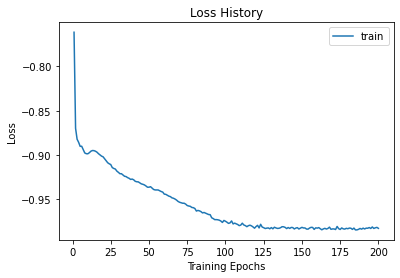

In [11]:
# plot loss history
loss_history_read = pd.read_csv('./losscsv.csv',names=["num", "loss"],header=0)
loss_history = []
for i in range(len(loss_history_read['loss'])):
    #print(loss_history_read['loss'][i])
    loss_history.append(loss_history_read['loss'][i])
#print(loss_history)
plt.title('Loss History')
plt.plot(range(1, num_epochs+1), loss_history, label='train')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()
np.save('regmap_mlpmixer_history.npy',  np.array(loss_history))

In [12]:
# define Linear Classifier for transfer learning
class LinearClassifier(nn.Module):  
    def __init__(self, backbone):
        super(LinearClassifier, self).__init__()
        self.backbone = backbone
        self.ln = nn.LayerNorm(512)
        self.fc1 = nn.Linear(512, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(2048, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(2048, 1)
        for name, param in self.backbone.named_parameters():
            param.requires_grad = False
    
    def forward(self, x):
        x = self.backbone(x)
#         x = self.ln(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

lincls = LinearClassifier(backbone=encoder).to(device)
# summary(lincls)

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma, pos_weight):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

linear_epoch = 2000
linear_scaler = amp.GradScaler()#weight=torch.FloatTensor(class_weight).to(device)
linear_loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight[1]]).to(device))#nn.CrossEntropyLoss(weight=torch.HalfTensor(class_weight).to(device))
# linear_opt =  optim.SGD(encoder.parameters(), lr=30, momentum=0.9, weight_decay=1e-4)#pos_weight=torch.FloatTensor(class_weight[1]).to(device)
linear_opt =  optim.AdamW(lincls.parameters(), eps=1e-3)
linear_scheduler = CosineAnnealingWarmRestarts(linear_opt, T_0=5, T_mult=2)

In [ ]:
loss_hist = {'train':[], 'val':[]}
linear_epoch = 2000
start_time = time.time()
path2weights_lincls_1000 = './models/lincls_weights_dl1000_motif_CE.pt'
max_auc = 0
auc = 0
from sklearn import metrics
# start training
best_auc = 0
test_pred, test_gold = [], []
for epoch in range(linear_epoch):
    # clear_output()
    print('Epoch {}/{}'.format(epoch+1, linear_epoch))

    running_train_loss = 0
    running_val_loss = 0
    running_test_loss = 0
    train_pred, train_gold = [], []
    val_pred, val_gold = [], []
    test_pred, test_gold = [], []
    # transfer dataloader
    lincls.train()
    for i, (x, y) in enumerate(tqdm(train_dl1000)):
        # retrieve query and key
        x = x.float().to(device)
        y = y.float().to(device)
        # extract features using linear_encoder
        with amp.autocast():
            pred = lincls(x)#.reshape(-1,)
            loss = linear_loss_func(pred, y.reshape(-1,1))
#         loss.backward()
#         opt.step()
            linear_opt.zero_grad()
            linear_scaler.scale(loss).backward()
            linear_scaler.step(linear_opt)
            linear_scale = linear_scaler.get_scale()
            linear_scaler.update()
        temp_pos = y.int().detach().cpu().numpy()
        train_pred.extend(pred.detach().cpu().numpy())
        train_gold.extend(temp_pos)
        running_train_loss += loss
#         loss.backward()
#         linear_opt.step()
#         linear_scheduler.step()
        
#         skip_lr_sched = (linear_scale > linear_scaler.get_scale())
#         if not skip_lr_sched:
#             linear_scheduler.step()
    train_loss = running_train_loss / (i+1)
    loss_hist['train'].append(train_loss.detach().cpu().numpy())
    train_pred, train_gold = np.array(train_pred).reshape(-1), np.array(train_gold).reshape(-1)
    # validation dataloader
    lincls.eval()
    for i, (x, y) in enumerate(val_dl1000):
        x = x.float().to(device)
        y = y.float().to(device)
        
        #with torch.no_grad():
        with amp.autocast():
            pred = lincls(x)
            running_val_loss += loss
        val_pred.extend(pred.detach().cpu().numpy())
        val_gold.extend(y.int().detach().cpu().numpy())
    val_pred, val_gold = np.array(val_pred).reshape(-1), np.array(val_gold).reshape(-1)
    AUROC = metrics.roc_auc_score(val_gold, val_pred)
    AUPR = metrics.average_precision_score(val_gold, val_pred)
    
    val_loss = running_val_loss / (i+1)
    loss_hist['val'].append(val_loss.detach().cpu().numpy())
    print('train loss: %.6f, val loss: %.6f, AUROC score: %.4f, AUPR score: %.4f, time: %.4f min' %(train_loss, val_loss, AUROC, AUPR, (time.time()-start_time)/60))
    print('-'*10)
    if AUROC > best_auc:
        best_auc = AUROC
        best_model = copy.deepcopy(lincls)
#保存模型
torch.save(lincls.state_dict(), path2weights_lincls_1000)

In [23]:


for i, (x, y) in enumerate(tqdm(test_dl1000)):
    # retrieve query and key
    x = x.float().to(device)
    y = y.float().to(device)
    # extract features using q_encoder
    with torch.no_grad():
        with amp.autocast():
            linear_opt.zero_grad()
            pred = best_model(x)# .reshape(-1,)
            loss = linear_loss_func(pred, y.reshape(-1,1))
        test_pred.extend(pred.detach().cpu().numpy())
        test_gold.extend(y.int().detach().cpu().numpy())
torch.cuda.empty_cache()
test_loss = running_test_loss / (i+1)
test_pred, test_gold = np.array(test_pred).reshape(-1), np.array(test_gold).reshape(-1)
AUROC = metrics.roc_auc_score(test_gold, test_pred)
AUPR = metrics.average_precision_score(test_gold, test_pred)
# F1 = metrics.f1_score(test_gold, test_pred)
# BAS = metrics.balanced_accuracy_score(test_gold, test_pred)
# Accuracy = metrics.accuracy_score(test_gold, test_pred)
print('Test Metric:',AUROC, AUPR)

100%|██████████| 31/31 [00:02<00:00, 12.85it/s]

Test Metric: 0.7985754552402629 0.2598282278734937


In [14]:
loss_hist = {'train':[], 'val':[]}
start_time = time.time()

max_auc = 0
auc = 0
path2weights_lincls_2000 = './models/lincls_weights_2000_motif_CE.pt'
from sklearn import metrics
# start training
best_auc = 0
test_pred, test_gold = [], []
for epoch in range(linear_epoch):
    # clear_output()
    print('Epoch {}/{}'.format(epoch+1, linear_epoch))

    running_train_loss = 0
    running_val_loss = 0
    running_test_loss = 0
    train_pred, train_gold = [], []
    val_pred, val_gold = [], []
    test_pred, test_gold = [], []
    # transfer dataloader
    lincls.train()
    for i, (x, y) in enumerate(tqdm(train_dl2000)):
        # retrieve query and key
        x = x.float().to(device)
        y = y.float().to(device)
        # extract features using linear_encoder
        with amp.autocast():
            pred = lincls(x)#.reshape(-1,)
            loss = linear_loss_func(pred, y.reshape(-1,1))
#         loss.backward()
#         opt.step()
            linear_opt.zero_grad()
            linear_scaler.scale(loss).backward()
            linear_scaler.step(linear_opt)
            linear_scale = linear_scaler.get_scale()
            linear_scaler.update()
        temp_pos = y.int().detach().cpu().numpy()
        train_pred.extend(pred.detach().cpu().numpy())
        train_gold.extend(temp_pos)
        running_train_loss += loss
#         loss.backward()
#         linear_opt.step()
#         linear_scheduler.step()
        
#         skip_lr_sched = (linear_scale > linear_scaler.get_scale())
#         if not skip_lr_sched:
#             linear_scheduler.step()
    train_loss = running_train_loss / (i+1)
    loss_hist['train'].append(train_loss.detach().cpu().numpy())
    train_pred, train_gold = np.array(train_pred).reshape(-1), np.array(train_gold).reshape(-1)
    # validation dataloader
    lincls.eval()
    for i, (x, y) in enumerate(val_dl2000):
        x = x.float().to(device)
        y = y.float().to(device)
        
        #with torch.no_grad():
        with amp.autocast():
            pred = lincls(x)
            running_val_loss += loss
        val_pred.extend(pred.detach().cpu().numpy())
        val_gold.extend(y.int().detach().cpu().numpy())
    val_pred, val_gold = np.array(val_pred).reshape(-1), np.array(val_gold).reshape(-1)
    AUROC = metrics.roc_auc_score(val_gold, val_pred)
    AUPR = metrics.average_precision_score(val_gold, val_pred)
    
    val_loss = running_val_loss / (i+1)
    loss_hist['val'].append(val_loss.detach().cpu().numpy())
    print('train loss: %.6f, val loss: %.6f, AUROC score: %.4f, AUPR score: %.4f, time: %.4f min' %(train_loss, val_loss, AUROC, AUPR, (time.time()-start_time)/60))
    print('-'*10)
    torch.save(lincls.state_dict(), path2weights_lincls_2000)
    if AUROC > best_auc:
        best_auc = AUROC
        best_model = copy.deepcopy(lincls)


Epoch 1/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.016772, val loss: 0.011136, AUROC score: 0.7224, AUPR score: 0.1506, time: 0.7854 min
----------
Epoch 2/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009832, val loss: 0.012630, AUROC score: 0.7411, AUPR score: 0.1680, time: 1.5707 min
----------
Epoch 3/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009787, val loss: 0.007673, AUROC score: 0.7436, AUPR score: 0.1621, time: 2.3508 min
----------
Epoch 4/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009749, val loss: 0.009175, AUROC score: 0.7541, AUPR score: 0.1705, time: 3.1169 min
----------
Epoch 5/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009733, val loss: 0.006532, AUROC score: 0.7575, AUPR score: 0.1680, time: 3.8940 min
----------
Epoch 6/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009700, val loss: 0.011556, AUROC score: 0.7636, AUPR score: 0.1676, time: 4.6718 min
----------
Epoch 7/2000


100%|██████████| 393/393 [00:35<00:00, 11.06it/s]


train loss: 0.009706, val loss: 0.011553, AUROC score: 0.7658, AUPR score: 0.1687, time: 5.4509 min
----------
Epoch 8/2000


100%|██████████| 393/393 [00:35<00:00, 11.02it/s]


train loss: 0.009700, val loss: 0.012426, AUROC score: 0.7611, AUPR score: 0.1713, time: 6.2369 min
----------
Epoch 9/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009697, val loss: 0.009003, AUROC score: 0.7590, AUPR score: 0.1719, time: 7.0171 min
----------
Epoch 10/2000


100%|██████████| 393/393 [00:35<00:00, 10.98it/s]


train loss: 0.009677, val loss: 0.005219, AUROC score: 0.7642, AUPR score: 0.1729, time: 7.8006 min
----------
Epoch 11/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009688, val loss: 0.006715, AUROC score: 0.7572, AUPR score: 0.1664, time: 8.5757 min
----------
Epoch 12/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009684, val loss: 0.012725, AUROC score: 0.7645, AUPR score: 0.1669, time: 9.3525 min
----------
Epoch 13/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009673, val loss: 0.011845, AUROC score: 0.7661, AUPR score: 0.1679, time: 10.1308 min
----------
Epoch 14/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009676, val loss: 0.009810, AUROC score: 0.7626, AUPR score: 0.1692, time: 10.9023 min
----------
Epoch 15/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009653, val loss: 0.010485, AUROC score: 0.7694, AUPR score: 0.1691, time: 11.6731 min
----------
Epoch 16/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009670, val loss: 0.008704, AUROC score: 0.7691, AUPR score: 0.1717, time: 12.4482 min
----------
Epoch 17/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009673, val loss: 0.008782, AUROC score: 0.7682, AUPR score: 0.1714, time: 13.2234 min
----------
Epoch 18/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009675, val loss: 0.008737, AUROC score: 0.7620, AUPR score: 0.1680, time: 14.0038 min
----------
Epoch 19/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009672, val loss: 0.010264, AUROC score: 0.7630, AUPR score: 0.1614, time: 14.7793 min
----------
Epoch 20/2000


100%|██████████| 393/393 [00:35<00:00, 11.03it/s]


train loss: 0.009669, val loss: 0.012027, AUROC score: 0.7696, AUPR score: 0.1722, time: 15.5615 min
----------
Epoch 21/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009660, val loss: 0.006383, AUROC score: 0.7623, AUPR score: 0.1669, time: 16.3377 min
----------
Epoch 22/2000


100%|██████████| 393/393 [00:36<00:00, 10.83it/s]


train loss: 0.009657, val loss: 0.010014, AUROC score: 0.7648, AUPR score: 0.1752, time: 17.1253 min
----------
Epoch 23/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009678, val loss: 0.010155, AUROC score: 0.7539, AUPR score: 0.1604, time: 17.8991 min
----------
Epoch 24/2000


100%|██████████| 393/393 [00:36<00:00, 10.85it/s]


train loss: 0.009655, val loss: 0.009908, AUROC score: 0.7651, AUPR score: 0.1671, time: 18.6894 min
----------
Epoch 25/2000


100%|██████████| 393/393 [00:35<00:00, 11.04it/s]


train loss: 0.009661, val loss: 0.009476, AUROC score: 0.7606, AUPR score: 0.1636, time: 19.4668 min
----------
Epoch 26/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009648, val loss: 0.008464, AUROC score: 0.7702, AUPR score: 0.1720, time: 20.2448 min
----------
Epoch 27/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009653, val loss: 0.007971, AUROC score: 0.7659, AUPR score: 0.1683, time: 21.0189 min
----------
Epoch 28/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009647, val loss: 0.010323, AUROC score: 0.7704, AUPR score: 0.1709, time: 21.7947 min
----------
Epoch 29/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009639, val loss: 0.014340, AUROC score: 0.7742, AUPR score: 0.1793, time: 22.5775 min
----------
Epoch 30/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009647, val loss: 0.012893, AUROC score: 0.7651, AUPR score: 0.1707, time: 23.3499 min
----------
Epoch 31/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009629, val loss: 0.011974, AUROC score: 0.7712, AUPR score: 0.1814, time: 24.1276 min
----------
Epoch 32/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009640, val loss: 0.006041, AUROC score: 0.7714, AUPR score: 0.1750, time: 24.9109 min
----------
Epoch 33/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009635, val loss: 0.006888, AUROC score: 0.7769, AUPR score: 0.1779, time: 25.6807 min
----------
Epoch 34/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009622, val loss: 0.008293, AUROC score: 0.7765, AUPR score: 0.1789, time: 26.4524 min
----------
Epoch 35/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009647, val loss: 0.010840, AUROC score: 0.7754, AUPR score: 0.1685, time: 27.2238 min
----------
Epoch 36/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009632, val loss: 0.008913, AUROC score: 0.7694, AUPR score: 0.1670, time: 27.9959 min
----------
Epoch 37/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009619, val loss: 0.008985, AUROC score: 0.7700, AUPR score: 0.1720, time: 28.7623 min
----------
Epoch 38/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009639, val loss: 0.008027, AUROC score: 0.7741, AUPR score: 0.1728, time: 29.5288 min
----------
Epoch 39/2000


100%|██████████| 393/393 [00:35<00:00, 11.00it/s]


train loss: 0.009641, val loss: 0.019236, AUROC score: 0.7749, AUPR score: 0.1791, time: 30.3075 min
----------
Epoch 40/2000


100%|██████████| 393/393 [00:35<00:00, 10.96it/s]


train loss: 0.009634, val loss: 0.009376, AUROC score: 0.7745, AUPR score: 0.1690, time: 31.0960 min
----------
Epoch 41/2000


100%|██████████| 393/393 [00:35<00:00, 11.00it/s]


train loss: 0.009639, val loss: 0.011295, AUROC score: 0.7723, AUPR score: 0.1765, time: 31.8809 min
----------
Epoch 42/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009640, val loss: 0.010548, AUROC score: 0.7750, AUPR score: 0.1768, time: 32.6469 min
----------
Epoch 43/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009610, val loss: 0.009397, AUROC score: 0.7659, AUPR score: 0.1756, time: 33.4081 min
----------
Epoch 44/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009627, val loss: 0.012436, AUROC score: 0.7743, AUPR score: 0.1773, time: 34.1747 min
----------
Epoch 45/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009633, val loss: 0.012306, AUROC score: 0.7736, AUPR score: 0.1743, time: 34.9422 min
----------
Epoch 46/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009631, val loss: 0.009081, AUROC score: 0.7741, AUPR score: 0.1741, time: 35.7138 min
----------
Epoch 47/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009646, val loss: 0.008156, AUROC score: 0.7662, AUPR score: 0.1767, time: 36.4785 min
----------
Epoch 48/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009624, val loss: 0.012448, AUROC score: 0.7752, AUPR score: 0.1797, time: 37.2505 min
----------
Epoch 49/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009629, val loss: 0.005991, AUROC score: 0.7761, AUPR score: 0.1687, time: 38.0161 min
----------
Epoch 50/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009629, val loss: 0.016068, AUROC score: 0.7670, AUPR score: 0.1694, time: 38.7846 min
----------
Epoch 51/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009622, val loss: 0.010299, AUROC score: 0.7757, AUPR score: 0.1728, time: 39.5533 min
----------
Epoch 52/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009618, val loss: 0.009322, AUROC score: 0.7770, AUPR score: 0.1751, time: 40.3195 min
----------
Epoch 53/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009634, val loss: 0.005331, AUROC score: 0.7712, AUPR score: 0.1725, time: 41.0880 min
----------
Epoch 54/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009608, val loss: 0.011475, AUROC score: 0.7766, AUPR score: 0.1752, time: 41.8528 min
----------
Epoch 55/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009634, val loss: 0.006846, AUROC score: 0.7738, AUPR score: 0.1740, time: 42.6211 min
----------
Epoch 56/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009617, val loss: 0.010789, AUROC score: 0.7760, AUPR score: 0.1838, time: 43.3925 min
----------
Epoch 57/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009621, val loss: 0.008679, AUROC score: 0.7741, AUPR score: 0.1753, time: 44.1586 min
----------
Epoch 58/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009610, val loss: 0.009717, AUROC score: 0.7749, AUPR score: 0.1787, time: 44.9270 min
----------
Epoch 59/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009622, val loss: 0.016346, AUROC score: 0.7706, AUPR score: 0.1777, time: 45.6963 min
----------
Epoch 60/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009622, val loss: 0.010701, AUROC score: 0.7789, AUPR score: 0.1813, time: 46.4557 min
----------
Epoch 61/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009623, val loss: 0.013406, AUROC score: 0.7691, AUPR score: 0.1723, time: 47.2137 min
----------
Epoch 62/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009622, val loss: 0.008329, AUROC score: 0.7741, AUPR score: 0.1706, time: 47.9747 min
----------
Epoch 63/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009622, val loss: 0.012576, AUROC score: 0.7745, AUPR score: 0.1795, time: 48.7597 min
----------
Epoch 64/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009617, val loss: 0.005357, AUROC score: 0.7748, AUPR score: 0.1774, time: 49.5259 min
----------
Epoch 65/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009601, val loss: 0.016532, AUROC score: 0.7775, AUPR score: 0.1834, time: 50.2861 min
----------
Epoch 66/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009612, val loss: 0.014992, AUROC score: 0.7794, AUPR score: 0.1778, time: 51.0507 min
----------
Epoch 67/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009595, val loss: 0.010623, AUROC score: 0.7763, AUPR score: 0.1767, time: 51.8171 min
----------
Epoch 68/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009611, val loss: 0.011880, AUROC score: 0.7716, AUPR score: 0.1770, time: 52.5805 min
----------
Epoch 69/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009615, val loss: 0.015268, AUROC score: 0.7761, AUPR score: 0.1750, time: 53.3427 min
----------
Epoch 70/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009603, val loss: 0.008253, AUROC score: 0.7756, AUPR score: 0.1789, time: 54.1089 min
----------
Epoch 71/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009602, val loss: 0.004857, AUROC score: 0.7750, AUPR score: 0.1781, time: 54.8758 min
----------
Epoch 72/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009609, val loss: 0.007307, AUROC score: 0.7772, AUPR score: 0.1808, time: 55.6461 min
----------
Epoch 73/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009618, val loss: 0.014158, AUROC score: 0.7739, AUPR score: 0.1751, time: 56.4099 min
----------
Epoch 74/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009598, val loss: 0.010690, AUROC score: 0.7737, AUPR score: 0.1694, time: 57.1741 min
----------
Epoch 75/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009619, val loss: 0.005654, AUROC score: 0.7739, AUPR score: 0.1793, time: 57.9400 min
----------
Epoch 76/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009621, val loss: 0.006662, AUROC score: 0.7786, AUPR score: 0.1831, time: 58.7071 min
----------
Epoch 77/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009599, val loss: 0.010122, AUROC score: 0.7774, AUPR score: 0.1742, time: 59.4738 min
----------
Epoch 78/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009608, val loss: 0.006985, AUROC score: 0.7760, AUPR score: 0.1754, time: 60.2399 min
----------
Epoch 79/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009602, val loss: 0.008109, AUROC score: 0.7778, AUPR score: 0.1816, time: 60.9982 min
----------
Epoch 80/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009610, val loss: 0.009760, AUROC score: 0.7746, AUPR score: 0.1778, time: 61.7620 min
----------
Epoch 81/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009610, val loss: 0.008656, AUROC score: 0.7742, AUPR score: 0.1670, time: 62.5255 min
----------
Epoch 82/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009591, val loss: 0.006576, AUROC score: 0.7769, AUPR score: 0.1795, time: 63.2975 min
----------
Epoch 83/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009602, val loss: 0.010183, AUROC score: 0.7774, AUPR score: 0.1757, time: 64.0729 min
----------
Epoch 84/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009600, val loss: 0.012068, AUROC score: 0.7748, AUPR score: 0.1732, time: 64.8446 min
----------
Epoch 85/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009606, val loss: 0.013140, AUROC score: 0.7708, AUPR score: 0.1764, time: 65.6067 min
----------
Epoch 86/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009598, val loss: 0.009071, AUROC score: 0.7744, AUPR score: 0.1780, time: 66.3686 min
----------
Epoch 87/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009595, val loss: 0.006738, AUROC score: 0.7770, AUPR score: 0.1775, time: 67.1300 min
----------
Epoch 88/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009600, val loss: 0.011438, AUROC score: 0.7757, AUPR score: 0.1803, time: 67.8917 min
----------
Epoch 89/2000


100%|██████████| 393/393 [00:36<00:00, 10.82it/s]


train loss: 0.009591, val loss: 0.009197, AUROC score: 0.7762, AUPR score: 0.1754, time: 68.6917 min
----------
Epoch 90/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009603, val loss: 0.011818, AUROC score: 0.7766, AUPR score: 0.1730, time: 69.4515 min
----------
Epoch 91/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009599, val loss: 0.007026, AUROC score: 0.7801, AUPR score: 0.1823, time: 70.2144 min
----------
Epoch 92/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009606, val loss: 0.009098, AUROC score: 0.7785, AUPR score: 0.1795, time: 70.9797 min
----------
Epoch 93/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009604, val loss: 0.009981, AUROC score: 0.7739, AUPR score: 0.1786, time: 71.7482 min
----------
Epoch 94/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009604, val loss: 0.006173, AUROC score: 0.7764, AUPR score: 0.1728, time: 72.5100 min
----------
Epoch 95/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009608, val loss: 0.012539, AUROC score: 0.7753, AUPR score: 0.1771, time: 73.2802 min
----------
Epoch 96/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009589, val loss: 0.008706, AUROC score: 0.7756, AUPR score: 0.1703, time: 74.0434 min
----------
Epoch 97/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009595, val loss: 0.007057, AUROC score: 0.7756, AUPR score: 0.1785, time: 74.8097 min
----------
Epoch 98/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009613, val loss: 0.005203, AUROC score: 0.7765, AUPR score: 0.1735, time: 75.5815 min
----------
Epoch 99/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009589, val loss: 0.007038, AUROC score: 0.7801, AUPR score: 0.1784, time: 76.3504 min
----------
Epoch 100/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009595, val loss: 0.007192, AUROC score: 0.7806, AUPR score: 0.1751, time: 77.1163 min
----------
Epoch 101/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009597, val loss: 0.010173, AUROC score: 0.7718, AUPR score: 0.1740, time: 77.8774 min
----------
Epoch 102/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009599, val loss: 0.009323, AUROC score: 0.7772, AUPR score: 0.1734, time: 78.6483 min
----------
Epoch 103/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009606, val loss: 0.005458, AUROC score: 0.7739, AUPR score: 0.1759, time: 79.4154 min
----------
Epoch 104/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009592, val loss: 0.008956, AUROC score: 0.7708, AUPR score: 0.1718, time: 80.1743 min
----------
Epoch 105/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009589, val loss: 0.011168, AUROC score: 0.7760, AUPR score: 0.1810, time: 80.9515 min
----------
Epoch 106/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009591, val loss: 0.006995, AUROC score: 0.7755, AUPR score: 0.1825, time: 81.7214 min
----------
Epoch 107/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009602, val loss: 0.005958, AUROC score: 0.7736, AUPR score: 0.1656, time: 82.4839 min
----------
Epoch 108/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009600, val loss: 0.013644, AUROC score: 0.7778, AUPR score: 0.1749, time: 83.2449 min
----------
Epoch 109/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009586, val loss: 0.016507, AUROC score: 0.7679, AUPR score: 0.1838, time: 84.0161 min
----------
Epoch 110/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009595, val loss: 0.017769, AUROC score: 0.7770, AUPR score: 0.1789, time: 84.7885 min
----------
Epoch 111/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009593, val loss: 0.007509, AUROC score: 0.7792, AUPR score: 0.1752, time: 85.5457 min
----------
Epoch 112/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009593, val loss: 0.007481, AUROC score: 0.7754, AUPR score: 0.1764, time: 86.3152 min
----------
Epoch 113/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009586, val loss: 0.008378, AUROC score: 0.7779, AUPR score: 0.1763, time: 87.0762 min
----------
Epoch 114/2000


100%|██████████| 393/393 [00:35<00:00, 11.03it/s]


train loss: 0.009578, val loss: 0.006917, AUROC score: 0.7779, AUPR score: 0.1742, time: 87.8507 min
----------
Epoch 115/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009582, val loss: 0.011193, AUROC score: 0.7778, AUPR score: 0.1770, time: 88.6150 min
----------
Epoch 116/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009588, val loss: 0.010123, AUROC score: 0.7692, AUPR score: 0.1765, time: 89.3786 min
----------
Epoch 117/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009597, val loss: 0.011282, AUROC score: 0.7756, AUPR score: 0.1797, time: 90.1380 min
----------
Epoch 118/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009579, val loss: 0.008547, AUROC score: 0.7761, AUPR score: 0.1784, time: 90.9087 min
----------
Epoch 119/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009596, val loss: 0.009322, AUROC score: 0.7785, AUPR score: 0.1787, time: 91.6766 min
----------
Epoch 120/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009590, val loss: 0.010128, AUROC score: 0.7795, AUPR score: 0.1746, time: 92.4400 min
----------
Epoch 121/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009587, val loss: 0.010172, AUROC score: 0.7787, AUPR score: 0.1843, time: 93.2147 min
----------
Epoch 122/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009594, val loss: 0.012420, AUROC score: 0.7819, AUPR score: 0.1834, time: 93.9844 min
----------
Epoch 123/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009591, val loss: 0.008904, AUROC score: 0.7745, AUPR score: 0.1785, time: 94.7535 min
----------
Epoch 124/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009586, val loss: 0.006827, AUROC score: 0.7778, AUPR score: 0.1716, time: 95.5196 min
----------
Epoch 125/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009594, val loss: 0.012201, AUROC score: 0.7761, AUPR score: 0.1781, time: 96.2817 min
----------
Epoch 126/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009595, val loss: 0.014845, AUROC score: 0.7775, AUPR score: 0.1773, time: 97.0524 min
----------
Epoch 127/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009595, val loss: 0.010312, AUROC score: 0.7750, AUPR score: 0.1802, time: 97.8183 min
----------
Epoch 128/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009595, val loss: 0.010168, AUROC score: 0.7756, AUPR score: 0.1771, time: 98.5946 min
----------
Epoch 129/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009588, val loss: 0.012760, AUROC score: 0.7747, AUPR score: 0.1754, time: 99.3605 min
----------
Epoch 130/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009596, val loss: 0.013448, AUROC score: 0.7795, AUPR score: 0.1783, time: 100.1226 min
----------
Epoch 131/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009596, val loss: 0.011041, AUROC score: 0.7782, AUPR score: 0.1782, time: 100.8911 min
----------
Epoch 132/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009575, val loss: 0.010079, AUROC score: 0.7722, AUPR score: 0.1722, time: 101.6549 min
----------
Epoch 133/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009580, val loss: 0.010224, AUROC score: 0.7775, AUPR score: 0.1773, time: 102.4145 min
----------
Epoch 134/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009602, val loss: 0.008068, AUROC score: 0.7772, AUPR score: 0.1823, time: 103.1891 min
----------
Epoch 135/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009596, val loss: 0.014039, AUROC score: 0.7788, AUPR score: 0.1784, time: 103.9636 min
----------
Epoch 136/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009584, val loss: 0.008454, AUROC score: 0.7759, AUPR score: 0.1718, time: 104.7314 min
----------
Epoch 137/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009593, val loss: 0.013082, AUROC score: 0.7740, AUPR score: 0.1746, time: 105.4935 min
----------
Epoch 138/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009582, val loss: 0.010359, AUROC score: 0.7754, AUPR score: 0.1741, time: 106.2666 min
----------
Epoch 139/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009588, val loss: 0.008315, AUROC score: 0.7761, AUPR score: 0.1757, time: 107.0291 min
----------
Epoch 140/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009580, val loss: 0.011103, AUROC score: 0.7784, AUPR score: 0.1806, time: 107.7908 min
----------
Epoch 141/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009590, val loss: 0.006650, AUROC score: 0.7781, AUPR score: 0.1793, time: 108.5661 min
----------
Epoch 142/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009592, val loss: 0.007867, AUROC score: 0.7799, AUPR score: 0.1788, time: 109.3347 min
----------
Epoch 143/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009578, val loss: 0.007337, AUROC score: 0.7773, AUPR score: 0.1768, time: 110.0928 min
----------
Epoch 144/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009575, val loss: 0.009752, AUROC score: 0.7805, AUPR score: 0.1751, time: 110.8514 min
----------
Epoch 145/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009586, val loss: 0.009592, AUROC score: 0.7813, AUPR score: 0.1789, time: 111.6146 min
----------
Epoch 146/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009584, val loss: 0.012951, AUROC score: 0.7739, AUPR score: 0.1833, time: 112.3853 min
----------
Epoch 147/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009586, val loss: 0.005954, AUROC score: 0.7778, AUPR score: 0.1788, time: 113.1591 min
----------
Epoch 148/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009587, val loss: 0.012557, AUROC score: 0.7802, AUPR score: 0.1827, time: 113.9445 min
----------
Epoch 149/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009577, val loss: 0.012805, AUROC score: 0.7767, AUPR score: 0.1814, time: 114.7052 min
----------
Epoch 150/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009582, val loss: 0.011939, AUROC score: 0.7790, AUPR score: 0.1816, time: 115.4664 min
----------
Epoch 151/2000


100%|██████████| 393/393 [00:34<00:00, 11.41it/s]


train loss: 0.009583, val loss: 0.005930, AUROC score: 0.7786, AUPR score: 0.1784, time: 116.2213 min
----------
Epoch 152/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009580, val loss: 0.011925, AUROC score: 0.7772, AUPR score: 0.1789, time: 116.9928 min
----------
Epoch 153/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009585, val loss: 0.011841, AUROC score: 0.7770, AUPR score: 0.1804, time: 117.7508 min
----------
Epoch 154/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009582, val loss: 0.005848, AUROC score: 0.7794, AUPR score: 0.1868, time: 118.5240 min
----------
Epoch 155/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009584, val loss: 0.008427, AUROC score: 0.7777, AUPR score: 0.1856, time: 119.3021 min
----------
Epoch 156/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009588, val loss: 0.011734, AUROC score: 0.7777, AUPR score: 0.1747, time: 120.0615 min
----------
Epoch 157/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009583, val loss: 0.008578, AUROC score: 0.7810, AUPR score: 0.1821, time: 120.8237 min
----------
Epoch 158/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009591, val loss: 0.014009, AUROC score: 0.7756, AUPR score: 0.1864, time: 121.5846 min
----------
Epoch 159/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009589, val loss: 0.014034, AUROC score: 0.7798, AUPR score: 0.1781, time: 122.3517 min
----------
Epoch 160/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009583, val loss: 0.007206, AUROC score: 0.7767, AUPR score: 0.1759, time: 123.1363 min
----------
Epoch 161/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009580, val loss: 0.008553, AUROC score: 0.7783, AUPR score: 0.1798, time: 123.9008 min
----------
Epoch 162/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009571, val loss: 0.008093, AUROC score: 0.7774, AUPR score: 0.1768, time: 124.6680 min
----------
Epoch 163/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009584, val loss: 0.007953, AUROC score: 0.7780, AUPR score: 0.1789, time: 125.4376 min
----------
Epoch 164/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009570, val loss: 0.008896, AUROC score: 0.7781, AUPR score: 0.1797, time: 126.2008 min
----------
Epoch 165/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009584, val loss: 0.006898, AUROC score: 0.7771, AUPR score: 0.1829, time: 126.9713 min
----------
Epoch 166/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009583, val loss: 0.008184, AUROC score: 0.7790, AUPR score: 0.1797, time: 127.7375 min
----------
Epoch 167/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009569, val loss: 0.008368, AUROC score: 0.7758, AUPR score: 0.1736, time: 128.5060 min
----------
Epoch 168/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009568, val loss: 0.010758, AUROC score: 0.7768, AUPR score: 0.1787, time: 129.2716 min
----------
Epoch 169/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009579, val loss: 0.005858, AUROC score: 0.7788, AUPR score: 0.1761, time: 130.0324 min
----------
Epoch 170/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009580, val loss: 0.009054, AUROC score: 0.7743, AUPR score: 0.1733, time: 130.7979 min
----------
Epoch 171/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009587, val loss: 0.007783, AUROC score: 0.7803, AUPR score: 0.1846, time: 131.5641 min
----------
Epoch 172/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009577, val loss: 0.008466, AUROC score: 0.7805, AUPR score: 0.1790, time: 132.3297 min
----------
Epoch 173/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009577, val loss: 0.006797, AUROC score: 0.7796, AUPR score: 0.1812, time: 133.0952 min
----------
Epoch 174/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009578, val loss: 0.012228, AUROC score: 0.7722, AUPR score: 0.1729, time: 133.8647 min
----------
Epoch 175/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009565, val loss: 0.005185, AUROC score: 0.7769, AUPR score: 0.1823, time: 134.6282 min
----------
Epoch 176/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009575, val loss: 0.010504, AUROC score: 0.7817, AUPR score: 0.1820, time: 135.3962 min
----------
Epoch 177/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009579, val loss: 0.009467, AUROC score: 0.7788, AUPR score: 0.1801, time: 136.1607 min
----------
Epoch 178/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009579, val loss: 0.006092, AUROC score: 0.7779, AUPR score: 0.1783, time: 136.9404 min
----------
Epoch 179/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009570, val loss: 0.006207, AUROC score: 0.7744, AUPR score: 0.1788, time: 137.7059 min
----------
Epoch 180/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009574, val loss: 0.008192, AUROC score: 0.7797, AUPR score: 0.1754, time: 138.4648 min
----------
Epoch 181/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009577, val loss: 0.014149, AUROC score: 0.7795, AUPR score: 0.1849, time: 139.2347 min
----------
Epoch 182/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009574, val loss: 0.009335, AUROC score: 0.7791, AUPR score: 0.1739, time: 140.0069 min
----------
Epoch 183/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009577, val loss: 0.005546, AUROC score: 0.7799, AUPR score: 0.1737, time: 140.7742 min
----------
Epoch 184/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009583, val loss: 0.014154, AUROC score: 0.7747, AUPR score: 0.1759, time: 141.5452 min
----------
Epoch 185/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009571, val loss: 0.006620, AUROC score: 0.7790, AUPR score: 0.1843, time: 142.3132 min
----------
Epoch 186/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009572, val loss: 0.008210, AUROC score: 0.7826, AUPR score: 0.1877, time: 143.0803 min
----------
Epoch 187/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009564, val loss: 0.013546, AUROC score: 0.7809, AUPR score: 0.1820, time: 143.8574 min
----------
Epoch 188/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009576, val loss: 0.008061, AUROC score: 0.7771, AUPR score: 0.1793, time: 144.6216 min
----------
Epoch 189/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009575, val loss: 0.005779, AUROC score: 0.7796, AUPR score: 0.1821, time: 145.3888 min
----------
Epoch 190/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009576, val loss: 0.006234, AUROC score: 0.7735, AUPR score: 0.1790, time: 146.1579 min
----------
Epoch 191/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009576, val loss: 0.008314, AUROC score: 0.7796, AUPR score: 0.1718, time: 146.9203 min
----------
Epoch 192/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009575, val loss: 0.010539, AUROC score: 0.7777, AUPR score: 0.1793, time: 147.6909 min
----------
Epoch 193/2000


100%|██████████| 393/393 [00:36<00:00, 10.91it/s]


train loss: 0.009576, val loss: 0.009338, AUROC score: 0.7763, AUPR score: 0.1782, time: 148.4866 min
----------
Epoch 194/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009583, val loss: 0.011164, AUROC score: 0.7807, AUPR score: 0.1746, time: 149.2608 min
----------
Epoch 195/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009566, val loss: 0.008363, AUROC score: 0.7782, AUPR score: 0.1842, time: 150.0256 min
----------
Epoch 196/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009574, val loss: 0.010821, AUROC score: 0.7815, AUPR score: 0.1839, time: 150.7932 min
----------
Epoch 197/2000


100%|██████████| 393/393 [00:35<00:00, 11.06it/s]


train loss: 0.009576, val loss: 0.010721, AUROC score: 0.7806, AUPR score: 0.1776, time: 151.5831 min
----------
Epoch 198/2000


100%|██████████| 393/393 [00:35<00:00, 11.02it/s]


train loss: 0.009579, val loss: 0.006704, AUROC score: 0.7721, AUPR score: 0.1743, time: 152.3614 min
----------
Epoch 199/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009568, val loss: 0.009698, AUROC score: 0.7803, AUPR score: 0.1863, time: 153.1351 min
----------
Epoch 200/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009576, val loss: 0.012185, AUROC score: 0.7759, AUPR score: 0.1839, time: 153.8998 min
----------
Epoch 201/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009573, val loss: 0.008085, AUROC score: 0.7779, AUPR score: 0.1787, time: 154.6581 min
----------
Epoch 202/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009561, val loss: 0.007601, AUROC score: 0.7763, AUPR score: 0.1788, time: 155.4241 min
----------
Epoch 203/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009567, val loss: 0.005096, AUROC score: 0.7807, AUPR score: 0.1823, time: 156.1843 min
----------
Epoch 204/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009562, val loss: 0.004482, AUROC score: 0.7802, AUPR score: 0.1784, time: 156.9616 min
----------
Epoch 205/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009575, val loss: 0.004869, AUROC score: 0.7741, AUPR score: 0.1798, time: 157.7354 min
----------
Epoch 206/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009569, val loss: 0.006425, AUROC score: 0.7816, AUPR score: 0.1793, time: 158.5031 min
----------
Epoch 207/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009572, val loss: 0.005758, AUROC score: 0.7791, AUPR score: 0.1889, time: 159.2662 min
----------
Epoch 208/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009577, val loss: 0.010781, AUROC score: 0.7782, AUPR score: 0.1773, time: 160.0291 min
----------
Epoch 209/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009582, val loss: 0.011908, AUROC score: 0.7771, AUPR score: 0.1775, time: 160.7974 min
----------
Epoch 210/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009568, val loss: 0.007477, AUROC score: 0.7733, AUPR score: 0.1811, time: 161.5615 min
----------
Epoch 211/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009587, val loss: 0.009915, AUROC score: 0.7794, AUPR score: 0.1830, time: 162.3254 min
----------
Epoch 212/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009569, val loss: 0.010825, AUROC score: 0.7731, AUPR score: 0.1786, time: 163.0980 min
----------
Epoch 213/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009562, val loss: 0.009088, AUROC score: 0.7778, AUPR score: 0.1694, time: 163.8631 min
----------
Epoch 214/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009575, val loss: 0.006526, AUROC score: 0.7779, AUPR score: 0.1825, time: 164.6292 min
----------
Epoch 215/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009581, val loss: 0.008293, AUROC score: 0.7780, AUPR score: 0.1828, time: 165.4027 min
----------
Epoch 216/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009574, val loss: 0.007260, AUROC score: 0.7792, AUPR score: 0.1773, time: 166.1719 min
----------
Epoch 217/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009567, val loss: 0.011597, AUROC score: 0.7776, AUPR score: 0.1787, time: 166.9452 min
----------
Epoch 218/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009567, val loss: 0.012682, AUROC score: 0.7747, AUPR score: 0.1806, time: 167.7147 min
----------
Epoch 219/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009568, val loss: 0.010869, AUROC score: 0.7766, AUPR score: 0.1825, time: 168.4814 min
----------
Epoch 220/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009574, val loss: 0.006792, AUROC score: 0.7803, AUPR score: 0.1784, time: 169.2593 min
----------
Epoch 221/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009572, val loss: 0.013188, AUROC score: 0.7804, AUPR score: 0.1786, time: 170.0318 min
----------
Epoch 222/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009562, val loss: 0.005593, AUROC score: 0.7816, AUPR score: 0.1819, time: 170.8063 min
----------
Epoch 223/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009578, val loss: 0.010308, AUROC score: 0.7774, AUPR score: 0.1836, time: 171.5804 min
----------
Epoch 224/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009570, val loss: 0.009290, AUROC score: 0.7824, AUPR score: 0.1809, time: 172.3468 min
----------
Epoch 225/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009570, val loss: 0.008217, AUROC score: 0.7813, AUPR score: 0.1796, time: 173.1077 min
----------
Epoch 226/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009577, val loss: 0.007619, AUROC score: 0.7815, AUPR score: 0.1847, time: 173.8809 min
----------
Epoch 227/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009571, val loss: 0.008595, AUROC score: 0.7806, AUPR score: 0.1853, time: 174.6492 min
----------
Epoch 228/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009570, val loss: 0.007948, AUROC score: 0.7816, AUPR score: 0.1823, time: 175.4171 min
----------
Epoch 229/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009572, val loss: 0.013408, AUROC score: 0.7816, AUPR score: 0.1774, time: 176.1824 min
----------
Epoch 230/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009569, val loss: 0.005043, AUROC score: 0.7795, AUPR score: 0.1814, time: 176.9542 min
----------
Epoch 231/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009565, val loss: 0.011561, AUROC score: 0.7778, AUPR score: 0.1756, time: 177.7229 min
----------
Epoch 232/2000


100%|██████████| 393/393 [00:35<00:00, 10.92it/s]


train loss: 0.009564, val loss: 0.007832, AUROC score: 0.7801, AUPR score: 0.1805, time: 178.5193 min
----------
Epoch 233/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009573, val loss: 0.010787, AUROC score: 0.7815, AUPR score: 0.1801, time: 179.2970 min
----------
Epoch 234/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009566, val loss: 0.012671, AUROC score: 0.7794, AUPR score: 0.1794, time: 180.0670 min
----------
Epoch 235/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009582, val loss: 0.005047, AUROC score: 0.7768, AUPR score: 0.1748, time: 180.8473 min
----------
Epoch 236/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009559, val loss: 0.008813, AUROC score: 0.7803, AUPR score: 0.1894, time: 181.6174 min
----------
Epoch 237/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009567, val loss: 0.006599, AUROC score: 0.7801, AUPR score: 0.1879, time: 182.3845 min
----------
Epoch 238/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009567, val loss: 0.010177, AUROC score: 0.7805, AUPR score: 0.1760, time: 183.1478 min
----------
Epoch 239/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009566, val loss: 0.009821, AUROC score: 0.7815, AUPR score: 0.1788, time: 183.9213 min
----------
Epoch 240/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009578, val loss: 0.008894, AUROC score: 0.7752, AUPR score: 0.1873, time: 184.6843 min
----------
Epoch 241/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009566, val loss: 0.006942, AUROC score: 0.7796, AUPR score: 0.1776, time: 185.4474 min
----------
Epoch 242/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009570, val loss: 0.010212, AUROC score: 0.7826, AUPR score: 0.1797, time: 186.2203 min
----------
Epoch 243/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009564, val loss: 0.005830, AUROC score: 0.7793, AUPR score: 0.1792, time: 186.9878 min
----------
Epoch 244/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009564, val loss: 0.010506, AUROC score: 0.7785, AUPR score: 0.1746, time: 187.7602 min
----------
Epoch 245/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009563, val loss: 0.013850, AUROC score: 0.7790, AUPR score: 0.1774, time: 188.5278 min
----------
Epoch 246/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009566, val loss: 0.012785, AUROC score: 0.7748, AUPR score: 0.1798, time: 189.2901 min
----------
Epoch 247/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009571, val loss: 0.015724, AUROC score: 0.7851, AUPR score: 0.1793, time: 190.0608 min
----------
Epoch 248/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009571, val loss: 0.008865, AUROC score: 0.7793, AUPR score: 0.1753, time: 190.8248 min
----------
Epoch 249/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009564, val loss: 0.007393, AUROC score: 0.7802, AUPR score: 0.1814, time: 191.6000 min
----------
Epoch 250/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009548, val loss: 0.013565, AUROC score: 0.7798, AUPR score: 0.1790, time: 192.3654 min
----------
Epoch 251/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009560, val loss: 0.007551, AUROC score: 0.7798, AUPR score: 0.1748, time: 193.1368 min
----------
Epoch 252/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009570, val loss: 0.007097, AUROC score: 0.7810, AUPR score: 0.1834, time: 193.9045 min
----------
Epoch 253/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009563, val loss: 0.011064, AUROC score: 0.7781, AUPR score: 0.1779, time: 194.6652 min
----------
Epoch 254/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009574, val loss: 0.010222, AUROC score: 0.7792, AUPR score: 0.1851, time: 195.4276 min
----------
Epoch 255/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009566, val loss: 0.013648, AUROC score: 0.7784, AUPR score: 0.1797, time: 196.1969 min
----------
Epoch 256/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009568, val loss: 0.009518, AUROC score: 0.7782, AUPR score: 0.1776, time: 196.9596 min
----------
Epoch 257/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009561, val loss: 0.007017, AUROC score: 0.7761, AUPR score: 0.1841, time: 197.7242 min
----------
Epoch 258/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009571, val loss: 0.013129, AUROC score: 0.7790, AUPR score: 0.1789, time: 198.4861 min
----------
Epoch 259/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009563, val loss: 0.009194, AUROC score: 0.7778, AUPR score: 0.1819, time: 199.2552 min
----------
Epoch 260/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009572, val loss: 0.010228, AUROC score: 0.7789, AUPR score: 0.1793, time: 200.0161 min
----------
Epoch 261/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009573, val loss: 0.008596, AUROC score: 0.7800, AUPR score: 0.1824, time: 200.7850 min
----------
Epoch 262/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009568, val loss: 0.008674, AUROC score: 0.7823, AUPR score: 0.1814, time: 201.5512 min
----------
Epoch 263/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009572, val loss: 0.010611, AUROC score: 0.7806, AUPR score: 0.1813, time: 202.3110 min
----------
Epoch 264/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009572, val loss: 0.008202, AUROC score: 0.7788, AUPR score: 0.1843, time: 203.0847 min
----------
Epoch 265/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009570, val loss: 0.006359, AUROC score: 0.7786, AUPR score: 0.1857, time: 203.8480 min
----------
Epoch 266/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009561, val loss: 0.008605, AUROC score: 0.7803, AUPR score: 0.1785, time: 204.6169 min
----------
Epoch 267/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009564, val loss: 0.011797, AUROC score: 0.7790, AUPR score: 0.1719, time: 205.3816 min
----------
Epoch 268/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009570, val loss: 0.012420, AUROC score: 0.7782, AUPR score: 0.1741, time: 206.1513 min
----------
Epoch 269/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009567, val loss: 0.010176, AUROC score: 0.7770, AUPR score: 0.1744, time: 206.9222 min
----------
Epoch 270/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009568, val loss: 0.013892, AUROC score: 0.7809, AUPR score: 0.1842, time: 207.6895 min
----------
Epoch 271/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009546, val loss: 0.009806, AUROC score: 0.7781, AUPR score: 0.1809, time: 208.4606 min
----------
Epoch 272/2000


100%|██████████| 393/393 [00:35<00:00, 11.06it/s]


train loss: 0.009560, val loss: 0.007797, AUROC score: 0.7804, AUPR score: 0.1812, time: 209.2378 min
----------
Epoch 273/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009562, val loss: 0.005872, AUROC score: 0.7768, AUPR score: 0.1800, time: 210.0073 min
----------
Epoch 274/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009558, val loss: 0.003467, AUROC score: 0.7817, AUPR score: 0.1856, time: 210.7773 min
----------
Epoch 275/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009558, val loss: 0.006203, AUROC score: 0.7764, AUPR score: 0.1733, time: 211.5440 min
----------
Epoch 276/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009566, val loss: 0.014091, AUROC score: 0.7748, AUPR score: 0.1744, time: 212.3025 min
----------
Epoch 277/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009566, val loss: 0.011135, AUROC score: 0.7809, AUPR score: 0.1844, time: 213.0671 min
----------
Epoch 278/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009550, val loss: 0.007914, AUROC score: 0.7802, AUPR score: 0.1828, time: 213.8449 min
----------
Epoch 279/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009577, val loss: 0.009586, AUROC score: 0.7818, AUPR score: 0.1822, time: 214.6062 min
----------
Epoch 280/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009552, val loss: 0.011302, AUROC score: 0.7820, AUPR score: 0.1780, time: 215.3840 min
----------
Epoch 281/2000


100%|██████████| 393/393 [00:35<00:00, 10.93it/s]


train loss: 0.009566, val loss: 0.006430, AUROC score: 0.7789, AUPR score: 0.1740, time: 216.1760 min
----------
Epoch 282/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009552, val loss: 0.011122, AUROC score: 0.7843, AUPR score: 0.1872, time: 216.9421 min
----------
Epoch 283/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009571, val loss: 0.006995, AUROC score: 0.7777, AUPR score: 0.1770, time: 217.7095 min
----------
Epoch 284/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009566, val loss: 0.008412, AUROC score: 0.7800, AUPR score: 0.1770, time: 218.4782 min
----------
Epoch 285/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009571, val loss: 0.010939, AUROC score: 0.7800, AUPR score: 0.1789, time: 219.2442 min
----------
Epoch 286/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009560, val loss: 0.007122, AUROC score: 0.7803, AUPR score: 0.1747, time: 220.0094 min
----------
Epoch 287/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009562, val loss: 0.007440, AUROC score: 0.7829, AUPR score: 0.1821, time: 220.7696 min
----------
Epoch 288/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009549, val loss: 0.010647, AUROC score: 0.7789, AUPR score: 0.1823, time: 221.5357 min
----------
Epoch 289/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009559, val loss: 0.016576, AUROC score: 0.7780, AUPR score: 0.1803, time: 222.2945 min
----------
Epoch 290/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009562, val loss: 0.006353, AUROC score: 0.7828, AUPR score: 0.1751, time: 223.0687 min
----------
Epoch 291/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009563, val loss: 0.012652, AUROC score: 0.7808, AUPR score: 0.1758, time: 223.8422 min
----------
Epoch 292/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009570, val loss: 0.006467, AUROC score: 0.7838, AUPR score: 0.1776, time: 224.6035 min
----------
Epoch 293/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009562, val loss: 0.014592, AUROC score: 0.7802, AUPR score: 0.1791, time: 225.3752 min
----------
Epoch 294/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009560, val loss: 0.010512, AUROC score: 0.7832, AUPR score: 0.2003, time: 226.1441 min
----------
Epoch 295/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009569, val loss: 0.011761, AUROC score: 0.7794, AUPR score: 0.1750, time: 226.9078 min
----------
Epoch 296/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009566, val loss: 0.004243, AUROC score: 0.7746, AUPR score: 0.1789, time: 227.6750 min
----------
Epoch 297/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009561, val loss: 0.009156, AUROC score: 0.7772, AUPR score: 0.1773, time: 228.4370 min
----------
Epoch 298/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009567, val loss: 0.006933, AUROC score: 0.7802, AUPR score: 0.1830, time: 229.2094 min
----------
Epoch 299/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009551, val loss: 0.015649, AUROC score: 0.7810, AUPR score: 0.1823, time: 229.9804 min
----------
Epoch 300/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009550, val loss: 0.009521, AUROC score: 0.7776, AUPR score: 0.1796, time: 230.7390 min
----------
Epoch 301/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009563, val loss: 0.008408, AUROC score: 0.7782, AUPR score: 0.1823, time: 231.5058 min
----------
Epoch 302/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009562, val loss: 0.008691, AUROC score: 0.7821, AUPR score: 0.1810, time: 232.2688 min
----------
Epoch 303/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009565, val loss: 0.006738, AUROC score: 0.7805, AUPR score: 0.1830, time: 233.0334 min
----------
Epoch 304/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009564, val loss: 0.008784, AUROC score: 0.7810, AUPR score: 0.1767, time: 233.8012 min
----------
Epoch 305/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009570, val loss: 0.006311, AUROC score: 0.7838, AUPR score: 0.1837, time: 234.5722 min
----------
Epoch 306/2000


100%|██████████| 393/393 [00:35<00:00, 11.03it/s]


train loss: 0.009564, val loss: 0.007555, AUROC score: 0.7803, AUPR score: 0.1758, time: 235.3620 min
----------
Epoch 307/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009555, val loss: 0.010418, AUROC score: 0.7827, AUPR score: 0.1834, time: 236.1318 min
----------
Epoch 308/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009570, val loss: 0.006264, AUROC score: 0.7832, AUPR score: 0.1830, time: 236.9109 min
----------
Epoch 309/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009567, val loss: 0.009539, AUROC score: 0.7831, AUPR score: 0.1776, time: 237.6740 min
----------
Epoch 310/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009562, val loss: 0.010685, AUROC score: 0.7805, AUPR score: 0.1801, time: 238.4469 min
----------
Epoch 311/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009569, val loss: 0.011510, AUROC score: 0.7780, AUPR score: 0.1842, time: 239.2181 min
----------
Epoch 312/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009570, val loss: 0.011253, AUROC score: 0.7820, AUPR score: 0.1899, time: 239.9942 min
----------
Epoch 313/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009562, val loss: 0.018672, AUROC score: 0.7803, AUPR score: 0.1804, time: 240.7595 min
----------
Epoch 314/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009569, val loss: 0.007906, AUROC score: 0.7799, AUPR score: 0.1779, time: 241.5231 min
----------
Epoch 315/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009554, val loss: 0.010506, AUROC score: 0.7827, AUPR score: 0.1916, time: 242.2869 min
----------
Epoch 316/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009560, val loss: 0.014728, AUROC score: 0.7816, AUPR score: 0.1806, time: 243.0507 min
----------
Epoch 317/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009560, val loss: 0.004817, AUROC score: 0.7819, AUPR score: 0.1799, time: 243.8142 min
----------
Epoch 318/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009564, val loss: 0.009034, AUROC score: 0.7811, AUPR score: 0.1793, time: 244.5753 min
----------
Epoch 319/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009556, val loss: 0.011666, AUROC score: 0.7821, AUPR score: 0.1889, time: 245.3398 min
----------
Epoch 320/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009554, val loss: 0.006243, AUROC score: 0.7824, AUPR score: 0.1865, time: 246.1051 min
----------
Epoch 321/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009555, val loss: 0.010353, AUROC score: 0.7824, AUPR score: 0.1808, time: 246.8778 min
----------
Epoch 322/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009561, val loss: 0.007031, AUROC score: 0.7796, AUPR score: 0.1746, time: 247.6497 min
----------
Epoch 323/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009565, val loss: 0.010432, AUROC score: 0.7825, AUPR score: 0.1767, time: 248.4206 min
----------
Epoch 324/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009565, val loss: 0.011057, AUROC score: 0.7835, AUPR score: 0.1822, time: 249.1895 min
----------
Epoch 325/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009566, val loss: 0.009808, AUROC score: 0.7795, AUPR score: 0.1715, time: 249.9550 min
----------
Epoch 326/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009568, val loss: 0.008748, AUROC score: 0.7817, AUPR score: 0.1786, time: 250.7160 min
----------
Epoch 327/2000


100%|██████████| 393/393 [00:34<00:00, 11.44it/s]


train loss: 0.009551, val loss: 0.008085, AUROC score: 0.7800, AUPR score: 0.1786, time: 251.4726 min
----------
Epoch 328/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009562, val loss: 0.012006, AUROC score: 0.7769, AUPR score: 0.1788, time: 252.2326 min
----------
Epoch 329/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009561, val loss: 0.009880, AUROC score: 0.7836, AUPR score: 0.1840, time: 252.9940 min
----------
Epoch 330/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009566, val loss: 0.009199, AUROC score: 0.7796, AUPR score: 0.1782, time: 253.7586 min
----------
Epoch 331/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009555, val loss: 0.010300, AUROC score: 0.7767, AUPR score: 0.1758, time: 254.5178 min
----------
Epoch 332/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009557, val loss: 0.012617, AUROC score: 0.7786, AUPR score: 0.1739, time: 255.2908 min
----------
Epoch 333/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009561, val loss: 0.007003, AUROC score: 0.7816, AUPR score: 0.1811, time: 256.0627 min
----------
Epoch 334/2000


100%|██████████| 393/393 [00:35<00:00, 10.94it/s]


train loss: 0.009553, val loss: 0.005966, AUROC score: 0.7812, AUPR score: 0.1783, time: 256.8553 min
----------
Epoch 335/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009551, val loss: 0.007321, AUROC score: 0.7820, AUPR score: 0.1865, time: 257.6189 min
----------
Epoch 336/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009558, val loss: 0.008144, AUROC score: 0.7814, AUPR score: 0.1809, time: 258.3993 min
----------
Epoch 337/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009560, val loss: 0.008900, AUROC score: 0.7808, AUPR score: 0.1789, time: 259.1705 min
----------
Epoch 338/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009560, val loss: 0.006206, AUROC score: 0.7831, AUPR score: 0.1811, time: 259.9351 min
----------
Epoch 339/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009551, val loss: 0.008856, AUROC score: 0.7813, AUPR score: 0.1784, time: 260.7166 min
----------
Epoch 340/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009562, val loss: 0.006671, AUROC score: 0.7774, AUPR score: 0.1732, time: 261.4766 min
----------
Epoch 341/2000


100%|██████████| 393/393 [00:36<00:00, 10.91it/s]


train loss: 0.009556, val loss: 0.011713, AUROC score: 0.7827, AUPR score: 0.1808, time: 262.2707 min
----------
Epoch 342/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009551, val loss: 0.005828, AUROC score: 0.7841, AUPR score: 0.1753, time: 263.0325 min
----------
Epoch 343/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009551, val loss: 0.011997, AUROC score: 0.7805, AUPR score: 0.1784, time: 263.7962 min
----------
Epoch 344/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009555, val loss: 0.015377, AUROC score: 0.7812, AUPR score: 0.1744, time: 264.5633 min
----------
Epoch 345/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009553, val loss: 0.007629, AUROC score: 0.7849, AUPR score: 0.1855, time: 265.3251 min
----------
Epoch 346/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009549, val loss: 0.008328, AUROC score: 0.7776, AUPR score: 0.1774, time: 266.0872 min
----------
Epoch 347/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009557, val loss: 0.006516, AUROC score: 0.7837, AUPR score: 0.1862, time: 266.8552 min
----------
Epoch 348/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009568, val loss: 0.011766, AUROC score: 0.7818, AUPR score: 0.1804, time: 267.6200 min
----------
Epoch 349/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009557, val loss: 0.013090, AUROC score: 0.7787, AUPR score: 0.1830, time: 268.3970 min
----------
Epoch 350/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009560, val loss: 0.003514, AUROC score: 0.7789, AUPR score: 0.1755, time: 269.1691 min
----------
Epoch 351/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009553, val loss: 0.009554, AUROC score: 0.7748, AUPR score: 0.1872, time: 269.9374 min
----------
Epoch 352/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009552, val loss: 0.007814, AUROC score: 0.7795, AUPR score: 0.1788, time: 270.7085 min
----------
Epoch 353/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009553, val loss: 0.011185, AUROC score: 0.7792, AUPR score: 0.1746, time: 271.4780 min
----------
Epoch 354/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009560, val loss: 0.008541, AUROC score: 0.7796, AUPR score: 0.1770, time: 272.2442 min
----------
Epoch 355/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009544, val loss: 0.009618, AUROC score: 0.7815, AUPR score: 0.1810, time: 273.0098 min
----------
Epoch 356/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009551, val loss: 0.004423, AUROC score: 0.7801, AUPR score: 0.1815, time: 273.7809 min
----------
Epoch 357/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009559, val loss: 0.010462, AUROC score: 0.7767, AUPR score: 0.1779, time: 274.5420 min
----------
Epoch 358/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009561, val loss: 0.013136, AUROC score: 0.7795, AUPR score: 0.1836, time: 275.3082 min
----------
Epoch 359/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009561, val loss: 0.009228, AUROC score: 0.7805, AUPR score: 0.1826, time: 276.0675 min
----------
Epoch 360/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009554, val loss: 0.011340, AUROC score: 0.7832, AUPR score: 0.1842, time: 276.8391 min
----------
Epoch 361/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009557, val loss: 0.011782, AUROC score: 0.7823, AUPR score: 0.1841, time: 277.6078 min
----------
Epoch 362/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009550, val loss: 0.010203, AUROC score: 0.7796, AUPR score: 0.1865, time: 278.3768 min
----------
Epoch 363/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009550, val loss: 0.009804, AUROC score: 0.7795, AUPR score: 0.1843, time: 279.1483 min
----------
Epoch 364/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009564, val loss: 0.007886, AUROC score: 0.7806, AUPR score: 0.1784, time: 279.9237 min
----------
Epoch 365/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009561, val loss: 0.007469, AUROC score: 0.7794, AUPR score: 0.1844, time: 280.6973 min
----------
Epoch 366/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009561, val loss: 0.008773, AUROC score: 0.7802, AUPR score: 0.1804, time: 281.4712 min
----------
Epoch 367/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009558, val loss: 0.014820, AUROC score: 0.7837, AUPR score: 0.1820, time: 282.2386 min
----------
Epoch 368/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009566, val loss: 0.007808, AUROC score: 0.7817, AUPR score: 0.1792, time: 283.0014 min
----------
Epoch 369/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009559, val loss: 0.012316, AUROC score: 0.7803, AUPR score: 0.1809, time: 283.7776 min
----------
Epoch 370/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009554, val loss: 0.008366, AUROC score: 0.7808, AUPR score: 0.1787, time: 284.5584 min
----------
Epoch 371/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009567, val loss: 0.003991, AUROC score: 0.7787, AUPR score: 0.1754, time: 285.3424 min
----------
Epoch 372/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009562, val loss: 0.006598, AUROC score: 0.7823, AUPR score: 0.1811, time: 286.1064 min
----------
Epoch 373/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009558, val loss: 0.005480, AUROC score: 0.7820, AUPR score: 0.1867, time: 286.8804 min
----------
Epoch 374/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009565, val loss: 0.008435, AUROC score: 0.7837, AUPR score: 0.1809, time: 287.6412 min
----------
Epoch 375/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009548, val loss: 0.008751, AUROC score: 0.7838, AUPR score: 0.1841, time: 288.4013 min
----------
Epoch 376/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009561, val loss: 0.011396, AUROC score: 0.7829, AUPR score: 0.1829, time: 289.1693 min
----------
Epoch 377/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009555, val loss: 0.008580, AUROC score: 0.7787, AUPR score: 0.1820, time: 289.9408 min
----------
Epoch 378/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009557, val loss: 0.008598, AUROC score: 0.7832, AUPR score: 0.1882, time: 290.7155 min
----------
Epoch 379/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009551, val loss: 0.012651, AUROC score: 0.7812, AUPR score: 0.1880, time: 291.4706 min
----------
Epoch 380/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009557, val loss: 0.009436, AUROC score: 0.7819, AUPR score: 0.1808, time: 292.2552 min
----------
Epoch 381/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009548, val loss: 0.007557, AUROC score: 0.7825, AUPR score: 0.1794, time: 293.0245 min
----------
Epoch 382/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009557, val loss: 0.007286, AUROC score: 0.7855, AUPR score: 0.1797, time: 293.7884 min
----------
Epoch 383/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009544, val loss: 0.012042, AUROC score: 0.7781, AUPR score: 0.1731, time: 294.5497 min
----------
Epoch 384/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009557, val loss: 0.011585, AUROC score: 0.7805, AUPR score: 0.1864, time: 295.3142 min
----------
Epoch 385/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009555, val loss: 0.008172, AUROC score: 0.7785, AUPR score: 0.1891, time: 296.0778 min
----------
Epoch 386/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009550, val loss: 0.006266, AUROC score: 0.7804, AUPR score: 0.1777, time: 296.8391 min
----------
Epoch 387/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009549, val loss: 0.006824, AUROC score: 0.7839, AUPR score: 0.1837, time: 297.6036 min
----------
Epoch 388/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009560, val loss: 0.013913, AUROC score: 0.7819, AUPR score: 0.1854, time: 298.3824 min
----------
Epoch 389/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009547, val loss: 0.006956, AUROC score: 0.7855, AUPR score: 0.1852, time: 299.1519 min
----------
Epoch 390/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009549, val loss: 0.005806, AUROC score: 0.7836, AUPR score: 0.1858, time: 299.9179 min
----------
Epoch 391/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009569, val loss: 0.005635, AUROC score: 0.7817, AUPR score: 0.1830, time: 300.6942 min
----------
Epoch 392/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009569, val loss: 0.009883, AUROC score: 0.7792, AUPR score: 0.1789, time: 301.4694 min
----------
Epoch 393/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009556, val loss: 0.009642, AUROC score: 0.7824, AUPR score: 0.1834, time: 302.2349 min
----------
Epoch 394/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009555, val loss: 0.007475, AUROC score: 0.7812, AUPR score: 0.1782, time: 302.9962 min
----------
Epoch 395/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009557, val loss: 0.005302, AUROC score: 0.7809, AUPR score: 0.1741, time: 303.7662 min
----------
Epoch 396/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009554, val loss: 0.012645, AUROC score: 0.7752, AUPR score: 0.1852, time: 304.5305 min
----------
Epoch 397/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009544, val loss: 0.010219, AUROC score: 0.7763, AUPR score: 0.1785, time: 305.2911 min
----------
Epoch 398/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009566, val loss: 0.009942, AUROC score: 0.7808, AUPR score: 0.1772, time: 306.0638 min
----------
Epoch 399/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009560, val loss: 0.011922, AUROC score: 0.7814, AUPR score: 0.1779, time: 306.8347 min
----------
Epoch 400/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009555, val loss: 0.007127, AUROC score: 0.7836, AUPR score: 0.1809, time: 307.6092 min
----------
Epoch 401/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009555, val loss: 0.006164, AUROC score: 0.7822, AUPR score: 0.1875, time: 308.3849 min
----------
Epoch 402/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009554, val loss: 0.008392, AUROC score: 0.7785, AUPR score: 0.1804, time: 309.1515 min
----------
Epoch 403/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009554, val loss: 0.008661, AUROC score: 0.7823, AUPR score: 0.1730, time: 309.9229 min
----------
Epoch 404/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009565, val loss: 0.005799, AUROC score: 0.7864, AUPR score: 0.1856, time: 310.6852 min
----------
Epoch 405/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009560, val loss: 0.009014, AUROC score: 0.7812, AUPR score: 0.1803, time: 311.4499 min
----------
Epoch 406/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009555, val loss: 0.013653, AUROC score: 0.7775, AUPR score: 0.1804, time: 312.2176 min
----------
Epoch 407/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009556, val loss: 0.011641, AUROC score: 0.7836, AUPR score: 0.1807, time: 312.9880 min
----------
Epoch 408/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009558, val loss: 0.006666, AUROC score: 0.7809, AUPR score: 0.1833, time: 313.7615 min
----------
Epoch 409/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009547, val loss: 0.009484, AUROC score: 0.7791, AUPR score: 0.1792, time: 314.5225 min
----------
Epoch 410/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009547, val loss: 0.009480, AUROC score: 0.7826, AUPR score: 0.1766, time: 315.2799 min
----------
Epoch 411/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009549, val loss: 0.011725, AUROC score: 0.7803, AUPR score: 0.1848, time: 316.0432 min
----------
Epoch 412/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009550, val loss: 0.007447, AUROC score: 0.7782, AUPR score: 0.1801, time: 316.8256 min
----------
Epoch 413/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009556, val loss: 0.008187, AUROC score: 0.7819, AUPR score: 0.1806, time: 317.6026 min
----------
Epoch 414/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009547, val loss: 0.014037, AUROC score: 0.7849, AUPR score: 0.1866, time: 318.3744 min
----------
Epoch 415/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009548, val loss: 0.010008, AUROC score: 0.7796, AUPR score: 0.1781, time: 319.1377 min
----------
Epoch 416/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009553, val loss: 0.012716, AUROC score: 0.7822, AUPR score: 0.1767, time: 319.9019 min
----------
Epoch 417/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009550, val loss: 0.005910, AUROC score: 0.7816, AUPR score: 0.1808, time: 320.6665 min
----------
Epoch 418/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009549, val loss: 0.007214, AUROC score: 0.7844, AUPR score: 0.1793, time: 321.4315 min
----------
Epoch 419/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009556, val loss: 0.012608, AUROC score: 0.7806, AUPR score: 0.1751, time: 322.2032 min
----------
Epoch 420/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009546, val loss: 0.011597, AUROC score: 0.7841, AUPR score: 0.1800, time: 322.9724 min
----------
Epoch 421/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009561, val loss: 0.011957, AUROC score: 0.7845, AUPR score: 0.1809, time: 323.7432 min
----------
Epoch 422/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009540, val loss: 0.005730, AUROC score: 0.7767, AUPR score: 0.1837, time: 324.5125 min
----------
Epoch 423/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009556, val loss: 0.010791, AUROC score: 0.7835, AUPR score: 0.1813, time: 325.2750 min
----------
Epoch 424/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009559, val loss: 0.011731, AUROC score: 0.7848, AUPR score: 0.1788, time: 326.0493 min
----------
Epoch 425/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009547, val loss: 0.009770, AUROC score: 0.7808, AUPR score: 0.1860, time: 326.8155 min
----------
Epoch 426/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009554, val loss: 0.015551, AUROC score: 0.7835, AUPR score: 0.1851, time: 327.5809 min
----------
Epoch 427/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009558, val loss: 0.010455, AUROC score: 0.7825, AUPR score: 0.1874, time: 328.3485 min
----------
Epoch 428/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009549, val loss: 0.014275, AUROC score: 0.7783, AUPR score: 0.1791, time: 329.1090 min
----------
Epoch 429/2000


100%|██████████| 393/393 [00:34<00:00, 11.44it/s]


train loss: 0.009544, val loss: 0.009929, AUROC score: 0.7812, AUPR score: 0.1849, time: 329.8615 min
----------
Epoch 430/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009553, val loss: 0.006145, AUROC score: 0.7824, AUPR score: 0.1827, time: 330.6236 min
----------
Epoch 431/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009556, val loss: 0.008153, AUROC score: 0.7843, AUPR score: 0.1825, time: 331.4045 min
----------
Epoch 432/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009543, val loss: 0.008233, AUROC score: 0.7817, AUPR score: 0.1850, time: 332.1811 min
----------
Epoch 433/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009552, val loss: 0.009359, AUROC score: 0.7838, AUPR score: 0.1880, time: 332.9452 min
----------
Epoch 434/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009549, val loss: 0.012543, AUROC score: 0.7816, AUPR score: 0.1804, time: 333.7205 min
----------
Epoch 435/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009551, val loss: 0.006936, AUROC score: 0.7811, AUPR score: 0.1829, time: 334.4859 min
----------
Epoch 436/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009550, val loss: 0.008119, AUROC score: 0.7821, AUPR score: 0.1808, time: 335.2580 min
----------
Epoch 437/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009552, val loss: 0.007977, AUROC score: 0.7831, AUPR score: 0.1845, time: 336.0274 min
----------
Epoch 438/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009558, val loss: 0.009322, AUROC score: 0.7811, AUPR score: 0.1785, time: 336.8195 min
----------
Epoch 439/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009552, val loss: 0.010013, AUROC score: 0.7823, AUPR score: 0.1813, time: 337.5833 min
----------
Epoch 440/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009542, val loss: 0.014802, AUROC score: 0.7840, AUPR score: 0.1807, time: 338.3524 min
----------
Epoch 441/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009561, val loss: 0.011333, AUROC score: 0.7852, AUPR score: 0.1836, time: 339.1205 min
----------
Epoch 442/2000


100%|██████████| 393/393 [00:34<00:00, 11.41it/s]


train loss: 0.009545, val loss: 0.010874, AUROC score: 0.7765, AUPR score: 0.1803, time: 339.8815 min
----------
Epoch 443/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009554, val loss: 0.010037, AUROC score: 0.7806, AUPR score: 0.1815, time: 340.6545 min
----------
Epoch 444/2000


100%|██████████| 393/393 [00:34<00:00, 11.41it/s]


train loss: 0.009543, val loss: 0.009106, AUROC score: 0.7836, AUPR score: 0.1768, time: 341.4097 min
----------
Epoch 445/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009567, val loss: 0.007934, AUROC score: 0.7829, AUPR score: 0.1838, time: 342.1719 min
----------
Epoch 446/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009549, val loss: 0.011879, AUROC score: 0.7802, AUPR score: 0.1818, time: 342.9410 min
----------
Epoch 447/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009554, val loss: 0.010495, AUROC score: 0.7800, AUPR score: 0.1852, time: 343.7041 min
----------
Epoch 448/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009565, val loss: 0.004946, AUROC score: 0.7791, AUPR score: 0.1828, time: 344.4615 min
----------
Epoch 449/2000


100%|██████████| 393/393 [00:34<00:00, 11.41it/s]


train loss: 0.009551, val loss: 0.008765, AUROC score: 0.7843, AUPR score: 0.1762, time: 345.2310 min
----------
Epoch 450/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009553, val loss: 0.007397, AUROC score: 0.7804, AUPR score: 0.1897, time: 345.9918 min
----------
Epoch 451/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009553, val loss: 0.011977, AUROC score: 0.7812, AUPR score: 0.1822, time: 346.7591 min
----------
Epoch 452/2000


100%|██████████| 393/393 [00:35<00:00, 11.03it/s]


train loss: 0.009539, val loss: 0.011696, AUROC score: 0.7818, AUPR score: 0.1802, time: 347.5339 min
----------
Epoch 453/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009551, val loss: 0.011722, AUROC score: 0.7812, AUPR score: 0.1759, time: 348.3024 min
----------
Epoch 454/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009554, val loss: 0.008432, AUROC score: 0.7813, AUPR score: 0.1836, time: 349.0884 min
----------
Epoch 455/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009545, val loss: 0.006994, AUROC score: 0.7793, AUPR score: 0.1859, time: 349.8565 min
----------
Epoch 456/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009554, val loss: 0.015284, AUROC score: 0.7816, AUPR score: 0.1798, time: 350.6181 min
----------
Epoch 457/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009542, val loss: 0.012827, AUROC score: 0.7782, AUPR score: 0.1738, time: 351.3831 min
----------
Epoch 458/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009554, val loss: 0.008159, AUROC score: 0.7804, AUPR score: 0.1734, time: 352.1495 min
----------
Epoch 459/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009551, val loss: 0.008443, AUROC score: 0.7798, AUPR score: 0.1800, time: 352.9188 min
----------
Epoch 460/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009542, val loss: 0.010693, AUROC score: 0.7824, AUPR score: 0.1858, time: 353.6854 min
----------
Epoch 461/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009553, val loss: 0.004863, AUROC score: 0.7787, AUPR score: 0.1756, time: 354.4768 min
----------
Epoch 462/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009551, val loss: 0.011645, AUROC score: 0.7816, AUPR score: 0.1819, time: 355.2519 min
----------
Epoch 463/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009550, val loss: 0.008428, AUROC score: 0.7847, AUPR score: 0.1830, time: 356.0165 min
----------
Epoch 464/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009547, val loss: 0.008401, AUROC score: 0.7815, AUPR score: 0.1836, time: 356.7895 min
----------
Epoch 465/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009553, val loss: 0.007126, AUROC score: 0.7826, AUPR score: 0.1782, time: 357.5574 min
----------
Epoch 466/2000


100%|██████████| 393/393 [00:35<00:00, 10.94it/s]


train loss: 0.009556, val loss: 0.009549, AUROC score: 0.7791, AUPR score: 0.1827, time: 358.3403 min
----------
Epoch 467/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009550, val loss: 0.010384, AUROC score: 0.7813, AUPR score: 0.1851, time: 359.1102 min
----------
Epoch 468/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009549, val loss: 0.008351, AUROC score: 0.7826, AUPR score: 0.1799, time: 359.8760 min
----------
Epoch 469/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009548, val loss: 0.007171, AUROC score: 0.7818, AUPR score: 0.1767, time: 360.6410 min
----------
Epoch 470/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009549, val loss: 0.010056, AUROC score: 0.7826, AUPR score: 0.1771, time: 361.4010 min
----------
Epoch 471/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009563, val loss: 0.011902, AUROC score: 0.7789, AUPR score: 0.1809, time: 362.1665 min
----------
Epoch 472/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009543, val loss: 0.006929, AUROC score: 0.7818, AUPR score: 0.1869, time: 362.9417 min
----------
Epoch 473/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009551, val loss: 0.009874, AUROC score: 0.7842, AUPR score: 0.1851, time: 363.7056 min
----------
Epoch 474/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009561, val loss: 0.012809, AUROC score: 0.7851, AUPR score: 0.1836, time: 364.4855 min
----------
Epoch 475/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009555, val loss: 0.005982, AUROC score: 0.7811, AUPR score: 0.1827, time: 365.2429 min
----------
Epoch 476/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009549, val loss: 0.015515, AUROC score: 0.7842, AUPR score: 0.1862, time: 366.0055 min
----------
Epoch 477/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009552, val loss: 0.009106, AUROC score: 0.7790, AUPR score: 0.1807, time: 366.7668 min
----------
Epoch 478/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009552, val loss: 0.009737, AUROC score: 0.7851, AUPR score: 0.1878, time: 367.5310 min
----------
Epoch 479/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009549, val loss: 0.008815, AUROC score: 0.7826, AUPR score: 0.1800, time: 368.2993 min
----------
Epoch 480/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009542, val loss: 0.009633, AUROC score: 0.7781, AUPR score: 0.1843, time: 369.0636 min
----------
Epoch 481/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009538, val loss: 0.016290, AUROC score: 0.7828, AUPR score: 0.1856, time: 369.8269 min
----------
Epoch 482/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009543, val loss: 0.009055, AUROC score: 0.7839, AUPR score: 0.1882, time: 370.5954 min
----------
Epoch 483/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009560, val loss: 0.008600, AUROC score: 0.7854, AUPR score: 0.1813, time: 371.3586 min
----------
Epoch 484/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009565, val loss: 0.010831, AUROC score: 0.7792, AUPR score: 0.1760, time: 372.1309 min
----------
Epoch 485/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009544, val loss: 0.008457, AUROC score: 0.7850, AUPR score: 0.1773, time: 372.9028 min
----------
Epoch 486/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009552, val loss: 0.008124, AUROC score: 0.7840, AUPR score: 0.1865, time: 373.6744 min
----------
Epoch 487/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009549, val loss: 0.011167, AUROC score: 0.7798, AUPR score: 0.1849, time: 374.4455 min
----------
Epoch 488/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009549, val loss: 0.009542, AUROC score: 0.7830, AUPR score: 0.1840, time: 375.2065 min
----------
Epoch 489/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009557, val loss: 0.014082, AUROC score: 0.7821, AUPR score: 0.1818, time: 375.9862 min
----------
Epoch 490/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009557, val loss: 0.012149, AUROC score: 0.7838, AUPR score: 0.1771, time: 376.7543 min
----------
Epoch 491/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009550, val loss: 0.006949, AUROC score: 0.7807, AUPR score: 0.1726, time: 377.5152 min
----------
Epoch 492/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009547, val loss: 0.007334, AUROC score: 0.7837, AUPR score: 0.1774, time: 378.2747 min
----------
Epoch 493/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009549, val loss: 0.010363, AUROC score: 0.7821, AUPR score: 0.1775, time: 379.0389 min
----------
Epoch 494/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009541, val loss: 0.008748, AUROC score: 0.7789, AUPR score: 0.1821, time: 379.8015 min
----------
Epoch 495/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009549, val loss: 0.009933, AUROC score: 0.7811, AUPR score: 0.1863, time: 380.5626 min
----------
Epoch 496/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009549, val loss: 0.011324, AUROC score: 0.7782, AUPR score: 0.1760, time: 381.3310 min
----------
Epoch 497/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009546, val loss: 0.009019, AUROC score: 0.7829, AUPR score: 0.1784, time: 382.1055 min
----------
Epoch 498/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009543, val loss: 0.008194, AUROC score: 0.7795, AUPR score: 0.1767, time: 382.8804 min
----------
Epoch 499/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009550, val loss: 0.007643, AUROC score: 0.7792, AUPR score: 0.1852, time: 383.6544 min
----------
Epoch 500/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009552, val loss: 0.009813, AUROC score: 0.7830, AUPR score: 0.1817, time: 384.4256 min
----------
Epoch 501/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009543, val loss: 0.010034, AUROC score: 0.7847, AUPR score: 0.1778, time: 385.1965 min
----------
Epoch 502/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009548, val loss: 0.012790, AUROC score: 0.7814, AUPR score: 0.1823, time: 385.9530 min
----------
Epoch 503/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009550, val loss: 0.007830, AUROC score: 0.7806, AUPR score: 0.1764, time: 386.7315 min
----------
Epoch 504/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009545, val loss: 0.007689, AUROC score: 0.7809, AUPR score: 0.1799, time: 387.5036 min
----------
Epoch 505/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009550, val loss: 0.017826, AUROC score: 0.7825, AUPR score: 0.1803, time: 388.2748 min
----------
Epoch 506/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009548, val loss: 0.007243, AUROC score: 0.7811, AUPR score: 0.1859, time: 389.0471 min
----------
Epoch 507/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009546, val loss: 0.007065, AUROC score: 0.7830, AUPR score: 0.1851, time: 389.8065 min
----------
Epoch 508/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009555, val loss: 0.009536, AUROC score: 0.7833, AUPR score: 0.1751, time: 390.5667 min
----------
Epoch 509/2000


100%|██████████| 393/393 [00:35<00:00, 10.94it/s]


train loss: 0.009550, val loss: 0.009085, AUROC score: 0.7802, AUPR score: 0.1878, time: 391.3585 min
----------
Epoch 510/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009547, val loss: 0.011367, AUROC score: 0.7817, AUPR score: 0.1797, time: 392.1342 min
----------
Epoch 511/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009545, val loss: 0.011998, AUROC score: 0.7813, AUPR score: 0.1827, time: 392.8938 min
----------
Epoch 512/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009550, val loss: 0.007897, AUROC score: 0.7797, AUPR score: 0.1794, time: 393.6691 min
----------
Epoch 513/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009536, val loss: 0.007169, AUROC score: 0.7811, AUPR score: 0.1788, time: 394.4277 min
----------
Epoch 514/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009560, val loss: 0.010520, AUROC score: 0.7817, AUPR score: 0.1870, time: 395.1946 min
----------
Epoch 515/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009542, val loss: 0.005582, AUROC score: 0.7786, AUPR score: 0.1777, time: 395.9650 min
----------
Epoch 516/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009544, val loss: 0.009652, AUROC score: 0.7827, AUPR score: 0.1846, time: 396.7395 min
----------
Epoch 517/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009547, val loss: 0.007320, AUROC score: 0.7816, AUPR score: 0.1781, time: 397.5045 min
----------
Epoch 518/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009560, val loss: 0.013394, AUROC score: 0.7818, AUPR score: 0.1880, time: 398.2717 min
----------
Epoch 519/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009554, val loss: 0.012117, AUROC score: 0.7791, AUPR score: 0.1826, time: 399.0385 min
----------
Epoch 520/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009546, val loss: 0.007534, AUROC score: 0.7826, AUPR score: 0.1812, time: 399.8076 min
----------
Epoch 521/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009543, val loss: 0.006026, AUROC score: 0.7801, AUPR score: 0.1885, time: 400.5829 min
----------
Epoch 522/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009552, val loss: 0.013325, AUROC score: 0.7823, AUPR score: 0.1846, time: 401.3580 min
----------
Epoch 523/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009545, val loss: 0.005693, AUROC score: 0.7829, AUPR score: 0.1795, time: 402.1175 min
----------
Epoch 524/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009555, val loss: 0.008549, AUROC score: 0.7832, AUPR score: 0.1801, time: 402.8812 min
----------
Epoch 525/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009543, val loss: 0.010066, AUROC score: 0.7832, AUPR score: 0.1768, time: 403.6496 min
----------
Epoch 526/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009556, val loss: 0.007105, AUROC score: 0.7817, AUPR score: 0.1812, time: 404.4241 min
----------
Epoch 527/2000


100%|██████████| 393/393 [00:35<00:00, 10.96it/s]


train loss: 0.009553, val loss: 0.009232, AUROC score: 0.7832, AUPR score: 0.1817, time: 405.2140 min
----------
Epoch 528/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009545, val loss: 0.010368, AUROC score: 0.7847, AUPR score: 0.1882, time: 405.9837 min
----------
Epoch 529/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009549, val loss: 0.005794, AUROC score: 0.7792, AUPR score: 0.1827, time: 406.7460 min
----------
Epoch 530/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009545, val loss: 0.008414, AUROC score: 0.7790, AUPR score: 0.1759, time: 407.5127 min
----------
Epoch 531/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009552, val loss: 0.006540, AUROC score: 0.7821, AUPR score: 0.1842, time: 408.2888 min
----------
Epoch 532/2000


100%|██████████| 393/393 [00:35<00:00, 10.96it/s]


train loss: 0.009558, val loss: 0.007666, AUROC score: 0.7834, AUPR score: 0.1864, time: 409.0715 min
----------
Epoch 533/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009547, val loss: 0.015589, AUROC score: 0.7839, AUPR score: 0.1871, time: 409.8320 min
----------
Epoch 534/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009550, val loss: 0.009585, AUROC score: 0.7783, AUPR score: 0.1788, time: 410.6080 min
----------
Epoch 535/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009547, val loss: 0.010283, AUROC score: 0.7808, AUPR score: 0.1756, time: 411.3726 min
----------
Epoch 536/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009555, val loss: 0.010673, AUROC score: 0.7835, AUPR score: 0.1796, time: 412.1394 min
----------
Epoch 537/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009544, val loss: 0.010086, AUROC score: 0.7822, AUPR score: 0.1815, time: 412.9014 min
----------
Epoch 538/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009557, val loss: 0.012201, AUROC score: 0.7836, AUPR score: 0.1834, time: 413.6877 min
----------
Epoch 539/2000


100%|██████████| 393/393 [00:35<00:00, 10.98it/s]


train loss: 0.009544, val loss: 0.007329, AUROC score: 0.7795, AUPR score: 0.1821, time: 414.4749 min
----------
Epoch 540/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009560, val loss: 0.007562, AUROC score: 0.7826, AUPR score: 0.1845, time: 415.2345 min
----------
Epoch 541/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009547, val loss: 0.011057, AUROC score: 0.7817, AUPR score: 0.1806, time: 415.9999 min
----------
Epoch 542/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009545, val loss: 0.012590, AUROC score: 0.7813, AUPR score: 0.1814, time: 416.7663 min
----------
Epoch 543/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009546, val loss: 0.010612, AUROC score: 0.7833, AUPR score: 0.1835, time: 417.5369 min
----------
Epoch 544/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009544, val loss: 0.009012, AUROC score: 0.7816, AUPR score: 0.1784, time: 418.3129 min
----------
Epoch 545/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009544, val loss: 0.010090, AUROC score: 0.7835, AUPR score: 0.1832, time: 419.0942 min
----------
Epoch 546/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009555, val loss: 0.011571, AUROC score: 0.7844, AUPR score: 0.1873, time: 419.8593 min
----------
Epoch 547/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009559, val loss: 0.006318, AUROC score: 0.7775, AUPR score: 0.1780, time: 420.6203 min
----------
Epoch 548/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009546, val loss: 0.008559, AUROC score: 0.7848, AUPR score: 0.1837, time: 421.3880 min
----------
Epoch 549/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009562, val loss: 0.015092, AUROC score: 0.7821, AUPR score: 0.1768, time: 422.1468 min
----------
Epoch 550/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009539, val loss: 0.007096, AUROC score: 0.7822, AUPR score: 0.1835, time: 422.9174 min
----------
Epoch 551/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009546, val loss: 0.008937, AUROC score: 0.7845, AUPR score: 0.1758, time: 423.6978 min
----------
Epoch 552/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009542, val loss: 0.012892, AUROC score: 0.7821, AUPR score: 0.1846, time: 424.4716 min
----------
Epoch 553/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009556, val loss: 0.011795, AUROC score: 0.7827, AUPR score: 0.1835, time: 425.2478 min
----------
Epoch 554/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009564, val loss: 0.009020, AUROC score: 0.7828, AUPR score: 0.1841, time: 426.0167 min
----------
Epoch 555/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009544, val loss: 0.011832, AUROC score: 0.7827, AUPR score: 0.1822, time: 426.7800 min
----------
Epoch 556/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009551, val loss: 0.010106, AUROC score: 0.7814, AUPR score: 0.1848, time: 427.5447 min
----------
Epoch 557/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009537, val loss: 0.013163, AUROC score: 0.7797, AUPR score: 0.1825, time: 428.3244 min
----------
Epoch 558/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009541, val loss: 0.012644, AUROC score: 0.7805, AUPR score: 0.1762, time: 429.0941 min
----------
Epoch 559/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009546, val loss: 0.009572, AUROC score: 0.7850, AUPR score: 0.1812, time: 429.8621 min
----------
Epoch 560/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009542, val loss: 0.013653, AUROC score: 0.7778, AUPR score: 0.1789, time: 430.6412 min
----------
Epoch 561/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009543, val loss: 0.006953, AUROC score: 0.7847, AUPR score: 0.1891, time: 431.4225 min
----------
Epoch 562/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009547, val loss: 0.012176, AUROC score: 0.7805, AUPR score: 0.1844, time: 432.1945 min
----------
Epoch 563/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009546, val loss: 0.007228, AUROC score: 0.7816, AUPR score: 0.1783, time: 432.9648 min
----------
Epoch 564/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009546, val loss: 0.008837, AUROC score: 0.7825, AUPR score: 0.1833, time: 433.7327 min
----------
Epoch 565/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009555, val loss: 0.006574, AUROC score: 0.7844, AUPR score: 0.1830, time: 434.5000 min
----------
Epoch 566/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009551, val loss: 0.011779, AUROC score: 0.7797, AUPR score: 0.1838, time: 435.2663 min
----------
Epoch 567/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009555, val loss: 0.006968, AUROC score: 0.7856, AUPR score: 0.1867, time: 436.0348 min
----------
Epoch 568/2000


100%|██████████| 393/393 [00:35<00:00, 10.95it/s]


train loss: 0.009546, val loss: 0.012962, AUROC score: 0.7806, AUPR score: 0.1800, time: 436.8131 min
----------
Epoch 569/2000


100%|██████████| 393/393 [00:36<00:00, 10.91it/s]


train loss: 0.009547, val loss: 0.007316, AUROC score: 0.7803, AUPR score: 0.1843, time: 437.6049 min
----------
Epoch 570/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009551, val loss: 0.008289, AUROC score: 0.7830, AUPR score: 0.1724, time: 438.3681 min
----------
Epoch 571/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009548, val loss: 0.010781, AUROC score: 0.7856, AUPR score: 0.1786, time: 439.1348 min
----------
Epoch 572/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009553, val loss: 0.011013, AUROC score: 0.7817, AUPR score: 0.1790, time: 439.9060 min
----------
Epoch 573/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009542, val loss: 0.011464, AUROC score: 0.7737, AUPR score: 0.1762, time: 440.6907 min
----------
Epoch 574/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009550, val loss: 0.009126, AUROC score: 0.7807, AUPR score: 0.1804, time: 441.4462 min
----------
Epoch 575/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009539, val loss: 0.015161, AUROC score: 0.7832, AUPR score: 0.1868, time: 442.2245 min
----------
Epoch 576/2000


100%|██████████| 393/393 [00:35<00:00, 11.02it/s]


train loss: 0.009534, val loss: 0.004952, AUROC score: 0.7830, AUPR score: 0.1858, time: 443.0020 min
----------
Epoch 577/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009551, val loss: 0.007314, AUROC score: 0.7836, AUPR score: 0.1855, time: 443.7841 min
----------
Epoch 578/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009549, val loss: 0.006914, AUROC score: 0.7740, AUPR score: 0.1754, time: 444.5542 min
----------
Epoch 579/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009543, val loss: 0.008628, AUROC score: 0.7854, AUPR score: 0.1783, time: 445.3170 min
----------
Epoch 580/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009555, val loss: 0.011975, AUROC score: 0.7847, AUPR score: 0.1868, time: 446.0851 min
----------
Epoch 581/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009546, val loss: 0.010498, AUROC score: 0.7839, AUPR score: 0.1833, time: 446.8431 min
----------
Epoch 582/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009548, val loss: 0.007124, AUROC score: 0.7767, AUPR score: 0.1796, time: 447.6043 min
----------
Epoch 583/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009547, val loss: 0.009250, AUROC score: 0.7809, AUPR score: 0.1899, time: 448.3697 min
----------
Epoch 584/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009550, val loss: 0.009376, AUROC score: 0.7812, AUPR score: 0.1801, time: 449.1352 min
----------
Epoch 585/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009543, val loss: 0.005767, AUROC score: 0.7808, AUPR score: 0.1822, time: 449.8937 min
----------
Epoch 586/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009549, val loss: 0.011404, AUROC score: 0.7832, AUPR score: 0.1813, time: 450.6583 min
----------
Epoch 587/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009540, val loss: 0.004668, AUROC score: 0.7839, AUPR score: 0.1839, time: 451.4188 min
----------
Epoch 588/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009547, val loss: 0.008134, AUROC score: 0.7820, AUPR score: 0.1844, time: 452.1842 min
----------
Epoch 589/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009545, val loss: 0.006283, AUROC score: 0.7794, AUPR score: 0.1796, time: 452.9466 min
----------
Epoch 590/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009541, val loss: 0.014852, AUROC score: 0.7832, AUPR score: 0.1856, time: 453.7257 min
----------
Epoch 591/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009547, val loss: 0.013176, AUROC score: 0.7851, AUPR score: 0.1840, time: 454.4920 min
----------
Epoch 592/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009540, val loss: 0.007480, AUROC score: 0.7814, AUPR score: 0.1831, time: 455.2672 min
----------
Epoch 593/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009551, val loss: 0.006563, AUROC score: 0.7847, AUPR score: 0.1826, time: 456.0359 min
----------
Epoch 594/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009536, val loss: 0.010756, AUROC score: 0.7812, AUPR score: 0.1844, time: 456.8064 min
----------
Epoch 595/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009550, val loss: 0.014603, AUROC score: 0.7802, AUPR score: 0.1805, time: 457.5745 min
----------
Epoch 596/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009553, val loss: 0.011270, AUROC score: 0.7818, AUPR score: 0.1763, time: 458.3483 min
----------
Epoch 597/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009551, val loss: 0.010731, AUROC score: 0.7817, AUPR score: 0.1806, time: 459.1187 min
----------
Epoch 598/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009557, val loss: 0.006198, AUROC score: 0.7835, AUPR score: 0.1862, time: 459.8987 min
----------
Epoch 599/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009555, val loss: 0.009275, AUROC score: 0.7847, AUPR score: 0.1840, time: 460.6565 min
----------
Epoch 600/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009547, val loss: 0.011472, AUROC score: 0.7809, AUPR score: 0.1802, time: 461.4209 min
----------
Epoch 601/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009551, val loss: 0.007491, AUROC score: 0.7822, AUPR score: 0.1807, time: 462.1845 min
----------
Epoch 602/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009544, val loss: 0.009342, AUROC score: 0.7852, AUPR score: 0.1820, time: 462.9579 min
----------
Epoch 603/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009543, val loss: 0.013270, AUROC score: 0.7855, AUPR score: 0.1836, time: 463.7226 min
----------
Epoch 604/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009542, val loss: 0.006991, AUROC score: 0.7824, AUPR score: 0.1823, time: 464.4906 min
----------
Epoch 605/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009555, val loss: 0.008054, AUROC score: 0.7820, AUPR score: 0.1853, time: 465.2574 min
----------
Epoch 606/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009545, val loss: 0.007365, AUROC score: 0.7817, AUPR score: 0.1827, time: 466.0238 min
----------
Epoch 607/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009539, val loss: 0.008390, AUROC score: 0.7810, AUPR score: 0.1823, time: 466.7876 min
----------
Epoch 608/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009538, val loss: 0.007624, AUROC score: 0.7789, AUPR score: 0.1760, time: 467.5559 min
----------
Epoch 609/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009550, val loss: 0.007964, AUROC score: 0.7844, AUPR score: 0.1770, time: 468.3232 min
----------
Epoch 610/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009549, val loss: 0.022238, AUROC score: 0.7821, AUPR score: 0.1771, time: 469.0852 min
----------
Epoch 611/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009541, val loss: 0.007645, AUROC score: 0.7816, AUPR score: 0.1814, time: 469.8496 min
----------
Epoch 612/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009547, val loss: 0.009946, AUROC score: 0.7756, AUPR score: 0.1805, time: 470.6105 min
----------
Epoch 613/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009553, val loss: 0.011168, AUROC score: 0.7851, AUPR score: 0.1860, time: 471.3766 min
----------
Epoch 614/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009540, val loss: 0.009752, AUROC score: 0.7818, AUPR score: 0.1720, time: 472.1409 min
----------
Epoch 615/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009540, val loss: 0.004936, AUROC score: 0.7817, AUPR score: 0.1822, time: 472.9106 min
----------
Epoch 616/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009543, val loss: 0.010725, AUROC score: 0.7828, AUPR score: 0.1787, time: 473.6892 min
----------
Epoch 617/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009545, val loss: 0.008997, AUROC score: 0.7811, AUPR score: 0.1841, time: 474.4694 min
----------
Epoch 618/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009558, val loss: 0.014702, AUROC score: 0.7843, AUPR score: 0.1806, time: 475.2417 min
----------
Epoch 619/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009547, val loss: 0.008550, AUROC score: 0.7826, AUPR score: 0.1783, time: 476.0081 min
----------
Epoch 620/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009534, val loss: 0.008947, AUROC score: 0.7822, AUPR score: 0.1825, time: 476.7734 min
----------
Epoch 621/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009553, val loss: 0.011714, AUROC score: 0.7838, AUPR score: 0.1796, time: 477.5312 min
----------
Epoch 622/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009553, val loss: 0.008517, AUROC score: 0.7846, AUPR score: 0.1905, time: 478.3075 min
----------
Epoch 623/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009538, val loss: 0.013496, AUROC score: 0.7816, AUPR score: 0.1860, time: 479.0744 min
----------
Epoch 624/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009538, val loss: 0.008989, AUROC score: 0.7862, AUPR score: 0.1875, time: 479.8518 min
----------
Epoch 625/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009545, val loss: 0.013770, AUROC score: 0.7839, AUPR score: 0.1808, time: 480.6286 min
----------
Epoch 626/2000


100%|██████████| 393/393 [00:35<00:00, 10.99it/s]


train loss: 0.009541, val loss: 0.007083, AUROC score: 0.7819, AUPR score: 0.1806, time: 481.4206 min
----------
Epoch 627/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009543, val loss: 0.012651, AUROC score: 0.7819, AUPR score: 0.1794, time: 482.1982 min
----------
Epoch 628/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009549, val loss: 0.013103, AUROC score: 0.7824, AUPR score: 0.1848, time: 482.9608 min
----------
Epoch 629/2000


100%|██████████| 393/393 [00:35<00:00, 10.95it/s]


train loss: 0.009534, val loss: 0.014364, AUROC score: 0.7840, AUPR score: 0.1877, time: 483.7397 min
----------
Epoch 630/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009546, val loss: 0.012569, AUROC score: 0.7804, AUPR score: 0.1781, time: 484.5069 min
----------
Epoch 631/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009548, val loss: 0.008694, AUROC score: 0.7820, AUPR score: 0.1805, time: 485.2684 min
----------
Epoch 632/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009551, val loss: 0.009016, AUROC score: 0.7853, AUPR score: 0.1805, time: 486.0271 min
----------
Epoch 633/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009548, val loss: 0.008675, AUROC score: 0.7840, AUPR score: 0.1742, time: 486.7911 min
----------
Epoch 634/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009548, val loss: 0.005163, AUROC score: 0.7832, AUPR score: 0.1792, time: 487.5621 min
----------
Epoch 635/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009546, val loss: 0.008839, AUROC score: 0.7828, AUPR score: 0.1787, time: 488.3269 min
----------
Epoch 636/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009548, val loss: 0.005653, AUROC score: 0.7841, AUPR score: 0.1812, time: 489.0978 min
----------
Epoch 637/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009535, val loss: 0.011317, AUROC score: 0.7815, AUPR score: 0.1848, time: 489.8633 min
----------
Epoch 638/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009554, val loss: 0.008642, AUROC score: 0.7854, AUPR score: 0.1828, time: 490.6215 min
----------
Epoch 639/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009553, val loss: 0.009297, AUROC score: 0.7814, AUPR score: 0.1822, time: 491.3829 min
----------
Epoch 640/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009547, val loss: 0.008581, AUROC score: 0.7848, AUPR score: 0.1828, time: 492.1593 min
----------
Epoch 641/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009551, val loss: 0.004541, AUROC score: 0.7834, AUPR score: 0.1841, time: 492.9226 min
----------
Epoch 642/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009539, val loss: 0.004781, AUROC score: 0.7822, AUPR score: 0.1836, time: 493.6833 min
----------
Epoch 643/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009551, val loss: 0.007420, AUROC score: 0.7810, AUPR score: 0.1834, time: 494.4471 min
----------
Epoch 644/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009538, val loss: 0.005353, AUROC score: 0.7834, AUPR score: 0.1796, time: 495.2094 min
----------
Epoch 645/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009551, val loss: 0.010972, AUROC score: 0.7818, AUPR score: 0.1880, time: 495.9689 min
----------
Epoch 646/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009545, val loss: 0.009195, AUROC score: 0.7817, AUPR score: 0.1779, time: 496.7344 min
----------
Epoch 647/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009550, val loss: 0.012663, AUROC score: 0.7829, AUPR score: 0.1867, time: 497.5114 min
----------
Epoch 648/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009553, val loss: 0.013527, AUROC score: 0.7824, AUPR score: 0.1896, time: 498.2820 min
----------
Epoch 649/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009540, val loss: 0.007867, AUROC score: 0.7859, AUPR score: 0.1837, time: 499.0441 min
----------
Epoch 650/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009541, val loss: 0.006272, AUROC score: 0.7822, AUPR score: 0.1867, time: 499.8075 min
----------
Epoch 651/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009543, val loss: 0.009039, AUROC score: 0.7836, AUPR score: 0.1768, time: 500.5703 min
----------
Epoch 652/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009558, val loss: 0.017205, AUROC score: 0.7814, AUPR score: 0.1834, time: 501.3484 min
----------
Epoch 653/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009533, val loss: 0.012385, AUROC score: 0.7831, AUPR score: 0.1812, time: 502.1207 min
----------
Epoch 654/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009538, val loss: 0.007340, AUROC score: 0.7806, AUPR score: 0.1711, time: 502.8867 min
----------
Epoch 655/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009541, val loss: 0.010439, AUROC score: 0.7802, AUPR score: 0.1760, time: 503.6497 min
----------
Epoch 656/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009542, val loss: 0.010518, AUROC score: 0.7841, AUPR score: 0.1864, time: 504.4243 min
----------
Epoch 657/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009543, val loss: 0.008942, AUROC score: 0.7804, AUPR score: 0.1739, time: 505.1925 min
----------
Epoch 658/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009537, val loss: 0.009116, AUROC score: 0.7851, AUPR score: 0.1786, time: 505.9558 min
----------
Epoch 659/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009552, val loss: 0.011553, AUROC score: 0.7823, AUPR score: 0.1909, time: 506.7147 min
----------
Epoch 660/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009545, val loss: 0.010615, AUROC score: 0.7849, AUPR score: 0.1851, time: 507.4859 min
----------
Epoch 661/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009543, val loss: 0.011557, AUROC score: 0.7815, AUPR score: 0.1843, time: 508.2493 min
----------
Epoch 662/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009540, val loss: 0.010470, AUROC score: 0.7822, AUPR score: 0.1896, time: 509.0162 min
----------
Epoch 663/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009547, val loss: 0.010882, AUROC score: 0.7809, AUPR score: 0.1771, time: 509.8023 min
----------
Epoch 664/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009549, val loss: 0.011792, AUROC score: 0.7806, AUPR score: 0.1826, time: 510.5807 min
----------
Epoch 665/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009531, val loss: 0.013398, AUROC score: 0.7851, AUPR score: 0.1900, time: 511.3535 min
----------
Epoch 666/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009544, val loss: 0.008984, AUROC score: 0.7841, AUPR score: 0.1832, time: 512.1195 min
----------
Epoch 667/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009546, val loss: 0.011295, AUROC score: 0.7829, AUPR score: 0.1834, time: 512.8834 min
----------
Epoch 668/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009553, val loss: 0.010385, AUROC score: 0.7815, AUPR score: 0.1828, time: 513.6459 min
----------
Epoch 669/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009547, val loss: 0.010818, AUROC score: 0.7849, AUPR score: 0.1856, time: 514.4173 min
----------
Epoch 670/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009545, val loss: 0.009573, AUROC score: 0.7800, AUPR score: 0.1837, time: 515.1988 min
----------
Epoch 671/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009546, val loss: 0.010127, AUROC score: 0.7857, AUPR score: 0.1862, time: 515.9691 min
----------
Epoch 672/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009546, val loss: 0.007979, AUROC score: 0.7847, AUPR score: 0.1860, time: 516.7364 min
----------
Epoch 673/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009531, val loss: 0.011991, AUROC score: 0.7787, AUPR score: 0.1755, time: 517.4984 min
----------
Epoch 674/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009555, val loss: 0.005898, AUROC score: 0.7827, AUPR score: 0.1842, time: 518.2615 min
----------
Epoch 675/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009545, val loss: 0.012628, AUROC score: 0.7860, AUPR score: 0.1854, time: 519.0267 min
----------
Epoch 676/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009543, val loss: 0.009665, AUROC score: 0.7836, AUPR score: 0.1763, time: 519.7868 min
----------
Epoch 677/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009530, val loss: 0.004807, AUROC score: 0.7842, AUPR score: 0.1778, time: 520.5569 min
----------
Epoch 678/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009547, val loss: 0.011082, AUROC score: 0.7807, AUPR score: 0.1761, time: 521.3219 min
----------
Epoch 679/2000


100%|██████████| 393/393 [00:35<00:00, 10.92it/s]


train loss: 0.009532, val loss: 0.006719, AUROC score: 0.7857, AUPR score: 0.1866, time: 522.1034 min
----------
Epoch 680/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009544, val loss: 0.005789, AUROC score: 0.7835, AUPR score: 0.1850, time: 522.8622 min
----------
Epoch 681/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009537, val loss: 0.009963, AUROC score: 0.7814, AUPR score: 0.1738, time: 523.6250 min
----------
Epoch 682/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009538, val loss: 0.010972, AUROC score: 0.7848, AUPR score: 0.1822, time: 524.3852 min
----------
Epoch 683/2000


100%|██████████| 393/393 [00:34<00:00, 11.43it/s]


train loss: 0.009557, val loss: 0.008477, AUROC score: 0.7832, AUPR score: 0.1809, time: 525.1473 min
----------
Epoch 684/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009547, val loss: 0.009007, AUROC score: 0.7808, AUPR score: 0.1850, time: 525.9136 min
----------
Epoch 685/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009533, val loss: 0.008174, AUROC score: 0.7803, AUPR score: 0.1835, time: 526.6742 min
----------
Epoch 686/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009541, val loss: 0.009428, AUROC score: 0.7814, AUPR score: 0.1791, time: 527.4387 min
----------
Epoch 687/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009537, val loss: 0.008102, AUROC score: 0.7795, AUPR score: 0.1813, time: 528.2116 min
----------
Epoch 688/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009542, val loss: 0.003271, AUROC score: 0.7856, AUPR score: 0.1843, time: 528.9707 min
----------
Epoch 689/2000


100%|██████████| 393/393 [00:35<00:00, 11.04it/s]


train loss: 0.009545, val loss: 0.010534, AUROC score: 0.7809, AUPR score: 0.1795, time: 529.7569 min
----------
Epoch 690/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009543, val loss: 0.011469, AUROC score: 0.7833, AUPR score: 0.1888, time: 530.5266 min
----------
Epoch 691/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009544, val loss: 0.010291, AUROC score: 0.7822, AUPR score: 0.1813, time: 531.2929 min
----------
Epoch 692/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009533, val loss: 0.007805, AUROC score: 0.7775, AUPR score: 0.1768, time: 532.0758 min
----------
Epoch 693/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009542, val loss: 0.010286, AUROC score: 0.7830, AUPR score: 0.1869, time: 532.8618 min
----------
Epoch 694/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009541, val loss: 0.016161, AUROC score: 0.7836, AUPR score: 0.1919, time: 533.6392 min
----------
Epoch 695/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009539, val loss: 0.008009, AUROC score: 0.7848, AUPR score: 0.1853, time: 534.4061 min
----------
Epoch 696/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009544, val loss: 0.004750, AUROC score: 0.7818, AUPR score: 0.1766, time: 535.1756 min
----------
Epoch 697/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009543, val loss: 0.011463, AUROC score: 0.7814, AUPR score: 0.1799, time: 535.9410 min
----------
Epoch 698/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009543, val loss: 0.009514, AUROC score: 0.7811, AUPR score: 0.1877, time: 536.7255 min
----------
Epoch 699/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009533, val loss: 0.009613, AUROC score: 0.7834, AUPR score: 0.1808, time: 537.5024 min
----------
Epoch 700/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009552, val loss: 0.009410, AUROC score: 0.7795, AUPR score: 0.1796, time: 538.2653 min
----------
Epoch 701/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009551, val loss: 0.008560, AUROC score: 0.7816, AUPR score: 0.1769, time: 539.0334 min
----------
Epoch 702/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009539, val loss: 0.013508, AUROC score: 0.7827, AUPR score: 0.1862, time: 539.7953 min
----------
Epoch 703/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009547, val loss: 0.013721, AUROC score: 0.7837, AUPR score: 0.1844, time: 540.5770 min
----------
Epoch 704/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009549, val loss: 0.009132, AUROC score: 0.7818, AUPR score: 0.1924, time: 541.3536 min
----------
Epoch 705/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009530, val loss: 0.008673, AUROC score: 0.7824, AUPR score: 0.1762, time: 542.1116 min
----------
Epoch 706/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009546, val loss: 0.008774, AUROC score: 0.7832, AUPR score: 0.1865, time: 542.8786 min
----------
Epoch 707/2000


100%|██████████| 393/393 [00:35<00:00, 10.99it/s]


train loss: 0.009541, val loss: 0.003291, AUROC score: 0.7779, AUPR score: 0.1768, time: 543.6688 min
----------
Epoch 708/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009555, val loss: 0.013867, AUROC score: 0.7829, AUPR score: 0.1872, time: 544.4406 min
----------
Epoch 709/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009548, val loss: 0.008153, AUROC score: 0.7800, AUPR score: 0.1853, time: 545.2136 min
----------
Epoch 710/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009547, val loss: 0.005422, AUROC score: 0.7810, AUPR score: 0.1753, time: 545.9765 min
----------
Epoch 711/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009549, val loss: 0.008353, AUROC score: 0.7818, AUPR score: 0.1849, time: 546.7335 min
----------
Epoch 712/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009535, val loss: 0.005363, AUROC score: 0.7842, AUPR score: 0.1815, time: 547.5054 min
----------
Epoch 713/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009553, val loss: 0.014889, AUROC score: 0.7837, AUPR score: 0.1807, time: 548.2724 min
----------
Epoch 714/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009547, val loss: 0.009478, AUROC score: 0.7837, AUPR score: 0.1830, time: 549.0437 min
----------
Epoch 715/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009542, val loss: 0.010236, AUROC score: 0.7825, AUPR score: 0.1827, time: 549.8137 min
----------
Epoch 716/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009545, val loss: 0.009535, AUROC score: 0.7825, AUPR score: 0.1775, time: 550.6002 min
----------
Epoch 717/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009549, val loss: 0.011315, AUROC score: 0.7814, AUPR score: 0.1790, time: 551.3585 min
----------
Epoch 718/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009541, val loss: 0.007756, AUROC score: 0.7799, AUPR score: 0.1836, time: 552.1323 min
----------
Epoch 719/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009546, val loss: 0.008370, AUROC score: 0.7832, AUPR score: 0.1804, time: 552.9016 min
----------
Epoch 720/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009552, val loss: 0.017688, AUROC score: 0.7826, AUPR score: 0.1794, time: 553.6729 min
----------
Epoch 721/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009551, val loss: 0.007928, AUROC score: 0.7832, AUPR score: 0.1885, time: 554.4441 min
----------
Epoch 722/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009545, val loss: 0.010765, AUROC score: 0.7800, AUPR score: 0.1785, time: 555.2051 min
----------
Epoch 723/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009549, val loss: 0.011510, AUROC score: 0.7817, AUPR score: 0.1848, time: 555.9696 min
----------
Epoch 724/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009539, val loss: 0.011411, AUROC score: 0.7792, AUPR score: 0.1809, time: 556.7337 min
----------
Epoch 725/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009541, val loss: 0.009850, AUROC score: 0.7824, AUPR score: 0.1745, time: 557.5067 min
----------
Epoch 726/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009545, val loss: 0.011784, AUROC score: 0.7835, AUPR score: 0.1920, time: 558.2719 min
----------
Epoch 727/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009536, val loss: 0.009899, AUROC score: 0.7863, AUPR score: 0.1825, time: 559.0428 min
----------
Epoch 728/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009536, val loss: 0.009563, AUROC score: 0.7841, AUPR score: 0.1852, time: 559.8143 min
----------
Epoch 729/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009547, val loss: 0.009036, AUROC score: 0.7834, AUPR score: 0.1809, time: 560.5798 min
----------
Epoch 730/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009538, val loss: 0.012607, AUROC score: 0.7810, AUPR score: 0.1737, time: 561.3414 min
----------
Epoch 731/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009555, val loss: 0.006860, AUROC score: 0.7828, AUPR score: 0.1757, time: 562.1117 min
----------
Epoch 732/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009538, val loss: 0.007478, AUROC score: 0.7818, AUPR score: 0.1857, time: 562.8840 min
----------
Epoch 733/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009546, val loss: 0.014293, AUROC score: 0.7847, AUPR score: 0.1824, time: 563.6517 min
----------
Epoch 734/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009549, val loss: 0.010220, AUROC score: 0.7834, AUPR score: 0.1787, time: 564.4150 min
----------
Epoch 735/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009530, val loss: 0.014356, AUROC score: 0.7802, AUPR score: 0.1827, time: 565.1820 min
----------
Epoch 736/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009537, val loss: 0.012273, AUROC score: 0.7829, AUPR score: 0.1841, time: 565.9460 min
----------
Epoch 737/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009553, val loss: 0.008662, AUROC score: 0.7844, AUPR score: 0.1911, time: 566.7216 min
----------
Epoch 738/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009546, val loss: 0.008027, AUROC score: 0.7823, AUPR score: 0.1790, time: 567.4825 min
----------
Epoch 739/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009543, val loss: 0.009716, AUROC score: 0.7816, AUPR score: 0.1830, time: 568.2449 min
----------
Epoch 740/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009533, val loss: 0.010239, AUROC score: 0.7804, AUPR score: 0.1814, time: 569.0283 min
----------
Epoch 741/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009551, val loss: 0.011760, AUROC score: 0.7808, AUPR score: 0.1814, time: 569.7891 min
----------
Epoch 742/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009550, val loss: 0.009409, AUROC score: 0.7819, AUPR score: 0.1853, time: 570.5554 min
----------
Epoch 743/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009541, val loss: 0.010112, AUROC score: 0.7846, AUPR score: 0.1813, time: 571.3293 min
----------
Epoch 744/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009537, val loss: 0.004699, AUROC score: 0.7830, AUPR score: 0.1830, time: 572.1064 min
----------
Epoch 745/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009544, val loss: 0.007536, AUROC score: 0.7840, AUPR score: 0.1835, time: 572.8680 min
----------
Epoch 746/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009545, val loss: 0.006232, AUROC score: 0.7859, AUPR score: 0.1797, time: 573.6364 min
----------
Epoch 747/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009538, val loss: 0.012506, AUROC score: 0.7823, AUPR score: 0.1841, time: 574.3977 min
----------
Epoch 748/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009544, val loss: 0.007050, AUROC score: 0.7794, AUPR score: 0.1769, time: 575.1624 min
----------
Epoch 749/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009542, val loss: 0.016928, AUROC score: 0.7840, AUPR score: 0.1767, time: 575.9211 min
----------
Epoch 750/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009552, val loss: 0.013008, AUROC score: 0.7859, AUPR score: 0.1815, time: 576.6862 min
----------
Epoch 751/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009542, val loss: 0.008396, AUROC score: 0.7840, AUPR score: 0.1869, time: 577.4512 min
----------
Epoch 752/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009530, val loss: 0.013742, AUROC score: 0.7803, AUPR score: 0.1833, time: 578.2295 min
----------
Epoch 753/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009540, val loss: 0.012668, AUROC score: 0.7843, AUPR score: 0.1814, time: 578.9964 min
----------
Epoch 754/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009553, val loss: 0.007572, AUROC score: 0.7829, AUPR score: 0.1832, time: 579.7656 min
----------
Epoch 755/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009548, val loss: 0.010250, AUROC score: 0.7826, AUPR score: 0.1784, time: 580.5356 min
----------
Epoch 756/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009546, val loss: 0.006272, AUROC score: 0.7829, AUPR score: 0.1827, time: 581.3211 min
----------
Epoch 757/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009551, val loss: 0.009287, AUROC score: 0.7801, AUPR score: 0.1826, time: 582.0908 min
----------
Epoch 758/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009548, val loss: 0.011948, AUROC score: 0.7818, AUPR score: 0.1828, time: 582.8565 min
----------
Epoch 759/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009537, val loss: 0.008823, AUROC score: 0.7806, AUPR score: 0.1804, time: 583.6308 min
----------
Epoch 760/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009538, val loss: 0.006954, AUROC score: 0.7845, AUPR score: 0.1863, time: 584.3907 min
----------
Epoch 761/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009561, val loss: 0.007811, AUROC score: 0.7824, AUPR score: 0.1845, time: 585.1590 min
----------
Epoch 762/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009545, val loss: 0.008105, AUROC score: 0.7819, AUPR score: 0.1814, time: 585.9302 min
----------
Epoch 763/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009538, val loss: 0.006041, AUROC score: 0.7836, AUPR score: 0.1843, time: 586.7042 min
----------
Epoch 764/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009542, val loss: 0.005538, AUROC score: 0.7842, AUPR score: 0.1872, time: 587.4673 min
----------
Epoch 765/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009550, val loss: 0.007480, AUROC score: 0.7817, AUPR score: 0.1785, time: 588.2432 min
----------
Epoch 766/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009552, val loss: 0.010973, AUROC score: 0.7776, AUPR score: 0.1842, time: 589.0173 min
----------
Epoch 767/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009545, val loss: 0.011623, AUROC score: 0.7822, AUPR score: 0.1827, time: 589.7832 min
----------
Epoch 768/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009544, val loss: 0.008870, AUROC score: 0.7846, AUPR score: 0.1806, time: 590.5568 min
----------
Epoch 769/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009541, val loss: 0.008697, AUROC score: 0.7855, AUPR score: 0.1882, time: 591.3208 min
----------
Epoch 770/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009536, val loss: 0.009191, AUROC score: 0.7833, AUPR score: 0.1868, time: 592.0950 min
----------
Epoch 771/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009540, val loss: 0.007223, AUROC score: 0.7829, AUPR score: 0.1880, time: 592.8584 min
----------
Epoch 772/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009544, val loss: 0.009782, AUROC score: 0.7860, AUPR score: 0.1848, time: 593.6192 min
----------
Epoch 773/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009543, val loss: 0.010585, AUROC score: 0.7836, AUPR score: 0.1782, time: 594.3809 min
----------
Epoch 774/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009544, val loss: 0.015637, AUROC score: 0.7831, AUPR score: 0.1838, time: 595.1452 min
----------
Epoch 775/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009537, val loss: 0.010252, AUROC score: 0.7816, AUPR score: 0.1804, time: 595.9067 min
----------
Epoch 776/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009541, val loss: 0.011021, AUROC score: 0.7832, AUPR score: 0.1847, time: 596.6728 min
----------
Epoch 777/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009546, val loss: 0.011767, AUROC score: 0.7805, AUPR score: 0.1776, time: 597.4445 min
----------
Epoch 778/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009545, val loss: 0.009810, AUROC score: 0.7830, AUPR score: 0.1822, time: 598.2058 min
----------
Epoch 779/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009550, val loss: 0.008156, AUROC score: 0.7833, AUPR score: 0.1882, time: 598.9796 min
----------
Epoch 780/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009548, val loss: 0.014804, AUROC score: 0.7861, AUPR score: 0.1875, time: 599.7512 min
----------
Epoch 781/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009538, val loss: 0.005644, AUROC score: 0.7786, AUPR score: 0.1744, time: 600.5141 min
----------
Epoch 782/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009552, val loss: 0.009099, AUROC score: 0.7863, AUPR score: 0.1879, time: 601.2917 min
----------
Epoch 783/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009545, val loss: 0.009061, AUROC score: 0.7814, AUPR score: 0.1822, time: 602.0704 min
----------
Epoch 784/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009549, val loss: 0.008063, AUROC score: 0.7832, AUPR score: 0.1803, time: 602.8314 min
----------
Epoch 785/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009545, val loss: 0.006554, AUROC score: 0.7764, AUPR score: 0.1787, time: 603.6054 min
----------
Epoch 786/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009543, val loss: 0.013231, AUROC score: 0.7786, AUPR score: 0.1805, time: 604.3743 min
----------
Epoch 787/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009555, val loss: 0.003111, AUROC score: 0.7860, AUPR score: 0.1831, time: 605.1391 min
----------
Epoch 788/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009539, val loss: 0.012748, AUROC score: 0.7832, AUPR score: 0.1833, time: 605.9042 min
----------
Epoch 789/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009539, val loss: 0.009550, AUROC score: 0.7824, AUPR score: 0.1794, time: 606.6655 min
----------
Epoch 790/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009536, val loss: 0.008156, AUROC score: 0.7868, AUPR score: 0.1861, time: 607.4434 min
----------
Epoch 791/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009543, val loss: 0.010905, AUROC score: 0.7785, AUPR score: 0.1749, time: 608.2164 min
----------
Epoch 792/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009546, val loss: 0.005407, AUROC score: 0.7785, AUPR score: 0.1789, time: 608.9834 min
----------
Epoch 793/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009550, val loss: 0.006189, AUROC score: 0.7834, AUPR score: 0.1855, time: 609.7445 min
----------
Epoch 794/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009537, val loss: 0.005041, AUROC score: 0.7817, AUPR score: 0.1841, time: 610.5229 min
----------
Epoch 795/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009538, val loss: 0.015440, AUROC score: 0.7827, AUPR score: 0.1853, time: 611.2901 min
----------
Epoch 796/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009542, val loss: 0.011302, AUROC score: 0.7821, AUPR score: 0.1817, time: 612.0560 min
----------
Epoch 797/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009542, val loss: 0.010883, AUROC score: 0.7827, AUPR score: 0.1818, time: 612.8329 min
----------
Epoch 798/2000


100%|██████████| 393/393 [00:36<00:00, 10.88it/s]


train loss: 0.009540, val loss: 0.011284, AUROC score: 0.7819, AUPR score: 0.1820, time: 613.6183 min
----------
Epoch 799/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009550, val loss: 0.011518, AUROC score: 0.7827, AUPR score: 0.1845, time: 614.3833 min
----------
Epoch 800/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009550, val loss: 0.009318, AUROC score: 0.7835, AUPR score: 0.1878, time: 615.1552 min
----------
Epoch 801/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009561, val loss: 0.007880, AUROC score: 0.7834, AUPR score: 0.1816, time: 615.9218 min
----------
Epoch 802/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009547, val loss: 0.015668, AUROC score: 0.7852, AUPR score: 0.1883, time: 616.6923 min
----------
Epoch 803/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009543, val loss: 0.013484, AUROC score: 0.7831, AUPR score: 0.1853, time: 617.4735 min
----------
Epoch 804/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009546, val loss: 0.009558, AUROC score: 0.7834, AUPR score: 0.1853, time: 618.2424 min
----------
Epoch 805/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009541, val loss: 0.007896, AUROC score: 0.7841, AUPR score: 0.1849, time: 619.0086 min
----------
Epoch 806/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009554, val loss: 0.004464, AUROC score: 0.7801, AUPR score: 0.1800, time: 619.7776 min
----------
Epoch 807/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009543, val loss: 0.005841, AUROC score: 0.7842, AUPR score: 0.1861, time: 620.5418 min
----------
Epoch 808/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009543, val loss: 0.009985, AUROC score: 0.7843, AUPR score: 0.1813, time: 621.3079 min
----------
Epoch 809/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009532, val loss: 0.008308, AUROC score: 0.7850, AUPR score: 0.1795, time: 622.0781 min
----------
Epoch 810/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009552, val loss: 0.013417, AUROC score: 0.7833, AUPR score: 0.1828, time: 622.8408 min
----------
Epoch 811/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009547, val loss: 0.013796, AUROC score: 0.7859, AUPR score: 0.1782, time: 623.6029 min
----------
Epoch 812/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009538, val loss: 0.008202, AUROC score: 0.7843, AUPR score: 0.1781, time: 624.3696 min
----------
Epoch 813/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009545, val loss: 0.007480, AUROC score: 0.7819, AUPR score: 0.1827, time: 625.1445 min
----------
Epoch 814/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009549, val loss: 0.008265, AUROC score: 0.7829, AUPR score: 0.1859, time: 625.9164 min
----------
Epoch 815/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009540, val loss: 0.006705, AUROC score: 0.7821, AUPR score: 0.1842, time: 626.6874 min
----------
Epoch 816/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009535, val loss: 0.011133, AUROC score: 0.7852, AUPR score: 0.1847, time: 627.4521 min
----------
Epoch 817/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009539, val loss: 0.005558, AUROC score: 0.7839, AUPR score: 0.1829, time: 628.2287 min
----------
Epoch 818/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009546, val loss: 0.006633, AUROC score: 0.7854, AUPR score: 0.1862, time: 628.9888 min
----------
Epoch 819/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009543, val loss: 0.009798, AUROC score: 0.7794, AUPR score: 0.1821, time: 629.7480 min
----------
Epoch 820/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009542, val loss: 0.009676, AUROC score: 0.7836, AUPR score: 0.1850, time: 630.5218 min
----------
Epoch 821/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009549, val loss: 0.009673, AUROC score: 0.7823, AUPR score: 0.1786, time: 631.2943 min
----------
Epoch 822/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009545, val loss: 0.010508, AUROC score: 0.7849, AUPR score: 0.1790, time: 632.0579 min
----------
Epoch 823/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009539, val loss: 0.007618, AUROC score: 0.7826, AUPR score: 0.1859, time: 632.8179 min
----------
Epoch 824/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009538, val loss: 0.015562, AUROC score: 0.7852, AUPR score: 0.1849, time: 633.5806 min
----------
Epoch 825/2000


100%|██████████| 393/393 [00:35<00:00, 11.02it/s]


train loss: 0.009549, val loss: 0.009940, AUROC score: 0.7829, AUPR score: 0.1822, time: 634.3627 min
----------
Epoch 826/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009534, val loss: 0.007370, AUROC score: 0.7820, AUPR score: 0.1797, time: 635.1328 min
----------
Epoch 827/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009545, val loss: 0.011828, AUROC score: 0.7843, AUPR score: 0.1814, time: 635.8879 min
----------
Epoch 828/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009547, val loss: 0.010254, AUROC score: 0.7843, AUPR score: 0.1883, time: 636.6525 min
----------
Epoch 829/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009536, val loss: 0.010952, AUROC score: 0.7830, AUPR score: 0.1818, time: 637.4183 min
----------
Epoch 830/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009544, val loss: 0.007922, AUROC score: 0.7844, AUPR score: 0.1812, time: 638.1977 min
----------
Epoch 831/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009544, val loss: 0.005689, AUROC score: 0.7839, AUPR score: 0.1853, time: 638.9753 min
----------
Epoch 832/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009544, val loss: 0.015295, AUROC score: 0.7849, AUPR score: 0.1851, time: 639.7338 min
----------
Epoch 833/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009536, val loss: 0.007386, AUROC score: 0.7823, AUPR score: 0.1819, time: 640.5141 min
----------
Epoch 834/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009533, val loss: 0.007476, AUROC score: 0.7819, AUPR score: 0.1759, time: 641.2830 min
----------
Epoch 835/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009547, val loss: 0.006051, AUROC score: 0.7823, AUPR score: 0.1854, time: 642.0479 min
----------
Epoch 836/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009543, val loss: 0.012925, AUROC score: 0.7819, AUPR score: 0.1851, time: 642.8272 min
----------
Epoch 837/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009540, val loss: 0.010020, AUROC score: 0.7808, AUPR score: 0.1845, time: 643.5931 min
----------
Epoch 838/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009542, val loss: 0.012746, AUROC score: 0.7833, AUPR score: 0.1805, time: 644.3549 min
----------
Epoch 839/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009542, val loss: 0.011131, AUROC score: 0.7830, AUPR score: 0.1813, time: 645.1245 min
----------
Epoch 840/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009536, val loss: 0.007988, AUROC score: 0.7826, AUPR score: 0.1816, time: 645.8881 min
----------
Epoch 841/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009538, val loss: 0.006644, AUROC score: 0.7842, AUPR score: 0.1821, time: 646.6521 min
----------
Epoch 842/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009545, val loss: 0.011258, AUROC score: 0.7848, AUPR score: 0.1857, time: 647.4200 min
----------
Epoch 843/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009536, val loss: 0.002731, AUROC score: 0.7790, AUPR score: 0.1811, time: 648.1997 min
----------
Epoch 844/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009540, val loss: 0.011030, AUROC score: 0.7830, AUPR score: 0.1844, time: 648.9652 min
----------
Epoch 845/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009544, val loss: 0.009756, AUROC score: 0.7820, AUPR score: 0.1792, time: 649.7275 min
----------
Epoch 846/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009540, val loss: 0.004087, AUROC score: 0.7844, AUPR score: 0.1815, time: 650.4933 min
----------
Epoch 847/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009545, val loss: 0.011100, AUROC score: 0.7829, AUPR score: 0.1810, time: 651.2559 min
----------
Epoch 848/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009537, val loss: 0.009317, AUROC score: 0.7831, AUPR score: 0.1887, time: 652.0287 min
----------
Epoch 849/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009541, val loss: 0.013251, AUROC score: 0.7835, AUPR score: 0.1781, time: 652.7998 min
----------
Epoch 850/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009538, val loss: 0.006669, AUROC score: 0.7822, AUPR score: 0.1775, time: 653.5708 min
----------
Epoch 851/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009545, val loss: 0.009916, AUROC score: 0.7810, AUPR score: 0.1790, time: 654.3432 min
----------
Epoch 852/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009543, val loss: 0.005161, AUROC score: 0.7821, AUPR score: 0.1789, time: 655.1094 min
----------
Epoch 853/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009539, val loss: 0.003470, AUROC score: 0.7830, AUPR score: 0.1828, time: 655.8680 min
----------
Epoch 854/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009535, val loss: 0.009021, AUROC score: 0.7797, AUPR score: 0.1805, time: 656.6308 min
----------
Epoch 855/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009557, val loss: 0.011633, AUROC score: 0.7818, AUPR score: 0.1799, time: 657.4087 min
----------
Epoch 856/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009538, val loss: 0.009362, AUROC score: 0.7795, AUPR score: 0.1842, time: 658.1737 min
----------
Epoch 857/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009535, val loss: 0.012460, AUROC score: 0.7806, AUPR score: 0.1855, time: 658.9346 min
----------
Epoch 858/2000


100%|██████████| 393/393 [00:35<00:00, 11.04it/s]


train loss: 0.009549, val loss: 0.006022, AUROC score: 0.7853, AUPR score: 0.1854, time: 659.7115 min
----------
Epoch 859/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009535, val loss: 0.016587, AUROC score: 0.7788, AUPR score: 0.1820, time: 660.4784 min
----------
Epoch 860/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009542, val loss: 0.005925, AUROC score: 0.7844, AUPR score: 0.1841, time: 661.2379 min
----------
Epoch 861/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009538, val loss: 0.011700, AUROC score: 0.7801, AUPR score: 0.1847, time: 661.9944 min
----------
Epoch 862/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009546, val loss: 0.011976, AUROC score: 0.7830, AUPR score: 0.1777, time: 662.7665 min
----------
Epoch 863/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009538, val loss: 0.011260, AUROC score: 0.7841, AUPR score: 0.1804, time: 663.5277 min
----------
Epoch 864/2000


100%|██████████| 393/393 [00:35<00:00, 11.04it/s]


train loss: 0.009544, val loss: 0.009919, AUROC score: 0.7830, AUPR score: 0.1784, time: 664.3090 min
----------
Epoch 865/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009538, val loss: 0.015286, AUROC score: 0.7833, AUPR score: 0.1904, time: 665.0736 min
----------
Epoch 866/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009545, val loss: 0.009572, AUROC score: 0.7827, AUPR score: 0.1819, time: 665.8331 min
----------
Epoch 867/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009549, val loss: 0.013447, AUROC score: 0.7822, AUPR score: 0.1869, time: 666.5903 min
----------
Epoch 868/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009540, val loss: 0.008780, AUROC score: 0.7821, AUPR score: 0.1786, time: 667.3699 min
----------
Epoch 869/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009550, val loss: 0.004589, AUROC score: 0.7852, AUPR score: 0.1852, time: 668.1343 min
----------
Epoch 870/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009549, val loss: 0.007433, AUROC score: 0.7830, AUPR score: 0.1816, time: 668.8972 min
----------
Epoch 871/2000


100%|██████████| 393/393 [00:35<00:00, 10.96it/s]


train loss: 0.009543, val loss: 0.005778, AUROC score: 0.7835, AUPR score: 0.1844, time: 669.6864 min
----------
Epoch 872/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009548, val loss: 0.004649, AUROC score: 0.7838, AUPR score: 0.1805, time: 670.4527 min
----------
Epoch 873/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009536, val loss: 0.007121, AUROC score: 0.7872, AUPR score: 0.1879, time: 671.2303 min
----------
Epoch 874/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009542, val loss: 0.004956, AUROC score: 0.7836, AUPR score: 0.1839, time: 672.0040 min
----------
Epoch 875/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009544, val loss: 0.006541, AUROC score: 0.7837, AUPR score: 0.1774, time: 672.7690 min
----------
Epoch 876/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009539, val loss: 0.007930, AUROC score: 0.7817, AUPR score: 0.1847, time: 673.5432 min
----------
Epoch 877/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009549, val loss: 0.014537, AUROC score: 0.7847, AUPR score: 0.1845, time: 674.3111 min
----------
Epoch 878/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009544, val loss: 0.007662, AUROC score: 0.7816, AUPR score: 0.1823, time: 675.0870 min
----------
Epoch 879/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009536, val loss: 0.008490, AUROC score: 0.7816, AUPR score: 0.1820, time: 675.8602 min
----------
Epoch 880/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009539, val loss: 0.008931, AUROC score: 0.7852, AUPR score: 0.1871, time: 676.6206 min
----------
Epoch 881/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009543, val loss: 0.003626, AUROC score: 0.7835, AUPR score: 0.1851, time: 677.3817 min
----------
Epoch 882/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009537, val loss: 0.016648, AUROC score: 0.7836, AUPR score: 0.1782, time: 678.1442 min
----------
Epoch 883/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009553, val loss: 0.010911, AUROC score: 0.7841, AUPR score: 0.1817, time: 678.9039 min
----------
Epoch 884/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009537, val loss: 0.013618, AUROC score: 0.7842, AUPR score: 0.1846, time: 679.6731 min
----------
Epoch 885/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009534, val loss: 0.007806, AUROC score: 0.7835, AUPR score: 0.1787, time: 680.4538 min
----------
Epoch 886/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009537, val loss: 0.009975, AUROC score: 0.7794, AUPR score: 0.1767, time: 681.2311 min
----------
Epoch 887/2000


100%|██████████| 393/393 [00:35<00:00, 11.04it/s]


train loss: 0.009540, val loss: 0.007385, AUROC score: 0.7840, AUPR score: 0.1870, time: 682.0102 min
----------
Epoch 888/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009543, val loss: 0.011383, AUROC score: 0.7829, AUPR score: 0.1898, time: 682.7911 min
----------
Epoch 889/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009530, val loss: 0.011899, AUROC score: 0.7827, AUPR score: 0.1817, time: 683.5561 min
----------
Epoch 890/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009546, val loss: 0.009495, AUROC score: 0.7834, AUPR score: 0.1909, time: 684.3417 min
----------
Epoch 891/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009547, val loss: 0.012987, AUROC score: 0.7828, AUPR score: 0.1871, time: 685.1012 min
----------
Epoch 892/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009543, val loss: 0.009502, AUROC score: 0.7831, AUPR score: 0.1811, time: 685.8704 min
----------
Epoch 893/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009535, val loss: 0.009523, AUROC score: 0.7824, AUPR score: 0.1763, time: 686.6319 min
----------
Epoch 894/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009542, val loss: 0.007970, AUROC score: 0.7849, AUPR score: 0.1849, time: 687.3889 min
----------
Epoch 895/2000


100%|██████████| 393/393 [00:35<00:00, 10.94it/s]


train loss: 0.009542, val loss: 0.008820, AUROC score: 0.7852, AUPR score: 0.1895, time: 688.1824 min
----------
Epoch 896/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009542, val loss: 0.008324, AUROC score: 0.7870, AUPR score: 0.1885, time: 688.9528 min
----------
Epoch 897/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009555, val loss: 0.011057, AUROC score: 0.7829, AUPR score: 0.1779, time: 689.7137 min
----------
Epoch 898/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009552, val loss: 0.009867, AUROC score: 0.7844, AUPR score: 0.1824, time: 690.4879 min
----------
Epoch 899/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009545, val loss: 0.018172, AUROC score: 0.7846, AUPR score: 0.1849, time: 691.2537 min
----------
Epoch 900/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009542, val loss: 0.008171, AUROC score: 0.7835, AUPR score: 0.1810, time: 692.0295 min
----------
Epoch 901/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009545, val loss: 0.010777, AUROC score: 0.7816, AUPR score: 0.1805, time: 692.7940 min
----------
Epoch 902/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009537, val loss: 0.009910, AUROC score: 0.7813, AUPR score: 0.1804, time: 693.5604 min
----------
Epoch 903/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009546, val loss: 0.005932, AUROC score: 0.7837, AUPR score: 0.1851, time: 694.3295 min
----------
Epoch 904/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009556, val loss: 0.009477, AUROC score: 0.7819, AUPR score: 0.1812, time: 695.0939 min
----------
Epoch 905/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009547, val loss: 0.008599, AUROC score: 0.7833, AUPR score: 0.1833, time: 695.8666 min
----------
Epoch 906/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009543, val loss: 0.008558, AUROC score: 0.7848, AUPR score: 0.1780, time: 696.6363 min
----------
Epoch 907/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009537, val loss: 0.009972, AUROC score: 0.7853, AUPR score: 0.1859, time: 697.4128 min
----------
Epoch 908/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009554, val loss: 0.009271, AUROC score: 0.7824, AUPR score: 0.1830, time: 698.2044 min
----------
Epoch 909/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009542, val loss: 0.006919, AUROC score: 0.7823, AUPR score: 0.1737, time: 698.9746 min
----------
Epoch 910/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009537, val loss: 0.006894, AUROC score: 0.7852, AUPR score: 0.1840, time: 699.7554 min
----------
Epoch 911/2000


100%|██████████| 393/393 [00:35<00:00, 11.06it/s]


train loss: 0.009549, val loss: 0.007889, AUROC score: 0.7848, AUPR score: 0.1856, time: 700.5429 min
----------
Epoch 912/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009526, val loss: 0.005219, AUROC score: 0.7815, AUPR score: 0.1906, time: 701.3163 min
----------
Epoch 913/2000


100%|██████████| 393/393 [00:36<00:00, 10.78it/s]


train loss: 0.009548, val loss: 0.012397, AUROC score: 0.7849, AUPR score: 0.1837, time: 702.1196 min
----------
Epoch 914/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009544, val loss: 0.010365, AUROC score: 0.7859, AUPR score: 0.1803, time: 702.8970 min
----------
Epoch 915/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009538, val loss: 0.008853, AUROC score: 0.7816, AUPR score: 0.1768, time: 703.6742 min
----------
Epoch 916/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009539, val loss: 0.009826, AUROC score: 0.7823, AUPR score: 0.1846, time: 704.4378 min
----------
Epoch 917/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009538, val loss: 0.004902, AUROC score: 0.7807, AUPR score: 0.1793, time: 705.1991 min
----------
Epoch 918/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009542, val loss: 0.009555, AUROC score: 0.7807, AUPR score: 0.1819, time: 705.9603 min
----------
Epoch 919/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009527, val loss: 0.012099, AUROC score: 0.7776, AUPR score: 0.1718, time: 706.7207 min
----------
Epoch 920/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009538, val loss: 0.010322, AUROC score: 0.7841, AUPR score: 0.1826, time: 707.4906 min
----------
Epoch 921/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009537, val loss: 0.010084, AUROC score: 0.7784, AUPR score: 0.1816, time: 708.2496 min
----------
Epoch 922/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009538, val loss: 0.009730, AUROC score: 0.7809, AUPR score: 0.1785, time: 709.0210 min
----------
Epoch 923/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009542, val loss: 0.005555, AUROC score: 0.7822, AUPR score: 0.1922, time: 709.7892 min
----------
Epoch 924/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009540, val loss: 0.007816, AUROC score: 0.7822, AUPR score: 0.1845, time: 710.5541 min
----------
Epoch 925/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009538, val loss: 0.006260, AUROC score: 0.7850, AUPR score: 0.1810, time: 711.3318 min
----------
Epoch 926/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009536, val loss: 0.012179, AUROC score: 0.7812, AUPR score: 0.1801, time: 712.0912 min
----------
Epoch 927/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009542, val loss: 0.007110, AUROC score: 0.7818, AUPR score: 0.1807, time: 712.8492 min
----------
Epoch 928/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009551, val loss: 0.011514, AUROC score: 0.7805, AUPR score: 0.1776, time: 713.6138 min
----------
Epoch 929/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009546, val loss: 0.009149, AUROC score: 0.7842, AUPR score: 0.1802, time: 714.3763 min
----------
Epoch 930/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009536, val loss: 0.008817, AUROC score: 0.7811, AUPR score: 0.1760, time: 715.1441 min
----------
Epoch 931/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009542, val loss: 0.007885, AUROC score: 0.7824, AUPR score: 0.1860, time: 715.9165 min
----------
Epoch 932/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009527, val loss: 0.006915, AUROC score: 0.7826, AUPR score: 0.1841, time: 716.6816 min
----------
Epoch 933/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009546, val loss: 0.009961, AUROC score: 0.7837, AUPR score: 0.1880, time: 717.4402 min
----------
Epoch 934/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009549, val loss: 0.014986, AUROC score: 0.7841, AUPR score: 0.1752, time: 718.2066 min
----------
Epoch 935/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009535, val loss: 0.009485, AUROC score: 0.7845, AUPR score: 0.1799, time: 718.9730 min
----------
Epoch 936/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009537, val loss: 0.006452, AUROC score: 0.7843, AUPR score: 0.1820, time: 719.7351 min
----------
Epoch 937/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009537, val loss: 0.013315, AUROC score: 0.7851, AUPR score: 0.1855, time: 720.4940 min
----------
Epoch 938/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009539, val loss: 0.010827, AUROC score: 0.7855, AUPR score: 0.1845, time: 721.2561 min
----------
Epoch 939/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009545, val loss: 0.008130, AUROC score: 0.7844, AUPR score: 0.1833, time: 722.0226 min
----------
Epoch 940/2000


100%|██████████| 393/393 [00:35<00:00, 11.03it/s]


train loss: 0.009537, val loss: 0.005916, AUROC score: 0.7801, AUPR score: 0.1875, time: 722.8045 min
----------
Epoch 941/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009540, val loss: 0.014751, AUROC score: 0.7819, AUPR score: 0.1813, time: 723.5805 min
----------
Epoch 942/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009530, val loss: 0.014017, AUROC score: 0.7850, AUPR score: 0.1870, time: 724.3422 min
----------
Epoch 943/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009542, val loss: 0.010321, AUROC score: 0.7838, AUPR score: 0.1785, time: 725.1124 min
----------
Epoch 944/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009543, val loss: 0.012197, AUROC score: 0.7821, AUPR score: 0.1815, time: 725.8976 min
----------
Epoch 945/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009537, val loss: 0.008804, AUROC score: 0.7829, AUPR score: 0.1874, time: 726.6604 min
----------
Epoch 946/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009542, val loss: 0.012065, AUROC score: 0.7808, AUPR score: 0.1805, time: 727.4449 min
----------
Epoch 947/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009541, val loss: 0.008624, AUROC score: 0.7823, AUPR score: 0.1795, time: 728.2186 min
----------
Epoch 948/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009554, val loss: 0.008767, AUROC score: 0.7818, AUPR score: 0.1776, time: 728.9841 min
----------
Epoch 949/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009542, val loss: 0.010859, AUROC score: 0.7831, AUPR score: 0.1869, time: 729.7596 min
----------
Epoch 950/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009532, val loss: 0.004903, AUROC score: 0.7803, AUPR score: 0.1766, time: 730.5218 min
----------
Epoch 951/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009542, val loss: 0.012367, AUROC score: 0.7840, AUPR score: 0.1778, time: 731.2962 min
----------
Epoch 952/2000


100%|██████████| 393/393 [00:35<00:00, 10.99it/s]


train loss: 0.009539, val loss: 0.006387, AUROC score: 0.7816, AUPR score: 0.1771, time: 732.0748 min
----------
Epoch 953/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009547, val loss: 0.006367, AUROC score: 0.7826, AUPR score: 0.1788, time: 732.8445 min
----------
Epoch 954/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009541, val loss: 0.004881, AUROC score: 0.7821, AUPR score: 0.1819, time: 733.6238 min
----------
Epoch 955/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009527, val loss: 0.009278, AUROC score: 0.7836, AUPR score: 0.1818, time: 734.3969 min
----------
Epoch 956/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009550, val loss: 0.006082, AUROC score: 0.7834, AUPR score: 0.1797, time: 735.1610 min
----------
Epoch 957/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009545, val loss: 0.010801, AUROC score: 0.7811, AUPR score: 0.1851, time: 735.9244 min
----------
Epoch 958/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009540, val loss: 0.012052, AUROC score: 0.7837, AUPR score: 0.1807, time: 736.7006 min
----------
Epoch 959/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009542, val loss: 0.005804, AUROC score: 0.7835, AUPR score: 0.1852, time: 737.4712 min
----------
Epoch 960/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009538, val loss: 0.012723, AUROC score: 0.7834, AUPR score: 0.1822, time: 738.2432 min
----------
Epoch 961/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009546, val loss: 0.006547, AUROC score: 0.7845, AUPR score: 0.1846, time: 739.0126 min
----------
Epoch 962/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009544, val loss: 0.006993, AUROC score: 0.7832, AUPR score: 0.1822, time: 739.7804 min
----------
Epoch 963/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009540, val loss: 0.010264, AUROC score: 0.7861, AUPR score: 0.1880, time: 740.5467 min
----------
Epoch 964/2000


100%|██████████| 393/393 [00:35<00:00, 11.06it/s]


train loss: 0.009538, val loss: 0.010650, AUROC score: 0.7838, AUPR score: 0.1897, time: 741.3229 min
----------
Epoch 965/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009546, val loss: 0.014350, AUROC score: 0.7830, AUPR score: 0.1820, time: 742.0874 min
----------
Epoch 966/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009538, val loss: 0.010119, AUROC score: 0.7853, AUPR score: 0.1894, time: 742.8439 min
----------
Epoch 967/2000


100%|██████████| 393/393 [00:36<00:00, 10.90it/s]


train loss: 0.009534, val loss: 0.004826, AUROC score: 0.7829, AUPR score: 0.1794, time: 743.6289 min
----------
Epoch 968/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009554, val loss: 0.014055, AUROC score: 0.7813, AUPR score: 0.1846, time: 744.3988 min
----------
Epoch 969/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009542, val loss: 0.007483, AUROC score: 0.7840, AUPR score: 0.1831, time: 745.1612 min
----------
Epoch 970/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009530, val loss: 0.010623, AUROC score: 0.7864, AUPR score: 0.1792, time: 745.9293 min
----------
Epoch 971/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009541, val loss: 0.009020, AUROC score: 0.7843, AUPR score: 0.1846, time: 746.6897 min
----------
Epoch 972/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009541, val loss: 0.013833, AUROC score: 0.7823, AUPR score: 0.1860, time: 747.4678 min
----------
Epoch 973/2000


100%|██████████| 393/393 [00:35<00:00, 11.06it/s]


train loss: 0.009544, val loss: 0.008104, AUROC score: 0.7827, AUPR score: 0.1861, time: 748.2528 min
----------
Epoch 974/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009528, val loss: 0.013299, AUROC score: 0.7803, AUPR score: 0.1839, time: 749.0245 min
----------
Epoch 975/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009540, val loss: 0.012211, AUROC score: 0.7837, AUPR score: 0.1782, time: 749.7920 min
----------
Epoch 976/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009542, val loss: 0.002946, AUROC score: 0.7818, AUPR score: 0.1810, time: 750.5597 min
----------
Epoch 977/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009545, val loss: 0.010219, AUROC score: 0.7835, AUPR score: 0.1773, time: 751.3208 min
----------
Epoch 978/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009552, val loss: 0.011946, AUROC score: 0.7805, AUPR score: 0.1807, time: 752.0926 min
----------
Epoch 979/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009534, val loss: 0.013102, AUROC score: 0.7837, AUPR score: 0.1817, time: 752.8710 min
----------
Epoch 980/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009541, val loss: 0.003845, AUROC score: 0.7835, AUPR score: 0.1861, time: 753.6367 min
----------
Epoch 981/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009540, val loss: 0.010737, AUROC score: 0.7811, AUPR score: 0.1818, time: 754.4035 min
----------
Epoch 982/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009543, val loss: 0.011295, AUROC score: 0.7833, AUPR score: 0.1787, time: 755.1657 min
----------
Epoch 983/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009540, val loss: 0.010737, AUROC score: 0.7829, AUPR score: 0.1801, time: 755.9307 min
----------
Epoch 984/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009540, val loss: 0.007872, AUROC score: 0.7812, AUPR score: 0.1778, time: 756.7018 min
----------
Epoch 985/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009539, val loss: 0.010969, AUROC score: 0.7857, AUPR score: 0.1895, time: 757.4671 min
----------
Epoch 986/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009534, val loss: 0.011365, AUROC score: 0.7834, AUPR score: 0.1833, time: 758.2510 min
----------
Epoch 987/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009541, val loss: 0.008401, AUROC score: 0.7814, AUPR score: 0.1815, time: 759.0200 min
----------
Epoch 988/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009550, val loss: 0.011297, AUROC score: 0.7843, AUPR score: 0.1827, time: 759.7851 min
----------
Epoch 989/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009541, val loss: 0.005151, AUROC score: 0.7813, AUPR score: 0.1842, time: 760.5516 min
----------
Epoch 990/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009540, val loss: 0.015498, AUROC score: 0.7844, AUPR score: 0.1921, time: 761.3095 min
----------
Epoch 991/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009550, val loss: 0.009589, AUROC score: 0.7808, AUPR score: 0.1804, time: 762.0946 min
----------
Epoch 992/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009545, val loss: 0.008988, AUROC score: 0.7811, AUPR score: 0.1825, time: 762.8618 min
----------
Epoch 993/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009544, val loss: 0.007061, AUROC score: 0.7800, AUPR score: 0.1855, time: 763.6254 min
----------
Epoch 994/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009533, val loss: 0.006922, AUROC score: 0.7793, AUPR score: 0.1817, time: 764.4045 min
----------
Epoch 995/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009534, val loss: 0.011276, AUROC score: 0.7822, AUPR score: 0.1848, time: 765.1721 min
----------
Epoch 996/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009541, val loss: 0.005575, AUROC score: 0.7828, AUPR score: 0.1828, time: 765.9397 min
----------
Epoch 997/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009550, val loss: 0.006716, AUROC score: 0.7809, AUPR score: 0.1817, time: 766.7356 min
----------
Epoch 998/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009539, val loss: 0.009891, AUROC score: 0.7854, AUPR score: 0.1813, time: 767.5055 min
----------
Epoch 999/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009555, val loss: 0.007262, AUROC score: 0.7820, AUPR score: 0.1854, time: 768.2715 min
----------
Epoch 1000/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009542, val loss: 0.012515, AUROC score: 0.7827, AUPR score: 0.1803, time: 769.0411 min
----------
Epoch 1001/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009538, val loss: 0.007545, AUROC score: 0.7843, AUPR score: 0.1843, time: 769.8057 min
----------
Epoch 1002/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009525, val loss: 0.007332, AUROC score: 0.7792, AUPR score: 0.1780, time: 770.5667 min
----------
Epoch 1003/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009542, val loss: 0.009796, AUROC score: 0.7830, AUPR score: 0.1847, time: 771.3239 min
----------
Epoch 1004/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009541, val loss: 0.015467, AUROC score: 0.7842, AUPR score: 0.1865, time: 772.0948 min
----------
Epoch 1005/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009551, val loss: 0.009261, AUROC score: 0.7814, AUPR score: 0.1911, time: 772.8647 min
----------
Epoch 1006/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009542, val loss: 0.009071, AUROC score: 0.7818, AUPR score: 0.1827, time: 773.6268 min
----------
Epoch 1007/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009558, val loss: 0.011986, AUROC score: 0.7854, AUPR score: 0.1843, time: 774.3873 min
----------
Epoch 1008/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009539, val loss: 0.010487, AUROC score: 0.7822, AUPR score: 0.1918, time: 775.1476 min
----------
Epoch 1009/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009532, val loss: 0.007778, AUROC score: 0.7836, AUPR score: 0.1840, time: 775.9138 min
----------
Epoch 1010/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009537, val loss: 0.013745, AUROC score: 0.7850, AUPR score: 0.1811, time: 776.6827 min
----------
Epoch 1011/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009549, val loss: 0.004643, AUROC score: 0.7838, AUPR score: 0.1848, time: 777.4505 min
----------
Epoch 1012/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009530, val loss: 0.004522, AUROC score: 0.7839, AUPR score: 0.1791, time: 778.2151 min
----------
Epoch 1013/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009543, val loss: 0.004570, AUROC score: 0.7826, AUPR score: 0.1929, time: 778.9840 min
----------
Epoch 1014/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009544, val loss: 0.005609, AUROC score: 0.7808, AUPR score: 0.1821, time: 779.7580 min
----------
Epoch 1015/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009536, val loss: 0.011788, AUROC score: 0.7853, AUPR score: 0.1832, time: 780.5232 min
----------
Epoch 1016/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009533, val loss: 0.009178, AUROC score: 0.7825, AUPR score: 0.1782, time: 781.2902 min
----------
Epoch 1017/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009552, val loss: 0.006861, AUROC score: 0.7816, AUPR score: 0.1791, time: 782.0628 min
----------
Epoch 1018/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009540, val loss: 0.010238, AUROC score: 0.7825, AUPR score: 0.1818, time: 782.8402 min
----------
Epoch 1019/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009533, val loss: 0.009244, AUROC score: 0.7830, AUPR score: 0.1830, time: 783.6020 min
----------
Epoch 1020/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009537, val loss: 0.009816, AUROC score: 0.7797, AUPR score: 0.1821, time: 784.3794 min
----------
Epoch 1021/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009534, val loss: 0.012114, AUROC score: 0.7794, AUPR score: 0.1772, time: 785.1514 min
----------
Epoch 1022/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009543, val loss: 0.013886, AUROC score: 0.7807, AUPR score: 0.1836, time: 785.9278 min
----------
Epoch 1023/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009548, val loss: 0.006747, AUROC score: 0.7836, AUPR score: 0.1845, time: 786.6938 min
----------
Epoch 1024/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009544, val loss: 0.007589, AUROC score: 0.7833, AUPR score: 0.1835, time: 787.4623 min
----------
Epoch 1025/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009528, val loss: 0.011387, AUROC score: 0.7802, AUPR score: 0.1857, time: 788.2347 min
----------
Epoch 1026/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009535, val loss: 0.012687, AUROC score: 0.7842, AUPR score: 0.1839, time: 789.0088 min
----------
Epoch 1027/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009538, val loss: 0.007865, AUROC score: 0.7862, AUPR score: 0.1826, time: 789.7740 min
----------
Epoch 1028/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009545, val loss: 0.010397, AUROC score: 0.7788, AUPR score: 0.1820, time: 790.5348 min
----------
Epoch 1029/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009546, val loss: 0.011304, AUROC score: 0.7813, AUPR score: 0.1799, time: 791.2956 min
----------
Epoch 1030/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009541, val loss: 0.004403, AUROC score: 0.7845, AUPR score: 0.1876, time: 792.0638 min
----------
Epoch 1031/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009538, val loss: 0.011553, AUROC score: 0.7804, AUPR score: 0.1864, time: 792.8325 min
----------
Epoch 1032/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009538, val loss: 0.011953, AUROC score: 0.7835, AUPR score: 0.1829, time: 793.6030 min
----------
Epoch 1033/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009542, val loss: 0.009706, AUROC score: 0.7806, AUPR score: 0.1763, time: 794.3727 min
----------
Epoch 1034/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009543, val loss: 0.010633, AUROC score: 0.7825, AUPR score: 0.1876, time: 795.1475 min
----------
Epoch 1035/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009529, val loss: 0.012844, AUROC score: 0.7836, AUPR score: 0.1823, time: 795.9075 min
----------
Epoch 1036/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009541, val loss: 0.007421, AUROC score: 0.7837, AUPR score: 0.1840, time: 796.6791 min
----------
Epoch 1037/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009533, val loss: 0.009940, AUROC score: 0.7836, AUPR score: 0.1829, time: 797.4436 min
----------
Epoch 1038/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009533, val loss: 0.010377, AUROC score: 0.7844, AUPR score: 0.1773, time: 798.2170 min
----------
Epoch 1039/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009530, val loss: 0.009008, AUROC score: 0.7848, AUPR score: 0.1823, time: 798.9870 min
----------
Epoch 1040/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009532, val loss: 0.010593, AUROC score: 0.7858, AUPR score: 0.1899, time: 799.7568 min
----------
Epoch 1041/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009538, val loss: 0.007932, AUROC score: 0.7814, AUPR score: 0.1854, time: 800.5396 min
----------
Epoch 1042/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009534, val loss: 0.010093, AUROC score: 0.7834, AUPR score: 0.1815, time: 801.3019 min
----------
Epoch 1043/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009538, val loss: 0.009430, AUROC score: 0.7839, AUPR score: 0.1871, time: 802.0622 min
----------
Epoch 1044/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009548, val loss: 0.015219, AUROC score: 0.7775, AUPR score: 0.1757, time: 802.8304 min
----------
Epoch 1045/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009529, val loss: 0.009371, AUROC score: 0.7831, AUPR score: 0.1900, time: 803.5971 min
----------
Epoch 1046/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009532, val loss: 0.007073, AUROC score: 0.7798, AUPR score: 0.1889, time: 804.3727 min
----------
Epoch 1047/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009546, val loss: 0.010555, AUROC score: 0.7850, AUPR score: 0.1802, time: 805.1380 min
----------
Epoch 1048/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009541, val loss: 0.011818, AUROC score: 0.7798, AUPR score: 0.1769, time: 805.9007 min
----------
Epoch 1049/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009547, val loss: 0.013890, AUROC score: 0.7838, AUPR score: 0.1807, time: 806.6688 min
----------
Epoch 1050/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009545, val loss: 0.002423, AUROC score: 0.7825, AUPR score: 0.1839, time: 807.4430 min
----------
Epoch 1051/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009543, val loss: 0.008994, AUROC score: 0.7838, AUPR score: 0.1776, time: 808.2117 min
----------
Epoch 1052/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009537, val loss: 0.015098, AUROC score: 0.7844, AUPR score: 0.1842, time: 808.9899 min
----------
Epoch 1053/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009540, val loss: 0.010293, AUROC score: 0.7858, AUPR score: 0.1832, time: 809.7625 min
----------
Epoch 1054/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009535, val loss: 0.013581, AUROC score: 0.7809, AUPR score: 0.1814, time: 810.5208 min
----------
Epoch 1055/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009544, val loss: 0.012718, AUROC score: 0.7845, AUPR score: 0.1853, time: 811.2925 min
----------
Epoch 1056/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009545, val loss: 0.006024, AUROC score: 0.7794, AUPR score: 0.1821, time: 812.0508 min
----------
Epoch 1057/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009539, val loss: 0.009158, AUROC score: 0.7828, AUPR score: 0.1889, time: 812.8287 min
----------
Epoch 1058/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009540, val loss: 0.004458, AUROC score: 0.7821, AUPR score: 0.1849, time: 813.5998 min
----------
Epoch 1059/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009544, val loss: 0.013607, AUROC score: 0.7815, AUPR score: 0.1845, time: 814.3691 min
----------
Epoch 1060/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009540, val loss: 0.014789, AUROC score: 0.7840, AUPR score: 0.1846, time: 815.1305 min
----------
Epoch 1061/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009542, val loss: 0.015099, AUROC score: 0.7857, AUPR score: 0.1843, time: 815.8922 min
----------
Epoch 1062/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009541, val loss: 0.007988, AUROC score: 0.7800, AUPR score: 0.1801, time: 816.6596 min
----------
Epoch 1063/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009541, val loss: 0.006171, AUROC score: 0.7833, AUPR score: 0.1859, time: 817.4298 min
----------
Epoch 1064/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009532, val loss: 0.004922, AUROC score: 0.7817, AUPR score: 0.1818, time: 818.1993 min
----------
Epoch 1065/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009543, val loss: 0.009708, AUROC score: 0.7849, AUPR score: 0.1795, time: 818.9557 min
----------
Epoch 1066/2000


100%|██████████| 393/393 [00:34<00:00, 11.41it/s]


train loss: 0.009532, val loss: 0.007395, AUROC score: 0.7790, AUPR score: 0.1794, time: 819.7146 min
----------
Epoch 1067/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009540, val loss: 0.008500, AUROC score: 0.7833, AUPR score: 0.1823, time: 820.4814 min
----------
Epoch 1068/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009541, val loss: 0.010211, AUROC score: 0.7831, AUPR score: 0.1863, time: 821.2510 min
----------
Epoch 1069/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009538, val loss: 0.008352, AUROC score: 0.7843, AUPR score: 0.1851, time: 822.0110 min
----------
Epoch 1070/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009532, val loss: 0.007833, AUROC score: 0.7824, AUPR score: 0.1764, time: 822.7876 min
----------
Epoch 1071/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009539, val loss: 0.008863, AUROC score: 0.7822, AUPR score: 0.1836, time: 823.5569 min
----------
Epoch 1072/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009544, val loss: 0.008053, AUROC score: 0.7806, AUPR score: 0.1840, time: 824.3166 min
----------
Epoch 1073/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009539, val loss: 0.007547, AUROC score: 0.7842, AUPR score: 0.1818, time: 825.0775 min
----------
Epoch 1074/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009538, val loss: 0.010461, AUROC score: 0.7838, AUPR score: 0.1846, time: 825.8393 min
----------
Epoch 1075/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009545, val loss: 0.005136, AUROC score: 0.7814, AUPR score: 0.1801, time: 826.6201 min
----------
Epoch 1076/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009552, val loss: 0.007549, AUROC score: 0.7801, AUPR score: 0.1850, time: 827.3995 min
----------
Epoch 1077/2000


100%|██████████| 393/393 [00:35<00:00, 11.03it/s]


train loss: 0.009533, val loss: 0.007495, AUROC score: 0.7830, AUPR score: 0.1817, time: 828.1756 min
----------
Epoch 1078/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009541, val loss: 0.010159, AUROC score: 0.7861, AUPR score: 0.1882, time: 828.9401 min
----------
Epoch 1079/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009541, val loss: 0.007528, AUROC score: 0.7842, AUPR score: 0.1878, time: 829.7141 min
----------
Epoch 1080/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009534, val loss: 0.009724, AUROC score: 0.7835, AUPR score: 0.1884, time: 830.4718 min
----------
Epoch 1081/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009532, val loss: 0.009679, AUROC score: 0.7845, AUPR score: 0.1808, time: 831.2404 min
----------
Epoch 1082/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009529, val loss: 0.013087, AUROC score: 0.7862, AUPR score: 0.1796, time: 832.0151 min
----------
Epoch 1083/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009527, val loss: 0.014116, AUROC score: 0.7841, AUPR score: 0.1836, time: 832.7947 min
----------
Epoch 1084/2000


100%|██████████| 393/393 [00:35<00:00, 10.95it/s]


train loss: 0.009539, val loss: 0.010631, AUROC score: 0.7838, AUPR score: 0.1782, time: 833.5790 min
----------
Epoch 1085/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009534, val loss: 0.004094, AUROC score: 0.7838, AUPR score: 0.1881, time: 834.3522 min
----------
Epoch 1086/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009541, val loss: 0.006307, AUROC score: 0.7807, AUPR score: 0.1777, time: 835.1281 min
----------
Epoch 1087/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009541, val loss: 0.014958, AUROC score: 0.7803, AUPR score: 0.1810, time: 835.8906 min
----------
Epoch 1088/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009542, val loss: 0.010788, AUROC score: 0.7842, AUPR score: 0.1798, time: 836.6557 min
----------
Epoch 1089/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009541, val loss: 0.008911, AUROC score: 0.7826, AUPR score: 0.1756, time: 837.4132 min
----------
Epoch 1090/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009519, val loss: 0.010128, AUROC score: 0.7806, AUPR score: 0.1758, time: 838.1839 min
----------
Epoch 1091/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009547, val loss: 0.005512, AUROC score: 0.7866, AUPR score: 0.1887, time: 838.9540 min
----------
Epoch 1092/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009542, val loss: 0.013345, AUROC score: 0.7848, AUPR score: 0.1838, time: 839.7267 min
----------
Epoch 1093/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009541, val loss: 0.006959, AUROC score: 0.7814, AUPR score: 0.1791, time: 840.4876 min
----------
Epoch 1094/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009539, val loss: 0.009680, AUROC score: 0.7785, AUPR score: 0.1785, time: 841.2605 min
----------
Epoch 1095/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009538, val loss: 0.005910, AUROC score: 0.7814, AUPR score: 0.1781, time: 842.0263 min
----------
Epoch 1096/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009537, val loss: 0.009058, AUROC score: 0.7857, AUPR score: 0.1810, time: 842.7888 min
----------
Epoch 1097/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009532, val loss: 0.013100, AUROC score: 0.7828, AUPR score: 0.1805, time: 843.5500 min
----------
Epoch 1098/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009546, val loss: 0.004932, AUROC score: 0.7833, AUPR score: 0.1836, time: 844.3051 min
----------
Epoch 1099/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009536, val loss: 0.008526, AUROC score: 0.7818, AUPR score: 0.1813, time: 845.0702 min
----------
Epoch 1100/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009525, val loss: 0.013419, AUROC score: 0.7798, AUPR score: 0.1824, time: 845.8377 min
----------
Epoch 1101/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009534, val loss: 0.010173, AUROC score: 0.7829, AUPR score: 0.1809, time: 846.6026 min
----------
Epoch 1102/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009538, val loss: 0.011722, AUROC score: 0.7824, AUPR score: 0.1858, time: 847.3630 min
----------
Epoch 1103/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009532, val loss: 0.011938, AUROC score: 0.7840, AUPR score: 0.1785, time: 848.1285 min
----------
Epoch 1104/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009536, val loss: 0.010826, AUROC score: 0.7830, AUPR score: 0.1819, time: 848.9138 min
----------
Epoch 1105/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009533, val loss: 0.012812, AUROC score: 0.7832, AUPR score: 0.1915, time: 849.6787 min
----------
Epoch 1106/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009547, val loss: 0.010595, AUROC score: 0.7843, AUPR score: 0.1853, time: 850.4358 min
----------
Epoch 1107/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009554, val loss: 0.013658, AUROC score: 0.7861, AUPR score: 0.1862, time: 851.1964 min
----------
Epoch 1108/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009537, val loss: 0.007248, AUROC score: 0.7855, AUPR score: 0.1904, time: 851.9757 min
----------
Epoch 1109/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009536, val loss: 0.006040, AUROC score: 0.7832, AUPR score: 0.1828, time: 852.7390 min
----------
Epoch 1110/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009542, val loss: 0.008216, AUROC score: 0.7830, AUPR score: 0.1787, time: 853.5009 min
----------
Epoch 1111/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009536, val loss: 0.013481, AUROC score: 0.7849, AUPR score: 0.1834, time: 854.2599 min
----------
Epoch 1112/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009535, val loss: 0.008970, AUROC score: 0.7858, AUPR score: 0.1881, time: 855.0257 min
----------
Epoch 1113/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009538, val loss: 0.009800, AUROC score: 0.7807, AUPR score: 0.1824, time: 855.7947 min
----------
Epoch 1114/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009542, val loss: 0.008486, AUROC score: 0.7826, AUPR score: 0.1827, time: 856.5564 min
----------
Epoch 1115/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009543, val loss: 0.015545, AUROC score: 0.7813, AUPR score: 0.1799, time: 857.3186 min
----------
Epoch 1116/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009543, val loss: 0.008368, AUROC score: 0.7836, AUPR score: 0.1915, time: 858.0771 min
----------
Epoch 1117/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009539, val loss: 0.007639, AUROC score: 0.7795, AUPR score: 0.1805, time: 858.8394 min
----------
Epoch 1118/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009546, val loss: 0.013303, AUROC score: 0.7841, AUPR score: 0.1796, time: 859.5980 min
----------
Epoch 1119/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009542, val loss: 0.005202, AUROC score: 0.7817, AUPR score: 0.1758, time: 860.3719 min
----------
Epoch 1120/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009547, val loss: 0.015716, AUROC score: 0.7840, AUPR score: 0.1829, time: 861.1406 min
----------
Epoch 1121/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009538, val loss: 0.010438, AUROC score: 0.7821, AUPR score: 0.1855, time: 861.9027 min
----------
Epoch 1122/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009547, val loss: 0.013021, AUROC score: 0.7853, AUPR score: 0.1864, time: 862.6661 min
----------
Epoch 1123/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009542, val loss: 0.003980, AUROC score: 0.7825, AUPR score: 0.1852, time: 863.4316 min
----------
Epoch 1124/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009536, val loss: 0.012487, AUROC score: 0.7825, AUPR score: 0.1814, time: 864.1987 min
----------
Epoch 1125/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009538, val loss: 0.002186, AUROC score: 0.7836, AUPR score: 0.1780, time: 864.9633 min
----------
Epoch 1126/2000


100%|██████████| 393/393 [00:34<00:00, 11.41it/s]


train loss: 0.009543, val loss: 0.010387, AUROC score: 0.7831, AUPR score: 0.1866, time: 865.7264 min
----------
Epoch 1127/2000


100%|██████████| 393/393 [00:35<00:00, 10.95it/s]


train loss: 0.009550, val loss: 0.013019, AUROC score: 0.7866, AUPR score: 0.1843, time: 866.5175 min
----------
Epoch 1128/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009540, val loss: 0.012435, AUROC score: 0.7838, AUPR score: 0.1830, time: 867.2891 min
----------
Epoch 1129/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009535, val loss: 0.008548, AUROC score: 0.7817, AUPR score: 0.1799, time: 868.0521 min
----------
Epoch 1130/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009538, val loss: 0.010094, AUROC score: 0.7809, AUPR score: 0.1855, time: 868.8211 min
----------
Epoch 1131/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009541, val loss: 0.005864, AUROC score: 0.7836, AUPR score: 0.1835, time: 869.5955 min
----------
Epoch 1132/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009531, val loss: 0.008916, AUROC score: 0.7819, AUPR score: 0.1817, time: 870.3618 min
----------
Epoch 1133/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009537, val loss: 0.009453, AUROC score: 0.7826, AUPR score: 0.1803, time: 871.1294 min
----------
Epoch 1134/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009533, val loss: 0.010219, AUROC score: 0.7851, AUPR score: 0.1820, time: 871.8946 min
----------
Epoch 1135/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009544, val loss: 0.015289, AUROC score: 0.7851, AUPR score: 0.1885, time: 872.6548 min
----------
Epoch 1136/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009532, val loss: 0.008493, AUROC score: 0.7816, AUPR score: 0.1843, time: 873.4211 min
----------
Epoch 1137/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009533, val loss: 0.004920, AUROC score: 0.7859, AUPR score: 0.1788, time: 874.1952 min
----------
Epoch 1138/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009539, val loss: 0.007830, AUROC score: 0.7798, AUPR score: 0.1747, time: 874.9556 min
----------
Epoch 1139/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009545, val loss: 0.003399, AUROC score: 0.7813, AUPR score: 0.1793, time: 875.7155 min
----------
Epoch 1140/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009532, val loss: 0.012448, AUROC score: 0.7847, AUPR score: 0.1866, time: 876.4756 min
----------
Epoch 1141/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009532, val loss: 0.010388, AUROC score: 0.7847, AUPR score: 0.1795, time: 877.2438 min
----------
Epoch 1142/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009540, val loss: 0.011155, AUROC score: 0.7818, AUPR score: 0.1897, time: 878.0082 min
----------
Epoch 1143/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009546, val loss: 0.016778, AUROC score: 0.7801, AUPR score: 0.1803, time: 878.7738 min
----------
Epoch 1144/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009540, val loss: 0.008804, AUROC score: 0.7839, AUPR score: 0.1816, time: 879.5507 min
----------
Epoch 1145/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009539, val loss: 0.013358, AUROC score: 0.7849, AUPR score: 0.1886, time: 880.3130 min
----------
Epoch 1146/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009538, val loss: 0.006203, AUROC score: 0.7845, AUPR score: 0.1880, time: 881.0833 min
----------
Epoch 1147/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009541, val loss: 0.013041, AUROC score: 0.7832, AUPR score: 0.1840, time: 881.8515 min
----------
Epoch 1148/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009540, val loss: 0.009612, AUROC score: 0.7808, AUPR score: 0.1826, time: 882.6351 min
----------
Epoch 1149/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009531, val loss: 0.009722, AUROC score: 0.7845, AUPR score: 0.1811, time: 883.4097 min
----------
Epoch 1150/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009535, val loss: 0.009154, AUROC score: 0.7823, AUPR score: 0.1849, time: 884.1765 min
----------
Epoch 1151/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009536, val loss: 0.011078, AUROC score: 0.7826, AUPR score: 0.1860, time: 884.9423 min
----------
Epoch 1152/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009545, val loss: 0.011175, AUROC score: 0.7831, AUPR score: 0.1800, time: 885.7102 min
----------
Epoch 1153/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009535, val loss: 0.013515, AUROC score: 0.7843, AUPR score: 0.1893, time: 886.4874 min
----------
Epoch 1154/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009541, val loss: 0.012494, AUROC score: 0.7821, AUPR score: 0.1878, time: 887.2718 min
----------
Epoch 1155/2000


100%|██████████| 393/393 [00:35<00:00, 10.94it/s]


train loss: 0.009539, val loss: 0.009836, AUROC score: 0.7833, AUPR score: 0.1897, time: 888.0683 min
----------
Epoch 1156/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009546, val loss: 0.007383, AUROC score: 0.7797, AUPR score: 0.1832, time: 888.8400 min
----------
Epoch 1157/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009544, val loss: 0.009648, AUROC score: 0.7844, AUPR score: 0.1882, time: 889.6022 min
----------
Epoch 1158/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009531, val loss: 0.009338, AUROC score: 0.7831, AUPR score: 0.1814, time: 890.3646 min
----------
Epoch 1159/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009546, val loss: 0.010644, AUROC score: 0.7846, AUPR score: 0.1772, time: 891.1410 min
----------
Epoch 1160/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009544, val loss: 0.004028, AUROC score: 0.7845, AUPR score: 0.1854, time: 891.9135 min
----------
Epoch 1161/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009533, val loss: 0.007880, AUROC score: 0.7856, AUPR score: 0.1847, time: 892.6863 min
----------
Epoch 1162/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009550, val loss: 0.008815, AUROC score: 0.7835, AUPR score: 0.1823, time: 893.4529 min
----------
Epoch 1163/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009541, val loss: 0.009335, AUROC score: 0.7854, AUPR score: 0.1874, time: 894.2222 min
----------
Epoch 1164/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009544, val loss: 0.013324, AUROC score: 0.7828, AUPR score: 0.1765, time: 894.9850 min
----------
Epoch 1165/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009544, val loss: 0.005326, AUROC score: 0.7855, AUPR score: 0.1835, time: 895.7560 min
----------
Epoch 1166/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009542, val loss: 0.009472, AUROC score: 0.7813, AUPR score: 0.1816, time: 896.5239 min
----------
Epoch 1167/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009539, val loss: 0.006076, AUROC score: 0.7840, AUPR score: 0.1808, time: 897.2824 min
----------
Epoch 1168/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009555, val loss: 0.005824, AUROC score: 0.7843, AUPR score: 0.1866, time: 898.0573 min
----------
Epoch 1169/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009539, val loss: 0.016818, AUROC score: 0.7821, AUPR score: 0.1809, time: 898.8244 min
----------
Epoch 1170/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009552, val loss: 0.006911, AUROC score: 0.7835, AUPR score: 0.1840, time: 899.6000 min
----------
Epoch 1171/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009536, val loss: 0.009291, AUROC score: 0.7791, AUPR score: 0.1840, time: 900.3712 min
----------
Epoch 1172/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009538, val loss: 0.009150, AUROC score: 0.7822, AUPR score: 0.1838, time: 901.1321 min
----------
Epoch 1173/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009540, val loss: 0.007769, AUROC score: 0.7811, AUPR score: 0.1761, time: 901.8943 min
----------
Epoch 1174/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009533, val loss: 0.006624, AUROC score: 0.7814, AUPR score: 0.1813, time: 902.6589 min
----------
Epoch 1175/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009545, val loss: 0.005912, AUROC score: 0.7826, AUPR score: 0.1855, time: 903.4275 min
----------
Epoch 1176/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009546, val loss: 0.008402, AUROC score: 0.7817, AUPR score: 0.1860, time: 904.1874 min
----------
Epoch 1177/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009526, val loss: 0.010152, AUROC score: 0.7844, AUPR score: 0.1835, time: 904.9624 min
----------
Epoch 1178/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009541, val loss: 0.009364, AUROC score: 0.7839, AUPR score: 0.1813, time: 905.7347 min
----------
Epoch 1179/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009542, val loss: 0.013457, AUROC score: 0.7848, AUPR score: 0.1799, time: 906.4963 min
----------
Epoch 1180/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009536, val loss: 0.006266, AUROC score: 0.7810, AUPR score: 0.1842, time: 907.2643 min
----------
Epoch 1181/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009543, val loss: 0.011083, AUROC score: 0.7853, AUPR score: 0.1879, time: 908.0298 min
----------
Epoch 1182/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009541, val loss: 0.011459, AUROC score: 0.7824, AUPR score: 0.1823, time: 908.7957 min
----------
Epoch 1183/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009544, val loss: 0.007207, AUROC score: 0.7829, AUPR score: 0.1796, time: 909.5575 min
----------
Epoch 1184/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009536, val loss: 0.007622, AUROC score: 0.7880, AUPR score: 0.1863, time: 910.3227 min
----------
Epoch 1185/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009533, val loss: 0.006644, AUROC score: 0.7796, AUPR score: 0.1807, time: 911.0811 min
----------
Epoch 1186/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009538, val loss: 0.009323, AUROC score: 0.7787, AUPR score: 0.1736, time: 911.8409 min
----------
Epoch 1187/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009540, val loss: 0.013265, AUROC score: 0.7850, AUPR score: 0.1868, time: 912.6030 min
----------
Epoch 1188/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009536, val loss: 0.011223, AUROC score: 0.7866, AUPR score: 0.1864, time: 913.3814 min
----------
Epoch 1189/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009529, val loss: 0.007099, AUROC score: 0.7819, AUPR score: 0.1904, time: 914.1499 min
----------
Epoch 1190/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009546, val loss: 0.008923, AUROC score: 0.7849, AUPR score: 0.1808, time: 914.9082 min
----------
Epoch 1191/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009528, val loss: 0.008495, AUROC score: 0.7861, AUPR score: 0.1788, time: 915.6757 min
----------
Epoch 1192/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009536, val loss: 0.012150, AUROC score: 0.7833, AUPR score: 0.1856, time: 916.4399 min
----------
Epoch 1193/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009542, val loss: 0.011142, AUROC score: 0.7855, AUPR score: 0.1897, time: 917.2071 min
----------
Epoch 1194/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009530, val loss: 0.005943, AUROC score: 0.7824, AUPR score: 0.1789, time: 917.9638 min
----------
Epoch 1195/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009542, val loss: 0.012015, AUROC score: 0.7838, AUPR score: 0.1845, time: 918.7319 min
----------
Epoch 1196/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009534, val loss: 0.010686, AUROC score: 0.7859, AUPR score: 0.1830, time: 919.5065 min
----------
Epoch 1197/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009532, val loss: 0.013895, AUROC score: 0.7827, AUPR score: 0.1790, time: 920.2846 min
----------
Epoch 1198/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009539, val loss: 0.008966, AUROC score: 0.7818, AUPR score: 0.1810, time: 921.0470 min
----------
Epoch 1199/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009533, val loss: 0.006248, AUROC score: 0.7841, AUPR score: 0.1852, time: 921.8075 min
----------
Epoch 1200/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009530, val loss: 0.005149, AUROC score: 0.7841, AUPR score: 0.1863, time: 922.5779 min
----------
Epoch 1201/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009537, val loss: 0.017840, AUROC score: 0.7801, AUPR score: 0.1830, time: 923.3367 min
----------
Epoch 1202/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009535, val loss: 0.007317, AUROC score: 0.7810, AUPR score: 0.1859, time: 924.1005 min
----------
Epoch 1203/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009533, val loss: 0.014811, AUROC score: 0.7841, AUPR score: 0.1904, time: 924.8677 min
----------
Epoch 1204/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009547, val loss: 0.007118, AUROC score: 0.7813, AUPR score: 0.1769, time: 925.6347 min
----------
Epoch 1205/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009535, val loss: 0.010204, AUROC score: 0.7818, AUPR score: 0.1798, time: 926.4006 min
----------
Epoch 1206/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009536, val loss: 0.006634, AUROC score: 0.7834, AUPR score: 0.1827, time: 927.1675 min
----------
Epoch 1207/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009536, val loss: 0.011777, AUROC score: 0.7841, AUPR score: 0.1880, time: 927.9396 min
----------
Epoch 1208/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009533, val loss: 0.006244, AUROC score: 0.7827, AUPR score: 0.1831, time: 928.6996 min
----------
Epoch 1209/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009553, val loss: 0.009993, AUROC score: 0.7815, AUPR score: 0.1848, time: 929.4616 min
----------
Epoch 1210/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009544, val loss: 0.010133, AUROC score: 0.7832, AUPR score: 0.1847, time: 930.2236 min
----------
Epoch 1211/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009542, val loss: 0.012019, AUROC score: 0.7829, AUPR score: 0.1812, time: 930.9928 min
----------
Epoch 1212/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009536, val loss: 0.007720, AUROC score: 0.7870, AUPR score: 0.1841, time: 931.7632 min
----------
Epoch 1213/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009538, val loss: 0.010857, AUROC score: 0.7838, AUPR score: 0.1912, time: 932.5374 min
----------
Epoch 1214/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009538, val loss: 0.008458, AUROC score: 0.7815, AUPR score: 0.1806, time: 933.3063 min
----------
Epoch 1215/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009532, val loss: 0.004833, AUROC score: 0.7850, AUPR score: 0.1869, time: 934.0765 min
----------
Epoch 1216/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009540, val loss: 0.009865, AUROC score: 0.7867, AUPR score: 0.1864, time: 934.8430 min
----------
Epoch 1217/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009544, val loss: 0.014423, AUROC score: 0.7799, AUPR score: 0.1770, time: 935.6058 min
----------
Epoch 1218/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009546, val loss: 0.009212, AUROC score: 0.7796, AUPR score: 0.1769, time: 936.3792 min
----------
Epoch 1219/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009540, val loss: 0.012938, AUROC score: 0.7833, AUPR score: 0.1863, time: 937.1487 min
----------
Epoch 1220/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009540, val loss: 0.006680, AUROC score: 0.7853, AUPR score: 0.1857, time: 937.9113 min
----------
Epoch 1221/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009545, val loss: 0.014608, AUROC score: 0.7851, AUPR score: 0.1794, time: 938.6790 min
----------
Epoch 1222/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009528, val loss: 0.013935, AUROC score: 0.7823, AUPR score: 0.1785, time: 939.4501 min
----------
Epoch 1223/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009536, val loss: 0.008269, AUROC score: 0.7814, AUPR score: 0.1843, time: 940.2177 min
----------
Epoch 1224/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009540, val loss: 0.008421, AUROC score: 0.7843, AUPR score: 0.1815, time: 940.9843 min
----------
Epoch 1225/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009540, val loss: 0.006006, AUROC score: 0.7822, AUPR score: 0.1800, time: 941.7654 min
----------
Epoch 1226/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009543, val loss: 0.012427, AUROC score: 0.7846, AUPR score: 0.1828, time: 942.5408 min
----------
Epoch 1227/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009539, val loss: 0.009374, AUROC score: 0.7806, AUPR score: 0.1781, time: 943.3056 min
----------
Epoch 1228/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009542, val loss: 0.006286, AUROC score: 0.7834, AUPR score: 0.1800, time: 944.0801 min
----------
Epoch 1229/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009529, val loss: 0.015163, AUROC score: 0.7792, AUPR score: 0.1785, time: 944.8451 min
----------
Epoch 1230/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009543, val loss: 0.009981, AUROC score: 0.7833, AUPR score: 0.1818, time: 945.6068 min
----------
Epoch 1231/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009542, val loss: 0.012758, AUROC score: 0.7837, AUPR score: 0.1805, time: 946.3698 min
----------
Epoch 1232/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009539, val loss: 0.006432, AUROC score: 0.7833, AUPR score: 0.1830, time: 947.1409 min
----------
Epoch 1233/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009534, val loss: 0.010831, AUROC score: 0.7831, AUPR score: 0.1845, time: 947.9124 min
----------
Epoch 1234/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009541, val loss: 0.012106, AUROC score: 0.7818, AUPR score: 0.1869, time: 948.6792 min
----------
Epoch 1235/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009533, val loss: 0.010118, AUROC score: 0.7829, AUPR score: 0.1781, time: 949.4475 min
----------
Epoch 1236/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009549, val loss: 0.007791, AUROC score: 0.7838, AUPR score: 0.1835, time: 950.2348 min
----------
Epoch 1237/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009537, val loss: 0.006971, AUROC score: 0.7799, AUPR score: 0.1780, time: 951.0075 min
----------
Epoch 1238/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009538, val loss: 0.012833, AUROC score: 0.7813, AUPR score: 0.1798, time: 951.7675 min
----------
Epoch 1239/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009549, val loss: 0.008334, AUROC score: 0.7841, AUPR score: 0.1809, time: 952.5427 min
----------
Epoch 1240/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009538, val loss: 0.006504, AUROC score: 0.7853, AUPR score: 0.1913, time: 953.3151 min
----------
Epoch 1241/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009539, val loss: 0.009223, AUROC score: 0.7856, AUPR score: 0.1790, time: 954.0790 min
----------
Epoch 1242/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009541, val loss: 0.009069, AUROC score: 0.7846, AUPR score: 0.1807, time: 954.8494 min
----------
Epoch 1243/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009545, val loss: 0.009578, AUROC score: 0.7827, AUPR score: 0.1831, time: 955.6159 min
----------
Epoch 1244/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009540, val loss: 0.009472, AUROC score: 0.7796, AUPR score: 0.1751, time: 956.3812 min
----------
Epoch 1245/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009537, val loss: 0.008559, AUROC score: 0.7776, AUPR score: 0.1843, time: 957.1505 min
----------
Epoch 1246/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009536, val loss: 0.008952, AUROC score: 0.7832, AUPR score: 0.1802, time: 957.9129 min
----------
Epoch 1247/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009531, val loss: 0.009568, AUROC score: 0.7825, AUPR score: 0.1849, time: 958.6754 min
----------
Epoch 1248/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009539, val loss: 0.011867, AUROC score: 0.7791, AUPR score: 0.1929, time: 959.4507 min
----------
Epoch 1249/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009544, val loss: 0.009463, AUROC score: 0.7832, AUPR score: 0.1840, time: 960.2168 min
----------
Epoch 1250/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009540, val loss: 0.007499, AUROC score: 0.7853, AUPR score: 0.1860, time: 960.9948 min
----------
Epoch 1251/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009548, val loss: 0.010541, AUROC score: 0.7822, AUPR score: 0.1784, time: 961.7572 min
----------
Epoch 1252/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009544, val loss: 0.012719, AUROC score: 0.7798, AUPR score: 0.1812, time: 962.5225 min
----------
Epoch 1253/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009534, val loss: 0.012766, AUROC score: 0.7852, AUPR score: 0.1899, time: 963.2882 min
----------
Epoch 1254/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009536, val loss: 0.007302, AUROC score: 0.7801, AUPR score: 0.1855, time: 964.0571 min
----------
Epoch 1255/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009531, val loss: 0.008723, AUROC score: 0.7821, AUPR score: 0.1812, time: 964.8278 min
----------
Epoch 1256/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009547, val loss: 0.011504, AUROC score: 0.7790, AUPR score: 0.1815, time: 965.5857 min
----------
Epoch 1257/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009529, val loss: 0.007096, AUROC score: 0.7820, AUPR score: 0.1812, time: 966.3513 min
----------
Epoch 1258/2000


100%|██████████| 393/393 [00:35<00:00, 11.02it/s]


train loss: 0.009541, val loss: 0.013209, AUROC score: 0.7792, AUPR score: 0.1810, time: 967.1261 min
----------
Epoch 1259/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009546, val loss: 0.017609, AUROC score: 0.7813, AUPR score: 0.1831, time: 967.8893 min
----------
Epoch 1260/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009544, val loss: 0.013702, AUROC score: 0.7819, AUPR score: 0.1829, time: 968.6579 min
----------
Epoch 1261/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009548, val loss: 0.007583, AUROC score: 0.7847, AUPR score: 0.1897, time: 969.4273 min
----------
Epoch 1262/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009547, val loss: 0.013121, AUROC score: 0.7839, AUPR score: 0.1842, time: 970.2099 min
----------
Epoch 1263/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009532, val loss: 0.011250, AUROC score: 0.7807, AUPR score: 0.1903, time: 970.9735 min
----------
Epoch 1264/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009549, val loss: 0.015496, AUROC score: 0.7825, AUPR score: 0.1852, time: 971.7362 min
----------
Epoch 1265/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009542, val loss: 0.009515, AUROC score: 0.7818, AUPR score: 0.1834, time: 972.5049 min
----------
Epoch 1266/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009538, val loss: 0.016090, AUROC score: 0.7855, AUPR score: 0.1942, time: 973.2645 min
----------
Epoch 1267/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009544, val loss: 0.011520, AUROC score: 0.7838, AUPR score: 0.1880, time: 974.0390 min
----------
Epoch 1268/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009535, val loss: 0.009383, AUROC score: 0.7843, AUPR score: 0.1847, time: 974.8122 min
----------
Epoch 1269/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009551, val loss: 0.008665, AUROC score: 0.7831, AUPR score: 0.1842, time: 975.5754 min
----------
Epoch 1270/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009542, val loss: 0.008666, AUROC score: 0.7836, AUPR score: 0.1800, time: 976.3393 min
----------
Epoch 1271/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009540, val loss: 0.009984, AUROC score: 0.7824, AUPR score: 0.1849, time: 977.1050 min
----------
Epoch 1272/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009541, val loss: 0.012305, AUROC score: 0.7812, AUPR score: 0.1813, time: 977.8837 min
----------
Epoch 1273/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009544, val loss: 0.016455, AUROC score: 0.7814, AUPR score: 0.1805, time: 978.6536 min
----------
Epoch 1274/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009539, val loss: 0.003970, AUROC score: 0.7843, AUPR score: 0.1816, time: 979.4209 min
----------
Epoch 1275/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009545, val loss: 0.013688, AUROC score: 0.7883, AUPR score: 0.1839, time: 980.1844 min
----------
Epoch 1276/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009539, val loss: 0.009381, AUROC score: 0.7827, AUPR score: 0.1883, time: 980.9548 min
----------
Epoch 1277/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009532, val loss: 0.005474, AUROC score: 0.7847, AUPR score: 0.1849, time: 981.7149 min
----------
Epoch 1278/2000


100%|██████████| 393/393 [00:36<00:00, 10.83it/s]


train loss: 0.009539, val loss: 0.011657, AUROC score: 0.7835, AUPR score: 0.1873, time: 982.5102 min
----------
Epoch 1279/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009530, val loss: 0.006714, AUROC score: 0.7821, AUPR score: 0.1869, time: 983.2845 min
----------
Epoch 1280/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009535, val loss: 0.010650, AUROC score: 0.7854, AUPR score: 0.1796, time: 984.0523 min
----------
Epoch 1281/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009536, val loss: 0.008205, AUROC score: 0.7831, AUPR score: 0.1823, time: 984.8172 min
----------
Epoch 1282/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009544, val loss: 0.008736, AUROC score: 0.7865, AUPR score: 0.1868, time: 985.5869 min
----------
Epoch 1283/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009533, val loss: 0.007402, AUROC score: 0.7860, AUPR score: 0.1848, time: 986.3603 min
----------
Epoch 1284/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009538, val loss: 0.011163, AUROC score: 0.7818, AUPR score: 0.1827, time: 987.1352 min
----------
Epoch 1285/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009548, val loss: 0.006234, AUROC score: 0.7822, AUPR score: 0.1845, time: 987.8923 min
----------
Epoch 1286/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009532, val loss: 0.009690, AUROC score: 0.7797, AUPR score: 0.1741, time: 988.6586 min
----------
Epoch 1287/2000


100%|██████████| 393/393 [00:36<00:00, 10.89it/s]


train loss: 0.009541, val loss: 0.007524, AUROC score: 0.7821, AUPR score: 0.1775, time: 989.4539 min
----------
Epoch 1288/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009542, val loss: 0.012911, AUROC score: 0.7817, AUPR score: 0.1774, time: 990.2206 min
----------
Epoch 1289/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009538, val loss: 0.009662, AUROC score: 0.7842, AUPR score: 0.1810, time: 990.9849 min
----------
Epoch 1290/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009544, val loss: 0.008120, AUROC score: 0.7829, AUPR score: 0.1791, time: 991.7576 min
----------
Epoch 1291/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009546, val loss: 0.006514, AUROC score: 0.7814, AUPR score: 0.1797, time: 992.5261 min
----------
Epoch 1292/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009531, val loss: 0.006049, AUROC score: 0.7824, AUPR score: 0.1874, time: 993.2913 min
----------
Epoch 1293/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009542, val loss: 0.005725, AUROC score: 0.7834, AUPR score: 0.1782, time: 994.0626 min
----------
Epoch 1294/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009550, val loss: 0.011722, AUROC score: 0.7852, AUPR score: 0.1821, time: 994.8242 min
----------
Epoch 1295/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009534, val loss: 0.008332, AUROC score: 0.7856, AUPR score: 0.1815, time: 995.5842 min
----------
Epoch 1296/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009534, val loss: 0.011231, AUROC score: 0.7817, AUPR score: 0.1869, time: 996.3466 min
----------
Epoch 1297/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009537, val loss: 0.006404, AUROC score: 0.7835, AUPR score: 0.1763, time: 997.1139 min
----------
Epoch 1298/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009549, val loss: 0.007712, AUROC score: 0.7856, AUPR score: 0.1822, time: 997.8912 min
----------
Epoch 1299/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009543, val loss: 0.014076, AUROC score: 0.7810, AUPR score: 0.1809, time: 998.6567 min
----------
Epoch 1300/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009527, val loss: 0.007087, AUROC score: 0.7829, AUPR score: 0.1939, time: 999.4280 min
----------
Epoch 1301/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009547, val loss: 0.009103, AUROC score: 0.7844, AUPR score: 0.1848, time: 1000.2059 min
----------
Epoch 1302/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009544, val loss: 0.012173, AUROC score: 0.7818, AUPR score: 0.1854, time: 1000.9697 min
----------
Epoch 1303/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009533, val loss: 0.012501, AUROC score: 0.7803, AUPR score: 0.1861, time: 1001.7365 min
----------
Epoch 1304/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009543, val loss: 0.008491, AUROC score: 0.7847, AUPR score: 0.1879, time: 1002.5045 min
----------
Epoch 1305/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009537, val loss: 0.009429, AUROC score: 0.7835, AUPR score: 0.1754, time: 1003.2784 min
----------
Epoch 1306/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009543, val loss: 0.015801, AUROC score: 0.7814, AUPR score: 0.1746, time: 1004.0491 min
----------
Epoch 1307/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009544, val loss: 0.007163, AUROC score: 0.7826, AUPR score: 0.1815, time: 1004.8110 min
----------
Epoch 1308/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009540, val loss: 0.007456, AUROC score: 0.7841, AUPR score: 0.1805, time: 1005.5683 min
----------
Epoch 1309/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009535, val loss: 0.008216, AUROC score: 0.7822, AUPR score: 0.1839, time: 1006.3325 min
----------
Epoch 1310/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009529, val loss: 0.006637, AUROC score: 0.7824, AUPR score: 0.1840, time: 1007.0906 min
----------
Epoch 1311/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009534, val loss: 0.012742, AUROC score: 0.7818, AUPR score: 0.1817, time: 1007.8503 min
----------
Epoch 1312/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009529, val loss: 0.015164, AUROC score: 0.7833, AUPR score: 0.1883, time: 1008.6121 min
----------
Epoch 1313/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009539, val loss: 0.009880, AUROC score: 0.7861, AUPR score: 0.1846, time: 1009.3718 min
----------
Epoch 1314/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009537, val loss: 0.009444, AUROC score: 0.7851, AUPR score: 0.1842, time: 1010.1346 min
----------
Epoch 1315/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009537, val loss: 0.011036, AUROC score: 0.7818, AUPR score: 0.1800, time: 1010.8969 min
----------
Epoch 1316/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009537, val loss: 0.010687, AUROC score: 0.7804, AUPR score: 0.1780, time: 1011.6615 min
----------
Epoch 1317/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009543, val loss: 0.009113, AUROC score: 0.7854, AUPR score: 0.1864, time: 1012.4316 min
----------
Epoch 1318/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009542, val loss: 0.008509, AUROC score: 0.7824, AUPR score: 0.1831, time: 1013.1945 min
----------
Epoch 1319/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009539, val loss: 0.008938, AUROC score: 0.7836, AUPR score: 0.1863, time: 1013.9615 min
----------
Epoch 1320/2000


100%|██████████| 393/393 [00:35<00:00, 10.94it/s]


train loss: 0.009535, val loss: 0.009236, AUROC score: 0.7821, AUPR score: 0.1897, time: 1014.7533 min
----------
Epoch 1321/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009545, val loss: 0.012395, AUROC score: 0.7865, AUPR score: 0.1890, time: 1015.5138 min
----------
Epoch 1322/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009540, val loss: 0.010933, AUROC score: 0.7832, AUPR score: 0.1871, time: 1016.3057 min
----------
Epoch 1323/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009535, val loss: 0.009849, AUROC score: 0.7824, AUPR score: 0.1790, time: 1017.0808 min
----------
Epoch 1324/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009534, val loss: 0.006749, AUROC score: 0.7836, AUPR score: 0.1832, time: 1017.8464 min
----------
Epoch 1325/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009538, val loss: 0.014169, AUROC score: 0.7851, AUPR score: 0.1919, time: 1018.6092 min
----------
Epoch 1326/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009533, val loss: 0.006578, AUROC score: 0.7833, AUPR score: 0.1875, time: 1019.3702 min
----------
Epoch 1327/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009541, val loss: 0.007950, AUROC score: 0.7884, AUPR score: 0.1850, time: 1020.1462 min
----------
Epoch 1328/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009537, val loss: 0.003220, AUROC score: 0.7847, AUPR score: 0.1821, time: 1020.9131 min
----------
Epoch 1329/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009542, val loss: 0.014210, AUROC score: 0.7837, AUPR score: 0.1791, time: 1021.6748 min
----------
Epoch 1330/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009545, val loss: 0.008609, AUROC score: 0.7847, AUPR score: 0.1903, time: 1022.4418 min
----------
Epoch 1331/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009547, val loss: 0.012041, AUROC score: 0.7835, AUPR score: 0.1774, time: 1023.2126 min
----------
Epoch 1332/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009530, val loss: 0.008229, AUROC score: 0.7830, AUPR score: 0.1823, time: 1023.9782 min
----------
Epoch 1333/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009542, val loss: 0.007939, AUROC score: 0.7816, AUPR score: 0.1821, time: 1024.7595 min
----------
Epoch 1334/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009543, val loss: 0.007910, AUROC score: 0.7840, AUPR score: 0.1835, time: 1025.5288 min
----------
Epoch 1335/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009533, val loss: 0.011637, AUROC score: 0.7827, AUPR score: 0.1789, time: 1026.2927 min
----------
Epoch 1336/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009543, val loss: 0.017462, AUROC score: 0.7814, AUPR score: 0.1816, time: 1027.0546 min
----------
Epoch 1337/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009545, val loss: 0.008067, AUROC score: 0.7822, AUPR score: 0.1790, time: 1027.8149 min
----------
Epoch 1338/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009538, val loss: 0.007183, AUROC score: 0.7852, AUPR score: 0.1780, time: 1028.5960 min
----------
Epoch 1339/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009543, val loss: 0.009090, AUROC score: 0.7838, AUPR score: 0.1812, time: 1029.3694 min
----------
Epoch 1340/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009529, val loss: 0.010800, AUROC score: 0.7831, AUPR score: 0.1814, time: 1030.1400 min
----------
Epoch 1341/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009536, val loss: 0.005264, AUROC score: 0.7836, AUPR score: 0.1863, time: 1030.9055 min
----------
Epoch 1342/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009541, val loss: 0.008951, AUROC score: 0.7810, AUPR score: 0.1882, time: 1031.6650 min
----------
Epoch 1343/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009539, val loss: 0.009272, AUROC score: 0.7848, AUPR score: 0.1870, time: 1032.4305 min
----------
Epoch 1344/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009542, val loss: 0.008008, AUROC score: 0.7834, AUPR score: 0.1803, time: 1033.1988 min
----------
Epoch 1345/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009535, val loss: 0.008552, AUROC score: 0.7828, AUPR score: 0.1888, time: 1033.9685 min
----------
Epoch 1346/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009539, val loss: 0.010389, AUROC score: 0.7863, AUPR score: 0.1886, time: 1034.7381 min
----------
Epoch 1347/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009534, val loss: 0.008865, AUROC score: 0.7833, AUPR score: 0.1851, time: 1035.5039 min
----------
Epoch 1348/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009544, val loss: 0.009385, AUROC score: 0.7817, AUPR score: 0.1802, time: 1036.2746 min
----------
Epoch 1349/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009534, val loss: 0.008796, AUROC score: 0.7820, AUPR score: 0.1779, time: 1037.0525 min
----------
Epoch 1350/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009533, val loss: 0.007870, AUROC score: 0.7803, AUPR score: 0.1806, time: 1037.8162 min
----------
Epoch 1351/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009539, val loss: 0.008694, AUROC score: 0.7817, AUPR score: 0.1735, time: 1038.5983 min
----------
Epoch 1352/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009536, val loss: 0.010536, AUROC score: 0.7822, AUPR score: 0.1871, time: 1039.3717 min
----------
Epoch 1353/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009533, val loss: 0.004607, AUROC score: 0.7794, AUPR score: 0.1881, time: 1040.1374 min
----------
Epoch 1354/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009532, val loss: 0.008139, AUROC score: 0.7839, AUPR score: 0.1924, time: 1040.9146 min
----------
Epoch 1355/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009538, val loss: 0.006802, AUROC score: 0.7821, AUPR score: 0.1844, time: 1041.6933 min
----------
Epoch 1356/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009537, val loss: 0.005114, AUROC score: 0.7823, AUPR score: 0.1803, time: 1042.4620 min
----------
Epoch 1357/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009542, val loss: 0.009503, AUROC score: 0.7816, AUPR score: 0.1756, time: 1043.2244 min
----------
Epoch 1358/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009536, val loss: 0.010720, AUROC score: 0.7827, AUPR score: 0.1820, time: 1043.9950 min
----------
Epoch 1359/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009537, val loss: 0.010430, AUROC score: 0.7802, AUPR score: 0.1906, time: 1044.7532 min
----------
Epoch 1360/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009540, val loss: 0.009648, AUROC score: 0.7846, AUPR score: 0.1801, time: 1045.5281 min
----------
Epoch 1361/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009552, val loss: 0.011056, AUROC score: 0.7843, AUPR score: 0.1837, time: 1046.3134 min
----------
Epoch 1362/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009536, val loss: 0.006778, AUROC score: 0.7845, AUPR score: 0.1845, time: 1047.0845 min
----------
Epoch 1363/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009542, val loss: 0.011568, AUROC score: 0.7826, AUPR score: 0.1832, time: 1047.8637 min
----------
Epoch 1364/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009546, val loss: 0.014993, AUROC score: 0.7828, AUPR score: 0.1896, time: 1048.6345 min
----------
Epoch 1365/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009523, val loss: 0.005497, AUROC score: 0.7806, AUPR score: 0.1838, time: 1049.3964 min
----------
Epoch 1366/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009542, val loss: 0.007025, AUROC score: 0.7856, AUPR score: 0.1840, time: 1050.1664 min
----------
Epoch 1367/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009542, val loss: 0.008054, AUROC score: 0.7822, AUPR score: 0.1832, time: 1050.9329 min
----------
Epoch 1368/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009544, val loss: 0.007803, AUROC score: 0.7844, AUPR score: 0.1832, time: 1051.6930 min
----------
Epoch 1369/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009527, val loss: 0.009344, AUROC score: 0.7837, AUPR score: 0.1869, time: 1052.4731 min
----------
Epoch 1370/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009545, val loss: 0.011506, AUROC score: 0.7811, AUPR score: 0.1827, time: 1053.2418 min
----------
Epoch 1371/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009538, val loss: 0.012892, AUROC score: 0.7813, AUPR score: 0.1795, time: 1054.0027 min
----------
Epoch 1372/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009536, val loss: 0.008688, AUROC score: 0.7821, AUPR score: 0.1825, time: 1054.7598 min
----------
Epoch 1373/2000


100%|██████████| 393/393 [00:34<00:00, 11.41it/s]


train loss: 0.009536, val loss: 0.009722, AUROC score: 0.7854, AUPR score: 0.1814, time: 1055.5199 min
----------
Epoch 1374/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009535, val loss: 0.018137, AUROC score: 0.7866, AUPR score: 0.1847, time: 1056.2884 min
----------
Epoch 1375/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009545, val loss: 0.008157, AUROC score: 0.7858, AUPR score: 0.1863, time: 1057.0588 min
----------
Epoch 1376/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009545, val loss: 0.012635, AUROC score: 0.7835, AUPR score: 0.1768, time: 1057.8338 min
----------
Epoch 1377/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009535, val loss: 0.006331, AUROC score: 0.7825, AUPR score: 0.1824, time: 1058.5977 min
----------
Epoch 1378/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009527, val loss: 0.005083, AUROC score: 0.7831, AUPR score: 0.1922, time: 1059.3570 min
----------
Epoch 1379/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009542, val loss: 0.010845, AUROC score: 0.7834, AUPR score: 0.1833, time: 1060.1258 min
----------
Epoch 1380/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009542, val loss: 0.011567, AUROC score: 0.7842, AUPR score: 0.1866, time: 1060.8943 min
----------
Epoch 1381/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009540, val loss: 0.013201, AUROC score: 0.7827, AUPR score: 0.1856, time: 1061.6687 min
----------
Epoch 1382/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009536, val loss: 0.006736, AUROC score: 0.7850, AUPR score: 0.1921, time: 1062.4386 min
----------
Epoch 1383/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009539, val loss: 0.011803, AUROC score: 0.7835, AUPR score: 0.1814, time: 1063.2084 min
----------
Epoch 1384/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009529, val loss: 0.008212, AUROC score: 0.7830, AUPR score: 0.1841, time: 1063.9729 min
----------
Epoch 1385/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009540, val loss: 0.007363, AUROC score: 0.7854, AUPR score: 0.1936, time: 1064.7320 min
----------
Epoch 1386/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009538, val loss: 0.010041, AUROC score: 0.7843, AUPR score: 0.1881, time: 1065.5006 min
----------
Epoch 1387/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009541, val loss: 0.008234, AUROC score: 0.7836, AUPR score: 0.1861, time: 1066.2713 min
----------
Epoch 1388/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009535, val loss: 0.008050, AUROC score: 0.7814, AUPR score: 0.1793, time: 1067.0386 min
----------
Epoch 1389/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009536, val loss: 0.013154, AUROC score: 0.7856, AUPR score: 0.1823, time: 1067.8110 min
----------
Epoch 1390/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009542, val loss: 0.007103, AUROC score: 0.7835, AUPR score: 0.1854, time: 1068.5742 min
----------
Epoch 1391/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009538, val loss: 0.012442, AUROC score: 0.7805, AUPR score: 0.1845, time: 1069.3524 min
----------
Epoch 1392/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009539, val loss: 0.010521, AUROC score: 0.7838, AUPR score: 0.1812, time: 1070.1226 min
----------
Epoch 1393/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009534, val loss: 0.010036, AUROC score: 0.7816, AUPR score: 0.1819, time: 1070.8874 min
----------
Epoch 1394/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009535, val loss: 0.007484, AUROC score: 0.7842, AUPR score: 0.1827, time: 1071.6622 min
----------
Epoch 1395/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009530, val loss: 0.009879, AUROC score: 0.7842, AUPR score: 0.1835, time: 1072.4300 min
----------
Epoch 1396/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009539, val loss: 0.008318, AUROC score: 0.7853, AUPR score: 0.1831, time: 1073.2132 min
----------
Epoch 1397/2000


100%|██████████| 393/393 [00:35<00:00, 11.09it/s]


train loss: 0.009543, val loss: 0.009329, AUROC score: 0.7815, AUPR score: 0.1820, time: 1073.9868 min
----------
Epoch 1398/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009532, val loss: 0.011526, AUROC score: 0.7828, AUPR score: 0.1845, time: 1074.7494 min
----------
Epoch 1399/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009544, val loss: 0.012438, AUROC score: 0.7843, AUPR score: 0.1845, time: 1075.5181 min
----------
Epoch 1400/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009535, val loss: 0.007993, AUROC score: 0.7839, AUPR score: 0.1827, time: 1076.2759 min
----------
Epoch 1401/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009538, val loss: 0.010186, AUROC score: 0.7849, AUPR score: 0.1882, time: 1077.0492 min
----------
Epoch 1402/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009529, val loss: 0.009970, AUROC score: 0.7811, AUPR score: 0.1840, time: 1077.8178 min
----------
Epoch 1403/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009546, val loss: 0.007679, AUROC score: 0.7872, AUPR score: 0.1837, time: 1078.5838 min
----------
Epoch 1404/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009537, val loss: 0.008411, AUROC score: 0.7840, AUPR score: 0.1845, time: 1079.3547 min
----------
Epoch 1405/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009528, val loss: 0.008630, AUROC score: 0.7840, AUPR score: 0.1826, time: 1080.1244 min
----------
Epoch 1406/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009535, val loss: 0.006357, AUROC score: 0.7837, AUPR score: 0.1855, time: 1080.8945 min
----------
Epoch 1407/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009536, val loss: 0.013160, AUROC score: 0.7831, AUPR score: 0.1828, time: 1081.6752 min
----------
Epoch 1408/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009537, val loss: 0.013469, AUROC score: 0.7825, AUPR score: 0.1844, time: 1082.4413 min
----------
Epoch 1409/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009533, val loss: 0.006567, AUROC score: 0.7832, AUPR score: 0.1809, time: 1083.2054 min
----------
Epoch 1410/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009531, val loss: 0.006813, AUROC score: 0.7849, AUPR score: 0.1865, time: 1083.9809 min
----------
Epoch 1411/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009535, val loss: 0.013926, AUROC score: 0.7840, AUPR score: 0.1851, time: 1084.7471 min
----------
Epoch 1412/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009538, val loss: 0.009354, AUROC score: 0.7818, AUPR score: 0.1783, time: 1085.5092 min
----------
Epoch 1413/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009540, val loss: 0.008571, AUROC score: 0.7853, AUPR score: 0.1875, time: 1086.2783 min
----------
Epoch 1414/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009528, val loss: 0.008344, AUROC score: 0.7832, AUPR score: 0.1796, time: 1087.0398 min
----------
Epoch 1415/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009534, val loss: 0.008507, AUROC score: 0.7863, AUPR score: 0.1871, time: 1087.8068 min
----------
Epoch 1416/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009529, val loss: 0.011372, AUROC score: 0.7842, AUPR score: 0.1831, time: 1088.5741 min
----------
Epoch 1417/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009538, val loss: 0.009650, AUROC score: 0.7827, AUPR score: 0.1762, time: 1089.3352 min
----------
Epoch 1418/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009534, val loss: 0.008406, AUROC score: 0.7847, AUPR score: 0.1798, time: 1090.1028 min
----------
Epoch 1419/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009543, val loss: 0.009302, AUROC score: 0.7826, AUPR score: 0.1823, time: 1090.8614 min
----------
Epoch 1420/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009539, val loss: 0.011396, AUROC score: 0.7818, AUPR score: 0.1878, time: 1091.6291 min
----------
Epoch 1421/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009530, val loss: 0.008784, AUROC score: 0.7831, AUPR score: 0.1887, time: 1092.4130 min
----------
Epoch 1422/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009536, val loss: 0.012056, AUROC score: 0.7798, AUPR score: 0.1854, time: 1093.1858 min
----------
Epoch 1423/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009537, val loss: 0.006035, AUROC score: 0.7828, AUPR score: 0.1862, time: 1093.9605 min
----------
Epoch 1424/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009537, val loss: 0.008816, AUROC score: 0.7817, AUPR score: 0.1830, time: 1094.7357 min
----------
Epoch 1425/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009538, val loss: 0.009205, AUROC score: 0.7827, AUPR score: 0.1837, time: 1095.5079 min
----------
Epoch 1426/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009532, val loss: 0.006364, AUROC score: 0.7817, AUPR score: 0.1811, time: 1096.2915 min
----------
Epoch 1427/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009536, val loss: 0.006192, AUROC score: 0.7815, AUPR score: 0.1835, time: 1097.0589 min
----------
Epoch 1428/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009544, val loss: 0.008763, AUROC score: 0.7821, AUPR score: 0.1803, time: 1097.8357 min
----------
Epoch 1429/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009542, val loss: 0.017487, AUROC score: 0.7844, AUPR score: 0.1819, time: 1098.6110 min
----------
Epoch 1430/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009523, val loss: 0.007951, AUROC score: 0.7833, AUPR score: 0.1875, time: 1099.3759 min
----------
Epoch 1431/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009540, val loss: 0.006992, AUROC score: 0.7830, AUPR score: 0.1799, time: 1100.1432 min
----------
Epoch 1432/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009539, val loss: 0.007551, AUROC score: 0.7829, AUPR score: 0.1814, time: 1100.9142 min
----------
Epoch 1433/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009537, val loss: 0.010872, AUROC score: 0.7852, AUPR score: 0.1843, time: 1101.6861 min
----------
Epoch 1434/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009545, val loss: 0.006557, AUROC score: 0.7786, AUPR score: 0.1800, time: 1102.4570 min
----------
Epoch 1435/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009535, val loss: 0.007746, AUROC score: 0.7838, AUPR score: 0.1816, time: 1103.2198 min
----------
Epoch 1436/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009535, val loss: 0.012667, AUROC score: 0.7846, AUPR score: 0.1814, time: 1103.9912 min
----------
Epoch 1437/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009534, val loss: 0.011415, AUROC score: 0.7812, AUPR score: 0.1895, time: 1104.7612 min
----------
Epoch 1438/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009539, val loss: 0.011334, AUROC score: 0.7863, AUPR score: 0.1833, time: 1105.5196 min
----------
Epoch 1439/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009525, val loss: 0.014022, AUROC score: 0.7795, AUPR score: 0.1813, time: 1106.2883 min
----------
Epoch 1440/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009543, val loss: 0.012885, AUROC score: 0.7848, AUPR score: 0.1834, time: 1107.0566 min
----------
Epoch 1441/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009542, val loss: 0.005646, AUROC score: 0.7827, AUPR score: 0.1830, time: 1107.8265 min
----------
Epoch 1442/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009535, val loss: 0.009431, AUROC score: 0.7837, AUPR score: 0.1818, time: 1108.6007 min
----------
Epoch 1443/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009536, val loss: 0.004411, AUROC score: 0.7850, AUPR score: 0.1817, time: 1109.3680 min
----------
Epoch 1444/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009538, val loss: 0.013999, AUROC score: 0.7856, AUPR score: 0.1879, time: 1110.1349 min
----------
Epoch 1445/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009545, val loss: 0.011505, AUROC score: 0.7826, AUPR score: 0.1840, time: 1110.9055 min
----------
Epoch 1446/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009537, val loss: 0.009516, AUROC score: 0.7828, AUPR score: 0.1893, time: 1111.6636 min
----------
Epoch 1447/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009540, val loss: 0.010192, AUROC score: 0.7819, AUPR score: 0.1813, time: 1112.4293 min
----------
Epoch 1448/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009543, val loss: 0.012106, AUROC score: 0.7844, AUPR score: 0.1886, time: 1113.1924 min
----------
Epoch 1449/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009547, val loss: 0.007810, AUROC score: 0.7823, AUPR score: 0.1806, time: 1113.9541 min
----------
Epoch 1450/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009536, val loss: 0.010246, AUROC score: 0.7836, AUPR score: 0.1815, time: 1114.7117 min
----------
Epoch 1451/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009534, val loss: 0.009176, AUROC score: 0.7832, AUPR score: 0.1852, time: 1115.4837 min
----------
Epoch 1452/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009538, val loss: 0.010336, AUROC score: 0.7837, AUPR score: 0.1792, time: 1116.2652 min
----------
Epoch 1453/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009533, val loss: 0.010081, AUROC score: 0.7855, AUPR score: 0.1847, time: 1117.0329 min
----------
Epoch 1454/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009538, val loss: 0.008645, AUROC score: 0.7820, AUPR score: 0.1857, time: 1117.8090 min
----------
Epoch 1455/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009536, val loss: 0.012694, AUROC score: 0.7821, AUPR score: 0.1967, time: 1118.5916 min
----------
Epoch 1456/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009541, val loss: 0.012726, AUROC score: 0.7838, AUPR score: 0.1843, time: 1119.3700 min
----------
Epoch 1457/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009532, val loss: 0.012395, AUROC score: 0.7809, AUPR score: 0.1805, time: 1120.1393 min
----------
Epoch 1458/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009537, val loss: 0.012191, AUROC score: 0.7814, AUPR score: 0.1821, time: 1120.9143 min
----------
Epoch 1459/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009537, val loss: 0.008454, AUROC score: 0.7834, AUPR score: 0.1842, time: 1121.6758 min
----------
Epoch 1460/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009536, val loss: 0.007286, AUROC score: 0.7821, AUPR score: 0.1817, time: 1122.4410 min
----------
Epoch 1461/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009537, val loss: 0.007956, AUROC score: 0.7854, AUPR score: 0.1836, time: 1123.2073 min
----------
Epoch 1462/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009543, val loss: 0.008532, AUROC score: 0.7835, AUPR score: 0.1823, time: 1123.9754 min
----------
Epoch 1463/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009533, val loss: 0.005285, AUROC score: 0.7870, AUPR score: 0.1869, time: 1124.7497 min
----------
Epoch 1464/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009530, val loss: 0.011353, AUROC score: 0.7852, AUPR score: 0.1875, time: 1125.5098 min
----------
Epoch 1465/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009538, val loss: 0.005307, AUROC score: 0.7857, AUPR score: 0.1823, time: 1126.2749 min
----------
Epoch 1466/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009537, val loss: 0.015938, AUROC score: 0.7842, AUPR score: 0.1866, time: 1127.0338 min
----------
Epoch 1467/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009541, val loss: 0.014164, AUROC score: 0.7816, AUPR score: 0.1765, time: 1127.7970 min
----------
Epoch 1468/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009534, val loss: 0.006999, AUROC score: 0.7874, AUPR score: 0.1868, time: 1128.5607 min
----------
Epoch 1469/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009540, val loss: 0.005691, AUROC score: 0.7828, AUPR score: 0.1850, time: 1129.3266 min
----------
Epoch 1470/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009529, val loss: 0.008966, AUROC score: 0.7880, AUPR score: 0.1829, time: 1130.0981 min
----------
Epoch 1471/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009538, val loss: 0.018003, AUROC score: 0.7842, AUPR score: 0.1826, time: 1130.8588 min
----------
Epoch 1472/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009526, val loss: 0.011093, AUROC score: 0.7829, AUPR score: 0.1817, time: 1131.6455 min
----------
Epoch 1473/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009540, val loss: 0.007103, AUROC score: 0.7840, AUPR score: 0.1774, time: 1132.4042 min
----------
Epoch 1474/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009538, val loss: 0.006275, AUROC score: 0.7848, AUPR score: 0.1809, time: 1133.1844 min
----------
Epoch 1475/2000


100%|██████████| 393/393 [00:35<00:00, 11.04it/s]


train loss: 0.009542, val loss: 0.011771, AUROC score: 0.7854, AUPR score: 0.1858, time: 1133.9634 min
----------
Epoch 1476/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009541, val loss: 0.011153, AUROC score: 0.7808, AUPR score: 0.1851, time: 1134.7255 min
----------
Epoch 1477/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009547, val loss: 0.008921, AUROC score: 0.7830, AUPR score: 0.1801, time: 1135.4926 min
----------
Epoch 1478/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009540, val loss: 0.010716, AUROC score: 0.7865, AUPR score: 0.1886, time: 1136.2672 min
----------
Epoch 1479/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009537, val loss: 0.014055, AUROC score: 0.7814, AUPR score: 0.1875, time: 1137.0257 min
----------
Epoch 1480/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009530, val loss: 0.006382, AUROC score: 0.7864, AUPR score: 0.1861, time: 1137.7911 min
----------
Epoch 1481/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009528, val loss: 0.006197, AUROC score: 0.7835, AUPR score: 0.1895, time: 1138.5590 min
----------
Epoch 1482/2000


100%|██████████| 393/393 [00:35<00:00, 11.03it/s]


train loss: 0.009543, val loss: 0.010437, AUROC score: 0.7855, AUPR score: 0.1882, time: 1139.3461 min
----------
Epoch 1483/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009537, val loss: 0.012865, AUROC score: 0.7841, AUPR score: 0.1806, time: 1140.1104 min
----------
Epoch 1484/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009540, val loss: 0.008001, AUROC score: 0.7825, AUPR score: 0.1894, time: 1140.8691 min
----------
Epoch 1485/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009541, val loss: 0.012231, AUROC score: 0.7826, AUPR score: 0.1836, time: 1141.6234 min
----------
Epoch 1486/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009536, val loss: 0.004344, AUROC score: 0.7805, AUPR score: 0.1926, time: 1142.4029 min
----------
Epoch 1487/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009536, val loss: 0.007486, AUROC score: 0.7858, AUPR score: 0.1812, time: 1143.1730 min
----------
Epoch 1488/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009543, val loss: 0.008188, AUROC score: 0.7857, AUPR score: 0.1911, time: 1143.9498 min
----------
Epoch 1489/2000


100%|██████████| 393/393 [00:35<00:00, 11.02it/s]


train loss: 0.009536, val loss: 0.005510, AUROC score: 0.7860, AUPR score: 0.1840, time: 1144.7282 min
----------
Epoch 1490/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009538, val loss: 0.018081, AUROC score: 0.7839, AUPR score: 0.1844, time: 1145.4926 min
----------
Epoch 1491/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009531, val loss: 0.007851, AUROC score: 0.7810, AUPR score: 0.1852, time: 1146.2714 min
----------
Epoch 1492/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009536, val loss: 0.011386, AUROC score: 0.7825, AUPR score: 0.1879, time: 1147.0563 min
----------
Epoch 1493/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009549, val loss: 0.009782, AUROC score: 0.7826, AUPR score: 0.1828, time: 1147.8369 min
----------
Epoch 1494/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009533, val loss: 0.003886, AUROC score: 0.7843, AUPR score: 0.1801, time: 1148.6024 min
----------
Epoch 1495/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009525, val loss: 0.004934, AUROC score: 0.7837, AUPR score: 0.1840, time: 1149.3690 min
----------
Epoch 1496/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009540, val loss: 0.011078, AUROC score: 0.7841, AUPR score: 0.1845, time: 1150.1361 min
----------
Epoch 1497/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009534, val loss: 0.012744, AUROC score: 0.7845, AUPR score: 0.1854, time: 1150.9070 min
----------
Epoch 1498/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009546, val loss: 0.008879, AUROC score: 0.7831, AUPR score: 0.1844, time: 1151.6804 min
----------
Epoch 1499/2000


100%|██████████| 393/393 [00:35<00:00, 11.06it/s]


train loss: 0.009540, val loss: 0.009081, AUROC score: 0.7838, AUPR score: 0.1794, time: 1152.4523 min
----------
Epoch 1500/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009533, val loss: 0.012352, AUROC score: 0.7863, AUPR score: 0.1848, time: 1153.2276 min
----------
Epoch 1501/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009537, val loss: 0.012624, AUROC score: 0.7851, AUPR score: 0.1898, time: 1153.9889 min
----------
Epoch 1502/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009546, val loss: 0.011701, AUROC score: 0.7824, AUPR score: 0.1845, time: 1154.7502 min
----------
Epoch 1503/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009535, val loss: 0.007049, AUROC score: 0.7819, AUPR score: 0.1871, time: 1155.5083 min
----------
Epoch 1504/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009533, val loss: 0.008548, AUROC score: 0.7802, AUPR score: 0.1870, time: 1156.2759 min
----------
Epoch 1505/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009538, val loss: 0.006202, AUROC score: 0.7820, AUPR score: 0.1783, time: 1157.0558 min
----------
Epoch 1506/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009544, val loss: 0.009803, AUROC score: 0.7865, AUPR score: 0.1847, time: 1157.8127 min
----------
Epoch 1507/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009542, val loss: 0.009211, AUROC score: 0.7859, AUPR score: 0.1849, time: 1158.5806 min
----------
Epoch 1508/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009537, val loss: 0.007669, AUROC score: 0.7859, AUPR score: 0.1848, time: 1159.3568 min
----------
Epoch 1509/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009541, val loss: 0.011714, AUROC score: 0.7834, AUPR score: 0.1866, time: 1160.1277 min
----------
Epoch 1510/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009539, val loss: 0.010594, AUROC score: 0.7812, AUPR score: 0.1786, time: 1160.8863 min
----------
Epoch 1511/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009536, val loss: 0.012005, AUROC score: 0.7818, AUPR score: 0.1848, time: 1161.6538 min
----------
Epoch 1512/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009538, val loss: 0.013247, AUROC score: 0.7834, AUPR score: 0.1797, time: 1162.4130 min
----------
Epoch 1513/2000


100%|██████████| 393/393 [00:34<00:00, 11.43it/s]


train loss: 0.009534, val loss: 0.009805, AUROC score: 0.7851, AUPR score: 0.1873, time: 1163.1665 min
----------
Epoch 1514/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009544, val loss: 0.010314, AUROC score: 0.7829, AUPR score: 0.1819, time: 1163.9274 min
----------
Epoch 1515/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009533, val loss: 0.012659, AUROC score: 0.7842, AUPR score: 0.1843, time: 1164.6889 min
----------
Epoch 1516/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009534, val loss: 0.005906, AUROC score: 0.7847, AUPR score: 0.1820, time: 1165.4527 min
----------
Epoch 1517/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009538, val loss: 0.010383, AUROC score: 0.7842, AUPR score: 0.1855, time: 1166.2317 min
----------
Epoch 1518/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009542, val loss: 0.006221, AUROC score: 0.7818, AUPR score: 0.1831, time: 1166.9960 min
----------
Epoch 1519/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009536, val loss: 0.012009, AUROC score: 0.7844, AUPR score: 0.1812, time: 1167.7634 min
----------
Epoch 1520/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009548, val loss: 0.011201, AUROC score: 0.7824, AUPR score: 0.1799, time: 1168.5271 min
----------
Epoch 1521/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009531, val loss: 0.007911, AUROC score: 0.7826, AUPR score: 0.1830, time: 1169.2978 min
----------
Epoch 1522/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009535, val loss: 0.006889, AUROC score: 0.7864, AUPR score: 0.1904, time: 1170.0687 min
----------
Epoch 1523/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009544, val loss: 0.013812, AUROC score: 0.7849, AUPR score: 0.1827, time: 1170.8488 min
----------
Epoch 1524/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009539, val loss: 0.007166, AUROC score: 0.7828, AUPR score: 0.1809, time: 1171.6140 min
----------
Epoch 1525/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009535, val loss: 0.010931, AUROC score: 0.7826, AUPR score: 0.1854, time: 1172.3679 min
----------
Epoch 1526/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009526, val loss: 0.007187, AUROC score: 0.7837, AUPR score: 0.1810, time: 1173.1350 min
----------
Epoch 1527/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009537, val loss: 0.006719, AUROC score: 0.7832, AUPR score: 0.1867, time: 1173.9037 min
----------
Epoch 1528/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009530, val loss: 0.010379, AUROC score: 0.7821, AUPR score: 0.1843, time: 1174.6801 min
----------
Epoch 1529/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009535, val loss: 0.005188, AUROC score: 0.7834, AUPR score: 0.1860, time: 1175.4447 min
----------
Epoch 1530/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009533, val loss: 0.013730, AUROC score: 0.7854, AUPR score: 0.1838, time: 1176.2057 min
----------
Epoch 1531/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009532, val loss: 0.011361, AUROC score: 0.7823, AUPR score: 0.1778, time: 1176.9716 min
----------
Epoch 1532/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009533, val loss: 0.007073, AUROC score: 0.7817, AUPR score: 0.1800, time: 1177.7344 min
----------
Epoch 1533/2000


100%|██████████| 393/393 [00:35<00:00, 11.11it/s]


train loss: 0.009531, val loss: 0.012370, AUROC score: 0.7865, AUPR score: 0.1820, time: 1178.5198 min
----------
Epoch 1534/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009520, val loss: 0.009776, AUROC score: 0.7811, AUPR score: 0.1801, time: 1179.2852 min
----------
Epoch 1535/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009540, val loss: 0.013121, AUROC score: 0.7850, AUPR score: 0.1835, time: 1180.0402 min
----------
Epoch 1536/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009522, val loss: 0.007684, AUROC score: 0.7851, AUPR score: 0.1888, time: 1180.8017 min
----------
Epoch 1537/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009531, val loss: 0.010619, AUROC score: 0.7830, AUPR score: 0.1831, time: 1181.5648 min
----------
Epoch 1538/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009533, val loss: 0.008212, AUROC score: 0.7808, AUPR score: 0.1839, time: 1182.3322 min
----------
Epoch 1539/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009546, val loss: 0.013306, AUROC score: 0.7825, AUPR score: 0.1898, time: 1183.1079 min
----------
Epoch 1540/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009535, val loss: 0.013207, AUROC score: 0.7854, AUPR score: 0.1843, time: 1183.8720 min
----------
Epoch 1541/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009539, val loss: 0.005383, AUROC score: 0.7833, AUPR score: 0.1812, time: 1184.6398 min
----------
Epoch 1542/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009533, val loss: 0.003519, AUROC score: 0.7851, AUPR score: 0.1855, time: 1185.4183 min
----------
Epoch 1543/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009534, val loss: 0.010834, AUROC score: 0.7833, AUPR score: 0.1890, time: 1186.1874 min
----------
Epoch 1544/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009534, val loss: 0.013314, AUROC score: 0.7845, AUPR score: 0.1824, time: 1186.9592 min
----------
Epoch 1545/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009542, val loss: 0.013791, AUROC score: 0.7841, AUPR score: 0.1871, time: 1187.7229 min
----------
Epoch 1546/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009535, val loss: 0.009819, AUROC score: 0.7815, AUPR score: 0.1835, time: 1188.4923 min
----------
Epoch 1547/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009542, val loss: 0.008651, AUROC score: 0.7818, AUPR score: 0.1823, time: 1189.2726 min
----------
Epoch 1548/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009539, val loss: 0.007944, AUROC score: 0.7856, AUPR score: 0.1776, time: 1190.0356 min
----------
Epoch 1549/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009540, val loss: 0.010514, AUROC score: 0.7857, AUPR score: 0.1870, time: 1190.8024 min
----------
Epoch 1550/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009539, val loss: 0.011522, AUROC score: 0.7833, AUPR score: 0.1803, time: 1191.5662 min
----------
Epoch 1551/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009536, val loss: 0.007159, AUROC score: 0.7819, AUPR score: 0.1808, time: 1192.3327 min
----------
Epoch 1552/2000


100%|██████████| 393/393 [00:35<00:00, 10.99it/s]


train loss: 0.009541, val loss: 0.007648, AUROC score: 0.7835, AUPR score: 0.1806, time: 1193.1116 min
----------
Epoch 1553/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009538, val loss: 0.007064, AUROC score: 0.7855, AUPR score: 0.1871, time: 1193.8761 min
----------
Epoch 1554/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009537, val loss: 0.009974, AUROC score: 0.7840, AUPR score: 0.1785, time: 1194.6392 min
----------
Epoch 1555/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009537, val loss: 0.008555, AUROC score: 0.7835, AUPR score: 0.1813, time: 1195.3990 min
----------
Epoch 1556/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009538, val loss: 0.013267, AUROC score: 0.7856, AUPR score: 0.1830, time: 1196.1612 min
----------
Epoch 1557/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009542, val loss: 0.010150, AUROC score: 0.7853, AUPR score: 0.1832, time: 1196.9291 min
----------
Epoch 1558/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009531, val loss: 0.011191, AUROC score: 0.7823, AUPR score: 0.1828, time: 1197.6988 min
----------
Epoch 1559/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009541, val loss: 0.012416, AUROC score: 0.7809, AUPR score: 0.1819, time: 1198.4661 min
----------
Epoch 1560/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009539, val loss: 0.009748, AUROC score: 0.7803, AUPR score: 0.1850, time: 1199.2335 min
----------
Epoch 1561/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009537, val loss: 0.006700, AUROC score: 0.7837, AUPR score: 0.1870, time: 1199.9947 min
----------
Epoch 1562/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009540, val loss: 0.008234, AUROC score: 0.7829, AUPR score: 0.1840, time: 1200.7629 min
----------
Epoch 1563/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009542, val loss: 0.009786, AUROC score: 0.7817, AUPR score: 0.1826, time: 1201.5368 min
----------
Epoch 1564/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009538, val loss: 0.012366, AUROC score: 0.7858, AUPR score: 0.1875, time: 1202.3248 min
----------
Epoch 1565/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009535, val loss: 0.006063, AUROC score: 0.7843, AUPR score: 0.1845, time: 1203.1057 min
----------
Epoch 1566/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009537, val loss: 0.010164, AUROC score: 0.7837, AUPR score: 0.1890, time: 1203.8847 min
----------
Epoch 1567/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009534, val loss: 0.009717, AUROC score: 0.7834, AUPR score: 0.1803, time: 1204.6504 min
----------
Epoch 1568/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009522, val loss: 0.010885, AUROC score: 0.7830, AUPR score: 0.1865, time: 1205.4275 min
----------
Epoch 1569/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009535, val loss: 0.005130, AUROC score: 0.7854, AUPR score: 0.1870, time: 1206.2118 min
----------
Epoch 1570/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009539, val loss: 0.005427, AUROC score: 0.7833, AUPR score: 0.1888, time: 1206.9912 min
----------
Epoch 1571/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009527, val loss: 0.010244, AUROC score: 0.7827, AUPR score: 0.1876, time: 1207.7708 min
----------
Epoch 1572/2000


100%|██████████| 393/393 [00:35<00:00, 11.00it/s]


train loss: 0.009535, val loss: 0.008971, AUROC score: 0.7852, AUPR score: 0.1812, time: 1208.5544 min
----------
Epoch 1573/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009529, val loss: 0.008548, AUROC score: 0.7821, AUPR score: 0.1789, time: 1209.3221 min
----------
Epoch 1574/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009537, val loss: 0.007679, AUROC score: 0.7821, AUPR score: 0.1827, time: 1210.0967 min
----------
Epoch 1575/2000


100%|██████████| 393/393 [00:35<00:00, 10.92it/s]


train loss: 0.009534, val loss: 0.011226, AUROC score: 0.7832, AUPR score: 0.1809, time: 1210.8935 min
----------
Epoch 1576/2000


100%|██████████| 393/393 [00:35<00:00, 10.95it/s]


train loss: 0.009535, val loss: 0.012444, AUROC score: 0.7851, AUPR score: 0.1793, time: 1211.6731 min
----------
Epoch 1577/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009541, val loss: 0.011767, AUROC score: 0.7860, AUPR score: 0.1862, time: 1212.4414 min
----------
Epoch 1578/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009537, val loss: 0.014744, AUROC score: 0.7842, AUPR score: 0.1844, time: 1213.2026 min
----------
Epoch 1579/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009532, val loss: 0.008290, AUROC score: 0.7837, AUPR score: 0.1872, time: 1213.9714 min
----------
Epoch 1580/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009537, val loss: 0.006919, AUROC score: 0.7825, AUPR score: 0.1837, time: 1214.7371 min
----------
Epoch 1581/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009535, val loss: 0.010142, AUROC score: 0.7825, AUPR score: 0.1848, time: 1215.5082 min
----------
Epoch 1582/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009540, val loss: 0.007475, AUROC score: 0.7850, AUPR score: 0.1762, time: 1216.2747 min
----------
Epoch 1583/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009543, val loss: 0.005595, AUROC score: 0.7861, AUPR score: 0.1850, time: 1217.0434 min
----------
Epoch 1584/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009532, val loss: 0.015065, AUROC score: 0.7836, AUPR score: 0.1809, time: 1217.8119 min
----------
Epoch 1585/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009541, val loss: 0.010051, AUROC score: 0.7844, AUPR score: 0.1794, time: 1218.5793 min
----------
Epoch 1586/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009536, val loss: 0.011521, AUROC score: 0.7833, AUPR score: 0.1862, time: 1219.3572 min
----------
Epoch 1587/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009546, val loss: 0.013114, AUROC score: 0.7855, AUPR score: 0.1799, time: 1220.1202 min
----------
Epoch 1588/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009531, val loss: 0.008962, AUROC score: 0.7813, AUPR score: 0.1846, time: 1220.8771 min
----------
Epoch 1589/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009540, val loss: 0.007235, AUROC score: 0.7832, AUPR score: 0.1895, time: 1221.6386 min
----------
Epoch 1590/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009528, val loss: 0.009660, AUROC score: 0.7832, AUPR score: 0.1821, time: 1222.3975 min
----------
Epoch 1591/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009546, val loss: 0.008625, AUROC score: 0.7842, AUPR score: 0.1821, time: 1223.1656 min
----------
Epoch 1592/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009522, val loss: 0.008736, AUROC score: 0.7832, AUPR score: 0.1892, time: 1223.9287 min
----------
Epoch 1593/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009547, val loss: 0.005718, AUROC score: 0.7853, AUPR score: 0.1808, time: 1224.6832 min
----------
Epoch 1594/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009544, val loss: 0.009650, AUROC score: 0.7857, AUPR score: 0.1846, time: 1225.4586 min
----------
Epoch 1595/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009542, val loss: 0.009365, AUROC score: 0.7833, AUPR score: 0.1859, time: 1226.2318 min
----------
Epoch 1596/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009541, val loss: 0.007588, AUROC score: 0.7826, AUPR score: 0.1896, time: 1226.9997 min
----------
Epoch 1597/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009533, val loss: 0.010759, AUROC score: 0.7846, AUPR score: 0.1846, time: 1227.7610 min
----------
Epoch 1598/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009533, val loss: 0.010229, AUROC score: 0.7807, AUPR score: 0.1812, time: 1228.5277 min
----------
Epoch 1599/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009542, val loss: 0.008884, AUROC score: 0.7845, AUPR score: 0.1850, time: 1229.3037 min
----------
Epoch 1600/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009533, val loss: 0.013787, AUROC score: 0.7841, AUPR score: 0.1809, time: 1230.0738 min
----------
Epoch 1601/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009539, val loss: 0.008447, AUROC score: 0.7865, AUPR score: 0.1870, time: 1230.8374 min
----------
Epoch 1602/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009542, val loss: 0.005281, AUROC score: 0.7825, AUPR score: 0.1842, time: 1231.6094 min
----------
Epoch 1603/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009543, val loss: 0.010448, AUROC score: 0.7842, AUPR score: 0.1822, time: 1232.3759 min
----------
Epoch 1604/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009542, val loss: 0.010949, AUROC score: 0.7854, AUPR score: 0.1836, time: 1233.1543 min
----------
Epoch 1605/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009533, val loss: 0.010032, AUROC score: 0.7857, AUPR score: 0.1791, time: 1233.9193 min
----------
Epoch 1606/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009539, val loss: 0.005609, AUROC score: 0.7828, AUPR score: 0.1859, time: 1234.6792 min
----------
Epoch 1607/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009527, val loss: 0.010587, AUROC score: 0.7830, AUPR score: 0.1796, time: 1235.4477 min
----------
Epoch 1608/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009530, val loss: 0.011435, AUROC score: 0.7850, AUPR score: 0.1824, time: 1236.2165 min
----------
Epoch 1609/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009545, val loss: 0.007757, AUROC score: 0.7862, AUPR score: 0.1876, time: 1236.9768 min
----------
Epoch 1610/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009544, val loss: 0.012839, AUROC score: 0.7846, AUPR score: 0.1832, time: 1237.7435 min
----------
Epoch 1611/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009534, val loss: 0.007085, AUROC score: 0.7830, AUPR score: 0.1846, time: 1238.5040 min
----------
Epoch 1612/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009524, val loss: 0.006893, AUROC score: 0.7832, AUPR score: 0.1859, time: 1239.2722 min
----------
Epoch 1613/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009531, val loss: 0.013715, AUROC score: 0.7847, AUPR score: 0.1848, time: 1240.0449 min
----------
Epoch 1614/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009537, val loss: 0.012600, AUROC score: 0.7850, AUPR score: 0.1853, time: 1240.8087 min
----------
Epoch 1615/2000


100%|██████████| 393/393 [00:36<00:00, 10.88it/s]


train loss: 0.009537, val loss: 0.008772, AUROC score: 0.7868, AUPR score: 0.1827, time: 1241.5950 min
----------
Epoch 1616/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009536, val loss: 0.011124, AUROC score: 0.7827, AUPR score: 0.1867, time: 1242.3684 min
----------
Epoch 1617/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009538, val loss: 0.008208, AUROC score: 0.7846, AUPR score: 0.1833, time: 1243.1337 min
----------
Epoch 1618/2000


100%|██████████| 393/393 [00:35<00:00, 10.99it/s]


train loss: 0.009533, val loss: 0.006740, AUROC score: 0.7831, AUPR score: 0.1826, time: 1243.9248 min
----------
Epoch 1619/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009532, val loss: 0.006460, AUROC score: 0.7831, AUPR score: 0.1841, time: 1244.6944 min
----------
Epoch 1620/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009536, val loss: 0.013794, AUROC score: 0.7858, AUPR score: 0.1791, time: 1245.4645 min
----------
Epoch 1621/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009542, val loss: 0.010796, AUROC score: 0.7824, AUPR score: 0.1833, time: 1246.2460 min
----------
Epoch 1622/2000


100%|██████████| 393/393 [00:35<00:00, 11.04it/s]


train loss: 0.009537, val loss: 0.004928, AUROC score: 0.7795, AUPR score: 0.1779, time: 1247.0260 min
----------
Epoch 1623/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009545, val loss: 0.008863, AUROC score: 0.7829, AUPR score: 0.1792, time: 1247.7925 min
----------
Epoch 1624/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009526, val loss: 0.008327, AUROC score: 0.7847, AUPR score: 0.1891, time: 1248.5575 min
----------
Epoch 1625/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009533, val loss: 0.009436, AUROC score: 0.7863, AUPR score: 0.1848, time: 1249.3222 min
----------
Epoch 1626/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009536, val loss: 0.012282, AUROC score: 0.7827, AUPR score: 0.1822, time: 1250.0887 min
----------
Epoch 1627/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009539, val loss: 0.007725, AUROC score: 0.7850, AUPR score: 0.1825, time: 1250.8486 min
----------
Epoch 1628/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009531, val loss: 0.010881, AUROC score: 0.7841, AUPR score: 0.1885, time: 1251.6287 min
----------
Epoch 1629/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009525, val loss: 0.005296, AUROC score: 0.7860, AUPR score: 0.1804, time: 1252.4083 min
----------
Epoch 1630/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009533, val loss: 0.010378, AUROC score: 0.7835, AUPR score: 0.1828, time: 1253.1884 min
----------
Epoch 1631/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009538, val loss: 0.007517, AUROC score: 0.7830, AUPR score: 0.1851, time: 1253.9613 min
----------
Epoch 1632/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009537, val loss: 0.013671, AUROC score: 0.7844, AUPR score: 0.1795, time: 1254.7225 min
----------
Epoch 1633/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009531, val loss: 0.008112, AUROC score: 0.7822, AUPR score: 0.1869, time: 1255.4887 min
----------
Epoch 1634/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009544, val loss: 0.012958, AUROC score: 0.7839, AUPR score: 0.1817, time: 1256.2666 min
----------
Epoch 1635/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009536, val loss: 0.012862, AUROC score: 0.7824, AUPR score: 0.1793, time: 1257.0343 min
----------
Epoch 1636/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009539, val loss: 0.008405, AUROC score: 0.7843, AUPR score: 0.1805, time: 1257.8152 min
----------
Epoch 1637/2000


100%|██████████| 393/393 [00:35<00:00, 10.95it/s]


train loss: 0.009544, val loss: 0.009284, AUROC score: 0.7815, AUPR score: 0.1824, time: 1258.6017 min
----------
Epoch 1638/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009540, val loss: 0.011275, AUROC score: 0.7757, AUPR score: 0.1785, time: 1259.3856 min
----------
Epoch 1639/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009536, val loss: 0.009664, AUROC score: 0.7849, AUPR score: 0.1889, time: 1260.1598 min
----------
Epoch 1640/2000


100%|██████████| 393/393 [00:35<00:00, 11.13it/s]


train loss: 0.009546, val loss: 0.006420, AUROC score: 0.7811, AUPR score: 0.1754, time: 1260.9425 min
----------
Epoch 1641/2000


100%|██████████| 393/393 [00:35<00:00, 11.04it/s]


train loss: 0.009543, val loss: 0.011193, AUROC score: 0.7840, AUPR score: 0.1821, time: 1261.7281 min
----------
Epoch 1642/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009528, val loss: 0.008675, AUROC score: 0.7841, AUPR score: 0.1888, time: 1262.5135 min
----------
Epoch 1643/2000


100%|██████████| 393/393 [00:37<00:00, 10.45it/s]


train loss: 0.009541, val loss: 0.005960, AUROC score: 0.7844, AUPR score: 0.1869, time: 1263.3310 min
----------
Epoch 1644/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009538, val loss: 0.009217, AUROC score: 0.7841, AUPR score: 0.1833, time: 1264.1085 min
----------
Epoch 1645/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009536, val loss: 0.009527, AUROC score: 0.7796, AUPR score: 0.1811, time: 1264.8889 min
----------
Epoch 1646/2000


100%|██████████| 393/393 [00:36<00:00, 10.74it/s]


train loss: 0.009537, val loss: 0.006141, AUROC score: 0.7827, AUPR score: 0.1802, time: 1265.6950 min
----------
Epoch 1647/2000


100%|██████████| 393/393 [00:35<00:00, 10.99it/s]


train loss: 0.009530, val loss: 0.010941, AUROC score: 0.7820, AUPR score: 0.1823, time: 1266.4801 min
----------
Epoch 1648/2000


100%|██████████| 393/393 [00:34<00:00, 11.44it/s]


train loss: 0.009532, val loss: 0.007589, AUROC score: 0.7843, AUPR score: 0.1881, time: 1267.2434 min
----------
Epoch 1649/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009546, val loss: 0.012713, AUROC score: 0.7850, AUPR score: 0.1855, time: 1268.0036 min
----------
Epoch 1650/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009534, val loss: 0.012984, AUROC score: 0.7841, AUPR score: 0.1823, time: 1268.7688 min
----------
Epoch 1651/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009535, val loss: 0.007212, AUROC score: 0.7800, AUPR score: 0.1860, time: 1269.5315 min
----------
Epoch 1652/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009542, val loss: 0.010411, AUROC score: 0.7865, AUPR score: 0.1833, time: 1270.2925 min
----------
Epoch 1653/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009532, val loss: 0.008223, AUROC score: 0.7824, AUPR score: 0.1875, time: 1271.0589 min
----------
Epoch 1654/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009549, val loss: 0.011444, AUROC score: 0.7838, AUPR score: 0.1832, time: 1271.8249 min
----------
Epoch 1655/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009539, val loss: 0.013093, AUROC score: 0.7834, AUPR score: 0.1853, time: 1272.5832 min
----------
Epoch 1656/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009543, val loss: 0.007963, AUROC score: 0.7835, AUPR score: 0.1758, time: 1273.3392 min
----------
Epoch 1657/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009531, val loss: 0.006720, AUROC score: 0.7816, AUPR score: 0.1846, time: 1274.1023 min
----------
Epoch 1658/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009535, val loss: 0.009744, AUROC score: 0.7842, AUPR score: 0.1888, time: 1274.8696 min
----------
Epoch 1659/2000


100%|██████████| 393/393 [00:35<00:00, 11.14it/s]


train loss: 0.009533, val loss: 0.006423, AUROC score: 0.7850, AUPR score: 0.1843, time: 1275.6453 min
----------
Epoch 1660/2000


100%|██████████| 393/393 [00:35<00:00, 11.21it/s]


train loss: 0.009536, val loss: 0.005281, AUROC score: 0.7852, AUPR score: 0.1851, time: 1276.4167 min
----------
Epoch 1661/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009538, val loss: 0.015064, AUROC score: 0.7847, AUPR score: 0.1865, time: 1277.1835 min
----------
Epoch 1662/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009533, val loss: 0.011292, AUROC score: 0.7820, AUPR score: 0.1746, time: 1277.9423 min
----------
Epoch 1663/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009518, val loss: 0.007668, AUROC score: 0.7798, AUPR score: 0.1753, time: 1278.7170 min
----------
Epoch 1664/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009543, val loss: 0.005706, AUROC score: 0.7855, AUPR score: 0.1838, time: 1279.4816 min
----------
Epoch 1665/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009536, val loss: 0.006510, AUROC score: 0.7824, AUPR score: 0.1821, time: 1280.2468 min
----------
Epoch 1666/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009540, val loss: 0.008294, AUROC score: 0.7853, AUPR score: 0.1890, time: 1281.0120 min
----------
Epoch 1667/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009536, val loss: 0.005529, AUROC score: 0.7853, AUPR score: 0.1867, time: 1281.7767 min
----------
Epoch 1668/2000


100%|██████████| 393/393 [00:34<00:00, 11.24it/s]


train loss: 0.009537, val loss: 0.007268, AUROC score: 0.7850, AUPR score: 0.1895, time: 1282.5515 min
----------
Epoch 1669/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009541, val loss: 0.011517, AUROC score: 0.7832, AUPR score: 0.1783, time: 1283.3237 min
----------
Epoch 1670/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009533, val loss: 0.009064, AUROC score: 0.7830, AUPR score: 0.1799, time: 1284.0872 min
----------
Epoch 1671/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009527, val loss: 0.009104, AUROC score: 0.7847, AUPR score: 0.1838, time: 1284.8624 min
----------
Epoch 1672/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009537, val loss: 0.007593, AUROC score: 0.7858, AUPR score: 0.1851, time: 1285.6406 min
----------
Epoch 1673/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009539, val loss: 0.007245, AUROC score: 0.7838, AUPR score: 0.1808, time: 1286.4277 min
----------
Epoch 1674/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009523, val loss: 0.009885, AUROC score: 0.7830, AUPR score: 0.1841, time: 1287.2035 min
----------
Epoch 1675/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009539, val loss: 0.011222, AUROC score: 0.7820, AUPR score: 0.1871, time: 1287.9674 min
----------
Epoch 1676/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009541, val loss: 0.008502, AUROC score: 0.7840, AUPR score: 0.1846, time: 1288.7307 min
----------
Epoch 1677/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009526, val loss: 0.015854, AUROC score: 0.7799, AUPR score: 0.1823, time: 1289.5141 min
----------
Epoch 1678/2000


100%|██████████| 393/393 [00:34<00:00, 11.23it/s]


train loss: 0.009525, val loss: 0.009093, AUROC score: 0.7855, AUPR score: 0.1855, time: 1290.2796 min
----------
Epoch 1679/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009545, val loss: 0.009972, AUROC score: 0.7850, AUPR score: 0.1867, time: 1291.0433 min
----------
Epoch 1680/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009534, val loss: 0.013116, AUROC score: 0.7854, AUPR score: 0.1833, time: 1291.8055 min
----------
Epoch 1681/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009538, val loss: 0.008456, AUROC score: 0.7852, AUPR score: 0.1861, time: 1292.5760 min
----------
Epoch 1682/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009540, val loss: 0.010153, AUROC score: 0.7822, AUPR score: 0.1768, time: 1293.3470 min
----------
Epoch 1683/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009527, val loss: 0.010981, AUROC score: 0.7820, AUPR score: 0.1809, time: 1294.1070 min
----------
Epoch 1684/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009531, val loss: 0.008351, AUROC score: 0.7833, AUPR score: 0.1861, time: 1294.8677 min
----------
Epoch 1685/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009531, val loss: 0.010747, AUROC score: 0.7860, AUPR score: 0.1799, time: 1295.6385 min
----------
Epoch 1686/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009529, val loss: 0.004904, AUROC score: 0.7815, AUPR score: 0.1882, time: 1296.4099 min
----------
Epoch 1687/2000


100%|██████████| 393/393 [00:35<00:00, 11.23it/s]


train loss: 0.009542, val loss: 0.010678, AUROC score: 0.7844, AUPR score: 0.1874, time: 1297.1866 min
----------
Epoch 1688/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009531, val loss: 0.013675, AUROC score: 0.7857, AUPR score: 0.1886, time: 1297.9558 min
----------
Epoch 1689/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009535, val loss: 0.011196, AUROC score: 0.7853, AUPR score: 0.1846, time: 1298.7258 min
----------
Epoch 1690/2000


100%|██████████| 393/393 [00:35<00:00, 11.19it/s]


train loss: 0.009527, val loss: 0.008829, AUROC score: 0.7845, AUPR score: 0.1874, time: 1299.5041 min
----------
Epoch 1691/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009538, val loss: 0.010176, AUROC score: 0.7832, AUPR score: 0.1852, time: 1300.2649 min
----------
Epoch 1692/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009540, val loss: 0.011517, AUROC score: 0.7841, AUPR score: 0.1850, time: 1301.0297 min
----------
Epoch 1693/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009528, val loss: 0.005930, AUROC score: 0.7838, AUPR score: 0.1838, time: 1301.8163 min
----------
Epoch 1694/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009536, val loss: 0.005228, AUROC score: 0.7813, AUPR score: 0.1849, time: 1302.5821 min
----------
Epoch 1695/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009540, val loss: 0.007185, AUROC score: 0.7850, AUPR score: 0.1843, time: 1303.3434 min
----------
Epoch 1696/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009543, val loss: 0.009055, AUROC score: 0.7836, AUPR score: 0.1823, time: 1304.1103 min
----------
Epoch 1697/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009534, val loss: 0.004089, AUROC score: 0.7849, AUPR score: 0.1820, time: 1304.8732 min
----------
Epoch 1698/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009545, val loss: 0.006462, AUROC score: 0.7829, AUPR score: 0.1869, time: 1305.6375 min
----------
Epoch 1699/2000


100%|██████████| 393/393 [00:34<00:00, 11.34it/s]


train loss: 0.009543, val loss: 0.010393, AUROC score: 0.7843, AUPR score: 0.1883, time: 1306.4004 min
----------
Epoch 1700/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009533, val loss: 0.006687, AUROC score: 0.7833, AUPR score: 0.1782, time: 1307.1743 min
----------
Epoch 1701/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009540, val loss: 0.009537, AUROC score: 0.7829, AUPR score: 0.1911, time: 1307.9356 min
----------
Epoch 1702/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009540, val loss: 0.005630, AUROC score: 0.7821, AUPR score: 0.1840, time: 1308.7023 min
----------
Epoch 1703/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009544, val loss: 0.006551, AUROC score: 0.7859, AUPR score: 0.1849, time: 1309.4645 min
----------
Epoch 1704/2000


100%|██████████| 393/393 [00:34<00:00, 11.25it/s]


train loss: 0.009532, val loss: 0.008272, AUROC score: 0.7816, AUPR score: 0.1865, time: 1310.2291 min
----------
Epoch 1705/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009543, val loss: 0.014376, AUROC score: 0.7859, AUPR score: 0.1859, time: 1310.9983 min
----------
Epoch 1706/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009542, val loss: 0.008039, AUROC score: 0.7843, AUPR score: 0.1815, time: 1311.7625 min
----------
Epoch 1707/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009536, val loss: 0.008113, AUROC score: 0.7831, AUPR score: 0.1861, time: 1312.5241 min
----------
Epoch 1708/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009526, val loss: 0.005186, AUROC score: 0.7811, AUPR score: 0.1821, time: 1313.3021 min
----------
Epoch 1709/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009524, val loss: 0.009529, AUROC score: 0.7873, AUPR score: 0.1949, time: 1314.0484 min
----------
Epoch 1710/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009546, val loss: 0.004604, AUROC score: 0.7846, AUPR score: 0.1832, time: 1314.7940 min
----------
Epoch 1711/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009542, val loss: 0.008269, AUROC score: 0.7851, AUPR score: 0.1823, time: 1315.5404 min
----------
Epoch 1712/2000


100%|██████████| 393/393 [00:34<00:00, 11.56it/s]


train loss: 0.009528, val loss: 0.008642, AUROC score: 0.7851, AUPR score: 0.1869, time: 1316.2848 min
----------
Epoch 1713/2000


100%|██████████| 393/393 [00:34<00:00, 11.56it/s]


train loss: 0.009533, val loss: 0.009229, AUROC score: 0.7805, AUPR score: 0.1846, time: 1317.0297 min
----------
Epoch 1714/2000


100%|██████████| 393/393 [00:35<00:00, 10.98it/s]


train loss: 0.009540, val loss: 0.009756, AUROC score: 0.7863, AUPR score: 0.1879, time: 1317.8140 min
----------
Epoch 1715/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009543, val loss: 0.016700, AUROC score: 0.7853, AUPR score: 0.1815, time: 1318.5588 min
----------
Epoch 1716/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009533, val loss: 0.010471, AUROC score: 0.7822, AUPR score: 0.1867, time: 1319.3025 min
----------
Epoch 1717/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009529, val loss: 0.008672, AUROC score: 0.7826, AUPR score: 0.1787, time: 1320.0453 min
----------
Epoch 1718/2000


100%|██████████| 393/393 [00:33<00:00, 11.61it/s]


train loss: 0.009539, val loss: 0.008149, AUROC score: 0.7865, AUPR score: 0.1880, time: 1320.7876 min
----------
Epoch 1719/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009524, val loss: 0.007519, AUROC score: 0.7849, AUPR score: 0.1884, time: 1321.5314 min
----------
Epoch 1720/2000


100%|██████████| 393/393 [00:33<00:00, 11.61it/s]


train loss: 0.009535, val loss: 0.012354, AUROC score: 0.7822, AUPR score: 0.1800, time: 1322.2728 min
----------
Epoch 1721/2000


100%|██████████| 393/393 [00:33<00:00, 11.60it/s]


train loss: 0.009536, val loss: 0.006978, AUROC score: 0.7844, AUPR score: 0.1822, time: 1323.0155 min
----------
Epoch 1722/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009533, val loss: 0.007857, AUROC score: 0.7801, AUPR score: 0.1935, time: 1323.7593 min
----------
Epoch 1723/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009536, val loss: 0.008841, AUROC score: 0.7828, AUPR score: 0.1777, time: 1324.5033 min
----------
Epoch 1724/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009536, val loss: 0.006329, AUROC score: 0.7834, AUPR score: 0.1829, time: 1325.2486 min
----------
Epoch 1725/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009542, val loss: 0.006004, AUROC score: 0.7843, AUPR score: 0.1848, time: 1325.9920 min
----------
Epoch 1726/2000


100%|██████████| 393/393 [00:33<00:00, 11.61it/s]


train loss: 0.009540, val loss: 0.007675, AUROC score: 0.7840, AUPR score: 0.1817, time: 1326.7341 min
----------
Epoch 1727/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009531, val loss: 0.010008, AUROC score: 0.7835, AUPR score: 0.1829, time: 1327.4772 min
----------
Epoch 1728/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009539, val loss: 0.011839, AUROC score: 0.7847, AUPR score: 0.1830, time: 1328.2200 min
----------
Epoch 1729/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009536, val loss: 0.007689, AUROC score: 0.7842, AUPR score: 0.1838, time: 1328.9626 min
----------
Epoch 1730/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009539, val loss: 0.008118, AUROC score: 0.7859, AUPR score: 0.1818, time: 1329.7063 min
----------
Epoch 1731/2000


100%|██████████| 393/393 [00:33<00:00, 11.60it/s]


train loss: 0.009544, val loss: 0.005584, AUROC score: 0.7814, AUPR score: 0.1834, time: 1330.4492 min
----------
Epoch 1732/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009544, val loss: 0.010886, AUROC score: 0.7806, AUPR score: 0.1821, time: 1331.1928 min
----------
Epoch 1733/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009541, val loss: 0.011178, AUROC score: 0.7853, AUPR score: 0.1815, time: 1331.9366 min
----------
Epoch 1734/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009532, val loss: 0.014026, AUROC score: 0.7872, AUPR score: 0.1796, time: 1332.6798 min
----------
Epoch 1735/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009533, val loss: 0.007208, AUROC score: 0.7834, AUPR score: 0.1789, time: 1333.4240 min
----------
Epoch 1736/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009529, val loss: 0.009332, AUROC score: 0.7872, AUPR score: 0.1878, time: 1334.1686 min
----------
Epoch 1737/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009544, val loss: 0.006856, AUROC score: 0.7850, AUPR score: 0.1798, time: 1334.9136 min
----------
Epoch 1738/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009539, val loss: 0.005381, AUROC score: 0.7821, AUPR score: 0.1813, time: 1335.6577 min
----------
Epoch 1739/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009528, val loss: 0.011015, AUROC score: 0.7856, AUPR score: 0.1814, time: 1336.4012 min
----------
Epoch 1740/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009520, val loss: 0.009881, AUROC score: 0.7808, AUPR score: 0.1845, time: 1337.1448 min
----------
Epoch 1741/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009544, val loss: 0.012541, AUROC score: 0.7842, AUPR score: 0.1861, time: 1337.8884 min
----------
Epoch 1742/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009533, val loss: 0.006668, AUROC score: 0.7868, AUPR score: 0.1861, time: 1338.6335 min
----------
Epoch 1743/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009547, val loss: 0.008737, AUROC score: 0.7826, AUPR score: 0.1782, time: 1339.3768 min
----------
Epoch 1744/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009536, val loss: 0.008716, AUROC score: 0.7850, AUPR score: 0.1901, time: 1340.1202 min
----------
Epoch 1745/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009529, val loss: 0.010916, AUROC score: 0.7825, AUPR score: 0.1867, time: 1340.8640 min
----------
Epoch 1746/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009545, val loss: 0.014099, AUROC score: 0.7835, AUPR score: 0.1820, time: 1341.6086 min
----------
Epoch 1747/2000


100%|██████████| 393/393 [00:34<00:00, 11.52it/s]


train loss: 0.009539, val loss: 0.010258, AUROC score: 0.7866, AUPR score: 0.1886, time: 1342.3559 min
----------
Epoch 1748/2000


100%|██████████| 393/393 [00:34<00:00, 11.40it/s]


train loss: 0.009546, val loss: 0.012396, AUROC score: 0.7843, AUPR score: 0.1831, time: 1343.1087 min
----------
Epoch 1749/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009535, val loss: 0.006719, AUROC score: 0.7811, AUPR score: 0.1822, time: 1343.8532 min
----------
Epoch 1750/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009536, val loss: 0.009406, AUROC score: 0.7833, AUPR score: 0.1805, time: 1344.5991 min
----------
Epoch 1751/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009529, val loss: 0.009581, AUROC score: 0.7839, AUPR score: 0.1840, time: 1345.3443 min
----------
Epoch 1752/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009525, val loss: 0.008565, AUROC score: 0.7842, AUPR score: 0.1862, time: 1346.0889 min
----------
Epoch 1753/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009532, val loss: 0.010328, AUROC score: 0.7856, AUPR score: 0.1791, time: 1346.8338 min
----------
Epoch 1754/2000


100%|██████████| 393/393 [00:34<00:00, 11.52it/s]


train loss: 0.009544, val loss: 0.011976, AUROC score: 0.7827, AUPR score: 0.1790, time: 1347.5800 min
----------
Epoch 1755/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009526, val loss: 0.012399, AUROC score: 0.7836, AUPR score: 0.1816, time: 1348.3344 min
----------
Epoch 1756/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009535, val loss: 0.005703, AUROC score: 0.7839, AUPR score: 0.1823, time: 1349.0804 min
----------
Epoch 1757/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009536, val loss: 0.004176, AUROC score: 0.7854, AUPR score: 0.1853, time: 1349.8244 min
----------
Epoch 1758/2000


100%|██████████| 393/393 [00:34<00:00, 11.45it/s]


train loss: 0.009541, val loss: 0.005173, AUROC score: 0.7832, AUPR score: 0.1895, time: 1350.5750 min
----------
Epoch 1759/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009534, val loss: 0.009616, AUROC score: 0.7845, AUPR score: 0.1844, time: 1351.3194 min
----------
Epoch 1760/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009534, val loss: 0.012788, AUROC score: 0.7825, AUPR score: 0.1868, time: 1352.0646 min
----------
Epoch 1761/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009537, val loss: 0.012717, AUROC score: 0.7877, AUPR score: 0.1874, time: 1352.8080 min
----------
Epoch 1762/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009538, val loss: 0.008862, AUROC score: 0.7845, AUPR score: 0.1813, time: 1353.5512 min
----------
Epoch 1763/2000


100%|██████████| 393/393 [00:33<00:00, 11.60it/s]


train loss: 0.009534, val loss: 0.010329, AUROC score: 0.7837, AUPR score: 0.1848, time: 1354.2935 min
----------
Epoch 1764/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009537, val loss: 0.015871, AUROC score: 0.7822, AUPR score: 0.1806, time: 1355.0358 min
----------
Epoch 1765/2000


100%|██████████| 393/393 [00:33<00:00, 11.60it/s]


train loss: 0.009530, val loss: 0.008124, AUROC score: 0.7841, AUPR score: 0.1833, time: 1355.7777 min
----------
Epoch 1766/2000


100%|██████████| 393/393 [00:34<00:00, 11.52it/s]


train loss: 0.009533, val loss: 0.009397, AUROC score: 0.7834, AUPR score: 0.1801, time: 1356.5245 min
----------
Epoch 1767/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009535, val loss: 0.008114, AUROC score: 0.7853, AUPR score: 0.1931, time: 1357.2683 min
----------
Epoch 1768/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009529, val loss: 0.007363, AUROC score: 0.7860, AUPR score: 0.1893, time: 1358.0123 min
----------
Epoch 1769/2000


100%|██████████| 393/393 [00:34<00:00, 11.52it/s]


train loss: 0.009526, val loss: 0.011868, AUROC score: 0.7834, AUPR score: 0.1858, time: 1358.7592 min
----------
Epoch 1770/2000


100%|██████████| 393/393 [00:35<00:00, 11.04it/s]


train loss: 0.009524, val loss: 0.008712, AUROC score: 0.7838, AUPR score: 0.1895, time: 1359.5313 min
----------
Epoch 1771/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009541, val loss: 0.009446, AUROC score: 0.7840, AUPR score: 0.1819, time: 1360.2837 min
----------
Epoch 1772/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009535, val loss: 0.006001, AUROC score: 0.7829, AUPR score: 0.1791, time: 1361.0598 min
----------
Epoch 1773/2000


100%|██████████| 393/393 [00:34<00:00, 11.45it/s]


train loss: 0.009528, val loss: 0.012015, AUROC score: 0.7858, AUPR score: 0.1846, time: 1361.8101 min
----------
Epoch 1774/2000


100%|██████████| 393/393 [00:34<00:00, 11.44it/s]


train loss: 0.009538, val loss: 0.007569, AUROC score: 0.7823, AUPR score: 0.1829, time: 1362.5604 min
----------
Epoch 1775/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009526, val loss: 0.009133, AUROC score: 0.7850, AUPR score: 0.1808, time: 1363.3143 min
----------
Epoch 1776/2000


100%|██████████| 393/393 [00:34<00:00, 11.37it/s]


train loss: 0.009532, val loss: 0.009476, AUROC score: 0.7857, AUPR score: 0.1863, time: 1364.0693 min
----------
Epoch 1777/2000


100%|██████████| 393/393 [00:34<00:00, 11.45it/s]


train loss: 0.009533, val loss: 0.012319, AUROC score: 0.7839, AUPR score: 0.1839, time: 1364.8194 min
----------
Epoch 1778/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009535, val loss: 0.012265, AUROC score: 0.7839, AUPR score: 0.1818, time: 1365.5766 min
----------
Epoch 1779/2000


100%|██████████| 393/393 [00:34<00:00, 11.46it/s]


train loss: 0.009533, val loss: 0.007195, AUROC score: 0.7822, AUPR score: 0.1855, time: 1366.3260 min
----------
Epoch 1780/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009539, val loss: 0.009712, AUROC score: 0.7863, AUPR score: 0.1844, time: 1367.0775 min
----------
Epoch 1781/2000


100%|██████████| 393/393 [00:34<00:00, 11.53it/s]


train loss: 0.009532, val loss: 0.005783, AUROC score: 0.7846, AUPR score: 0.1816, time: 1367.8233 min
----------
Epoch 1782/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009523, val loss: 0.008682, AUROC score: 0.7853, AUPR score: 0.1859, time: 1368.5676 min
----------
Epoch 1783/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009542, val loss: 0.011955, AUROC score: 0.7827, AUPR score: 0.1848, time: 1369.3312 min
----------
Epoch 1784/2000


100%|██████████| 393/393 [00:34<00:00, 11.52it/s]


train loss: 0.009541, val loss: 0.009191, AUROC score: 0.7859, AUPR score: 0.1888, time: 1370.0781 min
----------
Epoch 1785/2000


100%|██████████| 393/393 [00:34<00:00, 11.53it/s]


train loss: 0.009535, val loss: 0.009474, AUROC score: 0.7842, AUPR score: 0.1811, time: 1370.8240 min
----------
Epoch 1786/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009533, val loss: 0.007949, AUROC score: 0.7845, AUPR score: 0.1870, time: 1371.5675 min
----------
Epoch 1787/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009528, val loss: 0.011259, AUROC score: 0.7854, AUPR score: 0.1899, time: 1372.3104 min
----------
Epoch 1788/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009532, val loss: 0.009302, AUROC score: 0.7845, AUPR score: 0.1830, time: 1373.0532 min
----------
Epoch 1789/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009538, val loss: 0.009664, AUROC score: 0.7855, AUPR score: 0.1881, time: 1373.7965 min
----------
Epoch 1790/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009534, val loss: 0.010099, AUROC score: 0.7825, AUPR score: 0.1867, time: 1374.5404 min
----------
Epoch 1791/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009535, val loss: 0.011191, AUROC score: 0.7857, AUPR score: 0.1847, time: 1375.2839 min
----------
Epoch 1792/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009542, val loss: 0.011236, AUROC score: 0.7845, AUPR score: 0.1814, time: 1376.0295 min
----------
Epoch 1793/2000


100%|██████████| 393/393 [00:35<00:00, 11.12it/s]


train loss: 0.009533, val loss: 0.011872, AUROC score: 0.7839, AUPR score: 0.1841, time: 1376.8059 min
----------
Epoch 1794/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009541, val loss: 0.007659, AUROC score: 0.7863, AUPR score: 0.1812, time: 1377.5769 min
----------
Epoch 1795/2000


100%|██████████| 393/393 [00:35<00:00, 11.01it/s]


train loss: 0.009537, val loss: 0.012067, AUROC score: 0.7838, AUPR score: 0.1794, time: 1378.3494 min
----------
Epoch 1796/2000


100%|██████████| 393/393 [00:34<00:00, 11.50it/s]


train loss: 0.009535, val loss: 0.006679, AUROC score: 0.7807, AUPR score: 0.1852, time: 1379.1072 min
----------
Epoch 1797/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009545, val loss: 0.015961, AUROC score: 0.7852, AUPR score: 0.1822, time: 1379.8524 min
----------
Epoch 1798/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009536, val loss: 0.009826, AUROC score: 0.7852, AUPR score: 0.1857, time: 1380.5969 min
----------
Epoch 1799/2000


100%|██████████| 393/393 [00:34<00:00, 11.28it/s]


train loss: 0.009540, val loss: 0.015273, AUROC score: 0.7871, AUPR score: 0.1842, time: 1381.3561 min
----------
Epoch 1800/2000


100%|██████████| 393/393 [00:34<00:00, 11.50it/s]


train loss: 0.009527, val loss: 0.005982, AUROC score: 0.7820, AUPR score: 0.1830, time: 1382.1039 min
----------
Epoch 1801/2000


100%|██████████| 393/393 [00:35<00:00, 11.08it/s]


train loss: 0.009541, val loss: 0.014704, AUROC score: 0.7856, AUPR score: 0.1898, time: 1382.8740 min
----------
Epoch 1802/2000


100%|██████████| 393/393 [00:34<00:00, 11.44it/s]


train loss: 0.009541, val loss: 0.012265, AUROC score: 0.7831, AUPR score: 0.1871, time: 1383.6250 min
----------
Epoch 1803/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009536, val loss: 0.012582, AUROC score: 0.7830, AUPR score: 0.1825, time: 1384.3703 min
----------
Epoch 1804/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009543, val loss: 0.004980, AUROC score: 0.7852, AUPR score: 0.1798, time: 1385.1139 min
----------
Epoch 1805/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009536, val loss: 0.004813, AUROC score: 0.7827, AUPR score: 0.1844, time: 1385.8578 min
----------
Epoch 1806/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009530, val loss: 0.011532, AUROC score: 0.7836, AUPR score: 0.1843, time: 1386.6017 min
----------
Epoch 1807/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009527, val loss: 0.010734, AUROC score: 0.7845, AUPR score: 0.1843, time: 1387.3453 min
----------
Epoch 1808/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009543, val loss: 0.008059, AUROC score: 0.7849, AUPR score: 0.1864, time: 1388.0891 min
----------
Epoch 1809/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009529, val loss: 0.008773, AUROC score: 0.7831, AUPR score: 0.1842, time: 1388.8325 min
----------
Epoch 1810/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009525, val loss: 0.013496, AUROC score: 0.7851, AUPR score: 0.1900, time: 1389.5767 min
----------
Epoch 1811/2000


100%|██████████| 393/393 [00:34<00:00, 11.56it/s]


train loss: 0.009527, val loss: 0.009459, AUROC score: 0.7838, AUPR score: 0.1856, time: 1390.3213 min
----------
Epoch 1812/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009540, val loss: 0.007242, AUROC score: 0.7848, AUPR score: 0.1879, time: 1391.0640 min
----------
Epoch 1813/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009538, val loss: 0.006383, AUROC score: 0.7852, AUPR score: 0.1859, time: 1391.8071 min
----------
Epoch 1814/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009534, val loss: 0.009502, AUROC score: 0.7861, AUPR score: 0.1864, time: 1392.5502 min
----------
Epoch 1815/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009531, val loss: 0.011606, AUROC score: 0.7832, AUPR score: 0.1899, time: 1393.2937 min
----------
Epoch 1816/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009531, val loss: 0.011347, AUROC score: 0.7845, AUPR score: 0.1823, time: 1394.0371 min
----------
Epoch 1817/2000


100%|██████████| 393/393 [00:33<00:00, 11.60it/s]


train loss: 0.009534, val loss: 0.011500, AUROC score: 0.7822, AUPR score: 0.1846, time: 1394.7793 min
----------
Epoch 1818/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009541, val loss: 0.006227, AUROC score: 0.7875, AUPR score: 0.1827, time: 1395.5236 min
----------
Epoch 1819/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009527, val loss: 0.006648, AUROC score: 0.7887, AUPR score: 0.1853, time: 1396.2670 min
----------
Epoch 1820/2000


100%|██████████| 393/393 [00:34<00:00, 11.56it/s]


train loss: 0.009530, val loss: 0.006285, AUROC score: 0.7858, AUPR score: 0.1837, time: 1397.0122 min
----------
Epoch 1821/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009531, val loss: 0.006820, AUROC score: 0.7792, AUPR score: 0.1838, time: 1397.7552 min
----------
Epoch 1822/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009541, val loss: 0.008481, AUROC score: 0.7833, AUPR score: 0.1824, time: 1398.4993 min
----------
Epoch 1823/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009524, val loss: 0.005574, AUROC score: 0.7849, AUPR score: 0.1872, time: 1399.2433 min
----------
Epoch 1824/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009533, val loss: 0.008544, AUROC score: 0.7807, AUPR score: 0.1850, time: 1399.9863 min
----------
Epoch 1825/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009539, val loss: 0.013464, AUROC score: 0.7845, AUPR score: 0.1806, time: 1400.7294 min
----------
Epoch 1826/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009537, val loss: 0.007450, AUROC score: 0.7828, AUPR score: 0.1800, time: 1401.4747 min
----------
Epoch 1827/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009532, val loss: 0.006766, AUROC score: 0.7858, AUPR score: 0.1841, time: 1402.2205 min
----------
Epoch 1828/2000


100%|██████████| 393/393 [00:34<00:00, 11.52it/s]


train loss: 0.009540, val loss: 0.011175, AUROC score: 0.7819, AUPR score: 0.1844, time: 1402.9673 min
----------
Epoch 1829/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009535, val loss: 0.011813, AUROC score: 0.7829, AUPR score: 0.1809, time: 1403.7383 min
----------
Epoch 1830/2000


100%|██████████| 393/393 [00:34<00:00, 11.47it/s]


train loss: 0.009536, val loss: 0.011302, AUROC score: 0.7802, AUPR score: 0.1781, time: 1404.4934 min
----------
Epoch 1831/2000


100%|██████████| 393/393 [00:34<00:00, 11.51it/s]


train loss: 0.009530, val loss: 0.007102, AUROC score: 0.7834, AUPR score: 0.1876, time: 1405.2404 min
----------
Epoch 1832/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009529, val loss: 0.010131, AUROC score: 0.7862, AUPR score: 0.1839, time: 1405.9837 min
----------
Epoch 1833/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009532, val loss: 0.006709, AUROC score: 0.7844, AUPR score: 0.1863, time: 1406.7280 min
----------
Epoch 1834/2000


100%|██████████| 393/393 [00:34<00:00, 11.48it/s]


train loss: 0.009541, val loss: 0.012811, AUROC score: 0.7853, AUPR score: 0.1902, time: 1407.4756 min
----------
Epoch 1835/2000


100%|██████████| 393/393 [00:34<00:00, 11.49it/s]


train loss: 0.009532, val loss: 0.011146, AUROC score: 0.7855, AUPR score: 0.1888, time: 1408.2289 min
----------
Epoch 1836/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009536, val loss: 0.012979, AUROC score: 0.7833, AUPR score: 0.1787, time: 1408.9992 min
----------
Epoch 1837/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009526, val loss: 0.007282, AUROC score: 0.7853, AUPR score: 0.1845, time: 1409.7533 min
----------
Epoch 1838/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009531, val loss: 0.010379, AUROC score: 0.7849, AUPR score: 0.1844, time: 1410.5052 min
----------
Epoch 1839/2000


100%|██████████| 393/393 [00:34<00:00, 11.27it/s]


train loss: 0.009522, val loss: 0.003857, AUROC score: 0.7853, AUPR score: 0.1777, time: 1411.2700 min
----------
Epoch 1840/2000


100%|██████████| 393/393 [00:34<00:00, 11.45it/s]


train loss: 0.009528, val loss: 0.008587, AUROC score: 0.7854, AUPR score: 0.1823, time: 1412.0224 min
----------
Epoch 1841/2000


100%|██████████| 393/393 [00:34<00:00, 11.49it/s]


train loss: 0.009532, val loss: 0.005997, AUROC score: 0.7867, AUPR score: 0.1889, time: 1412.7724 min
----------
Epoch 1842/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009537, val loss: 0.007333, AUROC score: 0.7865, AUPR score: 0.1902, time: 1413.5163 min
----------
Epoch 1843/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009539, val loss: 0.009207, AUROC score: 0.7834, AUPR score: 0.1900, time: 1414.2617 min
----------
Epoch 1844/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009540, val loss: 0.009510, AUROC score: 0.7891, AUPR score: 0.1852, time: 1415.0073 min
----------
Epoch 1845/2000


100%|██████████| 393/393 [00:34<00:00, 11.56it/s]


train loss: 0.009541, val loss: 0.013169, AUROC score: 0.7840, AUPR score: 0.1810, time: 1415.7524 min
----------
Epoch 1846/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009535, val loss: 0.007948, AUROC score: 0.7818, AUPR score: 0.1896, time: 1416.4970 min
----------
Epoch 1847/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009531, val loss: 0.003417, AUROC score: 0.7818, AUPR score: 0.1861, time: 1417.2408 min
----------
Epoch 1848/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009543, val loss: 0.011068, AUROC score: 0.7812, AUPR score: 0.1840, time: 1417.9843 min
----------
Epoch 1849/2000


100%|██████████| 393/393 [00:34<00:00, 11.52it/s]


train loss: 0.009523, val loss: 0.010682, AUROC score: 0.7820, AUPR score: 0.1807, time: 1418.7312 min
----------
Epoch 1850/2000


100%|██████████| 393/393 [00:34<00:00, 11.51it/s]


train loss: 0.009535, val loss: 0.008869, AUROC score: 0.7831, AUPR score: 0.1840, time: 1419.4787 min
----------
Epoch 1851/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009531, val loss: 0.007634, AUROC score: 0.7852, AUPR score: 0.1863, time: 1420.2225 min
----------
Epoch 1852/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009531, val loss: 0.006697, AUROC score: 0.7845, AUPR score: 0.1845, time: 1420.9665 min
----------
Epoch 1853/2000


100%|██████████| 393/393 [00:34<00:00, 11.56it/s]


train loss: 0.009532, val loss: 0.008533, AUROC score: 0.7869, AUPR score: 0.1849, time: 1421.7113 min
----------
Epoch 1854/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009537, val loss: 0.012879, AUROC score: 0.7824, AUPR score: 0.1868, time: 1422.4572 min
----------
Epoch 1855/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009527, val loss: 0.006811, AUROC score: 0.7855, AUPR score: 0.1780, time: 1423.2022 min
----------
Epoch 1856/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009528, val loss: 0.012801, AUROC score: 0.7797, AUPR score: 0.1864, time: 1423.9463 min
----------
Epoch 1857/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009532, val loss: 0.003138, AUROC score: 0.7821, AUPR score: 0.1862, time: 1424.6917 min
----------
Epoch 1858/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009529, val loss: 0.008369, AUROC score: 0.7839, AUPR score: 0.1866, time: 1425.4360 min
----------
Epoch 1859/2000


100%|██████████| 393/393 [00:33<00:00, 11.60it/s]


train loss: 0.009539, val loss: 0.009188, AUROC score: 0.7850, AUPR score: 0.1889, time: 1426.1788 min
----------
Epoch 1860/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009539, val loss: 0.010970, AUROC score: 0.7827, AUPR score: 0.1838, time: 1426.9237 min
----------
Epoch 1861/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009541, val loss: 0.010437, AUROC score: 0.7879, AUPR score: 0.1866, time: 1427.6694 min
----------
Epoch 1862/2000


100%|██████████| 393/393 [00:34<00:00, 11.51it/s]


train loss: 0.009540, val loss: 0.013690, AUROC score: 0.7843, AUPR score: 0.1899, time: 1428.4269 min
----------
Epoch 1863/2000


100%|██████████| 393/393 [00:35<00:00, 11.18it/s]


train loss: 0.009534, val loss: 0.009673, AUROC score: 0.7831, AUPR score: 0.1870, time: 1429.1915 min
----------
Epoch 1864/2000


100%|██████████| 393/393 [00:34<00:00, 11.45it/s]


train loss: 0.009534, val loss: 0.013328, AUROC score: 0.7845, AUPR score: 0.1864, time: 1429.9420 min
----------
Epoch 1865/2000


100%|██████████| 393/393 [00:34<00:00, 11.53it/s]


train loss: 0.009524, val loss: 0.006918, AUROC score: 0.7827, AUPR score: 0.1863, time: 1430.6880 min
----------
Epoch 1866/2000


100%|██████████| 393/393 [00:34<00:00, 11.46it/s]


train loss: 0.009519, val loss: 0.007516, AUROC score: 0.7866, AUPR score: 0.1868, time: 1431.4448 min
----------
Epoch 1867/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009536, val loss: 0.009965, AUROC score: 0.7820, AUPR score: 0.1817, time: 1432.1926 min
----------
Epoch 1868/2000


100%|██████████| 393/393 [00:34<00:00, 11.51it/s]


train loss: 0.009538, val loss: 0.010998, AUROC score: 0.7827, AUPR score: 0.1812, time: 1432.9409 min
----------
Epoch 1869/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009537, val loss: 0.013030, AUROC score: 0.7829, AUPR score: 0.1871, time: 1433.6862 min
----------
Epoch 1870/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009545, val loss: 0.009282, AUROC score: 0.7840, AUPR score: 0.1885, time: 1434.4316 min
----------
Epoch 1871/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009532, val loss: 0.006964, AUROC score: 0.7847, AUPR score: 0.1842, time: 1435.1755 min
----------
Epoch 1872/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009535, val loss: 0.009713, AUROC score: 0.7869, AUPR score: 0.1880, time: 1435.9227 min
----------
Epoch 1873/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009536, val loss: 0.008927, AUROC score: 0.7840, AUPR score: 0.1832, time: 1436.6764 min
----------
Epoch 1874/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009530, val loss: 0.008861, AUROC score: 0.7828, AUPR score: 0.1845, time: 1437.4232 min
----------
Epoch 1875/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009536, val loss: 0.009915, AUROC score: 0.7831, AUPR score: 0.1814, time: 1438.1685 min
----------
Epoch 1876/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009535, val loss: 0.004874, AUROC score: 0.7811, AUPR score: 0.1868, time: 1438.9117 min
----------
Epoch 1877/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009532, val loss: 0.003624, AUROC score: 0.7845, AUPR score: 0.1835, time: 1439.6564 min
----------
Epoch 1878/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009532, val loss: 0.011133, AUROC score: 0.7850, AUPR score: 0.1856, time: 1440.4011 min
----------
Epoch 1879/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009530, val loss: 0.010180, AUROC score: 0.7836, AUPR score: 0.1830, time: 1441.1473 min
----------
Epoch 1880/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009527, val loss: 0.008679, AUROC score: 0.7871, AUPR score: 0.1872, time: 1441.8920 min
----------
Epoch 1881/2000


100%|██████████| 393/393 [00:34<00:00, 11.43it/s]


train loss: 0.009532, val loss: 0.010668, AUROC score: 0.7815, AUPR score: 0.1796, time: 1442.6532 min
----------
Epoch 1882/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009541, val loss: 0.014557, AUROC score: 0.7873, AUPR score: 0.1882, time: 1443.4154 min
----------
Epoch 1883/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009543, val loss: 0.002445, AUROC score: 0.7821, AUPR score: 0.1789, time: 1444.1722 min
----------
Epoch 1884/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009531, val loss: 0.012036, AUROC score: 0.7825, AUPR score: 0.1889, time: 1444.9497 min
----------
Epoch 1885/2000


100%|██████████| 393/393 [00:34<00:00, 11.45it/s]


train loss: 0.009536, val loss: 0.012475, AUROC score: 0.7833, AUPR score: 0.1886, time: 1445.7001 min
----------
Epoch 1886/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009527, val loss: 0.006906, AUROC score: 0.7875, AUPR score: 0.1869, time: 1446.4458 min
----------
Epoch 1887/2000


100%|██████████| 393/393 [00:33<00:00, 11.60it/s]


train loss: 0.009533, val loss: 0.007798, AUROC score: 0.7832, AUPR score: 0.1863, time: 1447.1882 min
----------
Epoch 1888/2000


100%|██████████| 393/393 [00:33<00:00, 11.60it/s]


train loss: 0.009518, val loss: 0.009901, AUROC score: 0.7846, AUPR score: 0.1819, time: 1447.9311 min
----------
Epoch 1889/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009541, val loss: 0.009002, AUROC score: 0.7820, AUPR score: 0.1820, time: 1448.6744 min
----------
Epoch 1890/2000


100%|██████████| 393/393 [00:34<00:00, 11.49it/s]


train loss: 0.009540, val loss: 0.008874, AUROC score: 0.7826, AUPR score: 0.1797, time: 1449.4329 min
----------
Epoch 1891/2000


100%|██████████| 393/393 [00:34<00:00, 11.50it/s]


train loss: 0.009542, val loss: 0.009091, AUROC score: 0.7852, AUPR score: 0.1830, time: 1450.1864 min
----------
Epoch 1892/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009540, val loss: 0.008443, AUROC score: 0.7847, AUPR score: 0.1823, time: 1450.9583 min
----------
Epoch 1893/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009539, val loss: 0.002379, AUROC score: 0.7828, AUPR score: 0.1808, time: 1451.7220 min
----------
Epoch 1894/2000


100%|██████████| 393/393 [00:34<00:00, 11.43it/s]


train loss: 0.009538, val loss: 0.010272, AUROC score: 0.7806, AUPR score: 0.1867, time: 1452.4742 min
----------
Epoch 1895/2000


100%|██████████| 393/393 [00:34<00:00, 11.48it/s]


train loss: 0.009540, val loss: 0.009698, AUROC score: 0.7866, AUPR score: 0.1891, time: 1453.2270 min
----------
Epoch 1896/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009535, val loss: 0.009545, AUROC score: 0.7833, AUPR score: 0.1827, time: 1453.9822 min
----------
Epoch 1897/2000


100%|██████████| 393/393 [00:34<00:00, 11.46it/s]


train loss: 0.009518, val loss: 0.010981, AUROC score: 0.7810, AUPR score: 0.1849, time: 1454.7338 min
----------
Epoch 1898/2000


100%|██████████| 393/393 [00:34<00:00, 11.48it/s]


train loss: 0.009531, val loss: 0.010319, AUROC score: 0.7845, AUPR score: 0.1847, time: 1455.4839 min
----------
Epoch 1899/2000


100%|██████████| 393/393 [00:34<00:00, 11.47it/s]


train loss: 0.009532, val loss: 0.016039, AUROC score: 0.7822, AUPR score: 0.1911, time: 1456.2344 min
----------
Epoch 1900/2000


100%|██████████| 393/393 [00:34<00:00, 11.47it/s]


train loss: 0.009538, val loss: 0.007179, AUROC score: 0.7858, AUPR score: 0.1787, time: 1456.9852 min
----------
Epoch 1901/2000


100%|██████████| 393/393 [00:34<00:00, 11.45it/s]


train loss: 0.009531, val loss: 0.010243, AUROC score: 0.7878, AUPR score: 0.1886, time: 1457.7366 min
----------
Epoch 1902/2000


100%|██████████| 393/393 [00:34<00:00, 11.41it/s]


train loss: 0.009535, val loss: 0.010504, AUROC score: 0.7788, AUPR score: 0.1835, time: 1458.4901 min
----------
Epoch 1903/2000


100%|██████████| 393/393 [00:34<00:00, 11.44it/s]


train loss: 0.009528, val loss: 0.009216, AUROC score: 0.7820, AUPR score: 0.1802, time: 1459.2422 min
----------
Epoch 1904/2000


100%|██████████| 393/393 [00:34<00:00, 11.50it/s]


train loss: 0.009542, val loss: 0.011040, AUROC score: 0.7826, AUPR score: 0.1916, time: 1459.9909 min
----------
Epoch 1905/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009527, val loss: 0.010987, AUROC score: 0.7853, AUPR score: 0.1842, time: 1460.7490 min
----------
Epoch 1906/2000


100%|██████████| 393/393 [00:34<00:00, 11.50it/s]


train loss: 0.009536, val loss: 0.013644, AUROC score: 0.7826, AUPR score: 0.1858, time: 1461.4984 min
----------
Epoch 1907/2000


100%|██████████| 393/393 [00:34<00:00, 11.49it/s]


train loss: 0.009531, val loss: 0.012613, AUROC score: 0.7839, AUPR score: 0.1831, time: 1462.2476 min
----------
Epoch 1908/2000


100%|██████████| 393/393 [00:34<00:00, 11.50it/s]


train loss: 0.009531, val loss: 0.007116, AUROC score: 0.7832, AUPR score: 0.1878, time: 1462.9963 min
----------
Epoch 1909/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009532, val loss: 0.009618, AUROC score: 0.7822, AUPR score: 0.1848, time: 1463.7487 min
----------
Epoch 1910/2000


100%|██████████| 393/393 [00:34<00:00, 11.53it/s]


train loss: 0.009540, val loss: 0.010798, AUROC score: 0.7848, AUPR score: 0.1849, time: 1464.4956 min
----------
Epoch 1911/2000


100%|██████████| 393/393 [00:35<00:00, 11.17it/s]


train loss: 0.009544, val loss: 0.008541, AUROC score: 0.7859, AUPR score: 0.1847, time: 1465.2635 min
----------
Epoch 1912/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009533, val loss: 0.010380, AUROC score: 0.7876, AUPR score: 0.1893, time: 1466.0208 min
----------
Epoch 1913/2000


100%|██████████| 393/393 [00:34<00:00, 11.52it/s]


train loss: 0.009531, val loss: 0.010630, AUROC score: 0.7821, AUPR score: 0.1829, time: 1466.7675 min
----------
Epoch 1914/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009534, val loss: 0.010828, AUROC score: 0.7819, AUPR score: 0.1834, time: 1467.5121 min
----------
Epoch 1915/2000


100%|██████████| 393/393 [00:34<00:00, 11.56it/s]


train loss: 0.009538, val loss: 0.007881, AUROC score: 0.7857, AUPR score: 0.1837, time: 1468.2573 min
----------
Epoch 1916/2000


100%|██████████| 393/393 [00:34<00:00, 11.46it/s]


train loss: 0.009529, val loss: 0.010387, AUROC score: 0.7848, AUPR score: 0.1857, time: 1469.0099 min
----------
Epoch 1917/2000


100%|██████████| 393/393 [00:34<00:00, 11.49it/s]


train loss: 0.009530, val loss: 0.015842, AUROC score: 0.7788, AUPR score: 0.1869, time: 1469.7594 min
----------
Epoch 1918/2000


100%|██████████| 393/393 [00:34<00:00, 11.54it/s]


train loss: 0.009525, val loss: 0.009838, AUROC score: 0.7839, AUPR score: 0.1901, time: 1470.5061 min
----------
Epoch 1919/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009528, val loss: 0.008140, AUROC score: 0.7806, AUPR score: 0.1824, time: 1471.2516 min
----------
Epoch 1920/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009527, val loss: 0.010357, AUROC score: 0.7816, AUPR score: 0.1906, time: 1471.9972 min
----------
Epoch 1921/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009540, val loss: 0.007936, AUROC score: 0.7830, AUPR score: 0.1806, time: 1472.7426 min
----------
Epoch 1922/2000


100%|██████████| 393/393 [00:33<00:00, 11.59it/s]


train loss: 0.009531, val loss: 0.006306, AUROC score: 0.7819, AUPR score: 0.1801, time: 1473.4856 min
----------
Epoch 1923/2000


100%|██████████| 393/393 [00:34<00:00, 11.53it/s]


train loss: 0.009539, val loss: 0.012402, AUROC score: 0.7882, AUPR score: 0.1906, time: 1474.2323 min
----------
Epoch 1924/2000


100%|██████████| 393/393 [00:34<00:00, 11.31it/s]


train loss: 0.009540, val loss: 0.008173, AUROC score: 0.7828, AUPR score: 0.1818, time: 1474.9992 min
----------
Epoch 1925/2000


100%|██████████| 393/393 [00:34<00:00, 11.35it/s]


train loss: 0.009531, val loss: 0.006481, AUROC score: 0.7877, AUPR score: 0.1958, time: 1475.7670 min
----------
Epoch 1926/2000


100%|██████████| 393/393 [00:34<00:00, 11.43it/s]


train loss: 0.009539, val loss: 0.012246, AUROC score: 0.7837, AUPR score: 0.1786, time: 1476.5296 min
----------
Epoch 1927/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009527, val loss: 0.007185, AUROC score: 0.7818, AUPR score: 0.1849, time: 1477.2748 min
----------
Epoch 1928/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009526, val loss: 0.008036, AUROC score: 0.7847, AUPR score: 0.1876, time: 1478.0303 min
----------
Epoch 1929/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009540, val loss: 0.006262, AUROC score: 0.7813, AUPR score: 0.1814, time: 1478.7933 min
----------
Epoch 1930/2000


100%|██████████| 393/393 [00:34<00:00, 11.43it/s]


train loss: 0.009534, val loss: 0.012174, AUROC score: 0.7841, AUPR score: 0.1831, time: 1479.5453 min
----------
Epoch 1931/2000


100%|██████████| 393/393 [00:34<00:00, 11.51it/s]


train loss: 0.009537, val loss: 0.009339, AUROC score: 0.7853, AUPR score: 0.1904, time: 1480.2925 min
----------
Epoch 1932/2000


100%|██████████| 393/393 [00:34<00:00, 11.56it/s]


train loss: 0.009530, val loss: 0.005128, AUROC score: 0.7841, AUPR score: 0.1829, time: 1481.0375 min
----------
Epoch 1933/2000


100%|██████████| 393/393 [00:33<00:00, 11.58it/s]


train loss: 0.009534, val loss: 0.011281, AUROC score: 0.7844, AUPR score: 0.1881, time: 1481.7814 min
----------
Epoch 1934/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009537, val loss: 0.010325, AUROC score: 0.7844, AUPR score: 0.1842, time: 1482.5256 min
----------
Epoch 1935/2000


100%|██████████| 393/393 [00:34<00:00, 11.52it/s]


train loss: 0.009530, val loss: 0.011901, AUROC score: 0.7851, AUPR score: 0.1911, time: 1483.2837 min
----------
Epoch 1936/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009534, val loss: 0.012521, AUROC score: 0.7860, AUPR score: 0.1797, time: 1484.0552 min
----------
Epoch 1937/2000


100%|██████████| 393/393 [00:34<00:00, 11.46it/s]


train loss: 0.009542, val loss: 0.011750, AUROC score: 0.7857, AUPR score: 0.1840, time: 1484.8076 min
----------
Epoch 1938/2000


100%|██████████| 393/393 [00:34<00:00, 11.53it/s]


train loss: 0.009541, val loss: 0.012972, AUROC score: 0.7845, AUPR score: 0.1857, time: 1485.5557 min
----------
Epoch 1939/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009538, val loss: 0.011460, AUROC score: 0.7823, AUPR score: 0.1843, time: 1486.3006 min
----------
Epoch 1940/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009532, val loss: 0.011742, AUROC score: 0.7833, AUPR score: 0.1888, time: 1487.0528 min
----------
Epoch 1941/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009530, val loss: 0.006747, AUROC score: 0.7827, AUPR score: 0.1872, time: 1487.7974 min
----------
Epoch 1942/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009536, val loss: 0.013574, AUROC score: 0.7837, AUPR score: 0.1807, time: 1488.5415 min
----------
Epoch 1943/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009540, val loss: 0.009500, AUROC score: 0.7841, AUPR score: 0.1811, time: 1489.2864 min
----------
Epoch 1944/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009534, val loss: 0.011006, AUROC score: 0.7808, AUPR score: 0.1819, time: 1490.0321 min
----------
Epoch 1945/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009533, val loss: 0.005102, AUROC score: 0.7822, AUPR score: 0.1860, time: 1490.7767 min
----------
Epoch 1946/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009531, val loss: 0.008394, AUROC score: 0.7871, AUPR score: 0.1818, time: 1491.5212 min
----------
Epoch 1947/2000


100%|██████████| 393/393 [00:34<00:00, 11.56it/s]


train loss: 0.009540, val loss: 0.011061, AUROC score: 0.7832, AUPR score: 0.1816, time: 1492.2659 min
----------
Epoch 1948/2000


100%|██████████| 393/393 [00:33<00:00, 11.60it/s]


train loss: 0.009534, val loss: 0.007900, AUROC score: 0.7853, AUPR score: 0.1853, time: 1493.0087 min
----------
Epoch 1949/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009541, val loss: 0.012372, AUROC score: 0.7863, AUPR score: 0.1848, time: 1493.7527 min
----------
Epoch 1950/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009531, val loss: 0.012531, AUROC score: 0.7806, AUPR score: 0.1856, time: 1494.4977 min
----------
Epoch 1951/2000


100%|██████████| 393/393 [00:34<00:00, 11.53it/s]


train loss: 0.009527, val loss: 0.010586, AUROC score: 0.7831, AUPR score: 0.1825, time: 1495.2441 min
----------
Epoch 1952/2000


100%|██████████| 393/393 [00:34<00:00, 11.51it/s]


train loss: 0.009533, val loss: 0.009999, AUROC score: 0.7840, AUPR score: 0.1849, time: 1495.9918 min
----------
Epoch 1953/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009533, val loss: 0.004841, AUROC score: 0.7836, AUPR score: 0.1835, time: 1496.7373 min
----------
Epoch 1954/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009534, val loss: 0.013645, AUROC score: 0.7834, AUPR score: 0.1843, time: 1497.4831 min
----------
Epoch 1955/2000


100%|██████████| 393/393 [00:34<00:00, 11.30it/s]


train loss: 0.009533, val loss: 0.013510, AUROC score: 0.7837, AUPR score: 0.1855, time: 1498.2415 min
----------
Epoch 1956/2000


100%|██████████| 393/393 [00:34<00:00, 11.53it/s]


train loss: 0.009546, val loss: 0.011645, AUROC score: 0.7837, AUPR score: 0.1885, time: 1498.9877 min
----------
Epoch 1957/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009536, val loss: 0.004387, AUROC score: 0.7858, AUPR score: 0.1862, time: 1499.7319 min
----------
Epoch 1958/2000


100%|██████████| 393/393 [00:33<00:00, 11.57it/s]


train loss: 0.009531, val loss: 0.006453, AUROC score: 0.7842, AUPR score: 0.1827, time: 1500.4767 min
----------
Epoch 1959/2000


100%|██████████| 393/393 [00:35<00:00, 11.10it/s]


train loss: 0.009529, val loss: 0.012856, AUROC score: 0.7821, AUPR score: 0.1826, time: 1501.2457 min
----------
Epoch 1960/2000


100%|██████████| 393/393 [00:34<00:00, 11.39it/s]


train loss: 0.009540, val loss: 0.012271, AUROC score: 0.7858, AUPR score: 0.1879, time: 1502.0092 min
----------
Epoch 1961/2000


100%|██████████| 393/393 [00:35<00:00, 11.16it/s]


train loss: 0.009535, val loss: 0.008388, AUROC score: 0.7827, AUPR score: 0.1841, time: 1502.7752 min
----------
Epoch 1962/2000


100%|██████████| 393/393 [00:34<00:00, 11.47it/s]


train loss: 0.009538, val loss: 0.014997, AUROC score: 0.7856, AUPR score: 0.1809, time: 1503.5245 min
----------
Epoch 1963/2000


100%|██████████| 393/393 [00:34<00:00, 11.52it/s]


train loss: 0.009531, val loss: 0.010220, AUROC score: 0.7852, AUPR score: 0.1790, time: 1504.2716 min
----------
Epoch 1964/2000


100%|██████████| 393/393 [00:34<00:00, 11.55it/s]


train loss: 0.009533, val loss: 0.009532, AUROC score: 0.7848, AUPR score: 0.1867, time: 1505.0170 min
----------
Epoch 1965/2000


100%|██████████| 393/393 [00:33<00:00, 11.56it/s]


train loss: 0.009530, val loss: 0.015074, AUROC score: 0.7824, AUPR score: 0.1837, time: 1505.7619 min
----------
Epoch 1966/2000


100%|██████████| 393/393 [00:34<00:00, 11.48it/s]


train loss: 0.009534, val loss: 0.005786, AUROC score: 0.7835, AUPR score: 0.1855, time: 1506.5206 min
----------
Epoch 1967/2000


100%|██████████| 393/393 [00:35<00:00, 11.07it/s]


train loss: 0.009535, val loss: 0.006139, AUROC score: 0.7799, AUPR score: 0.1808, time: 1507.2905 min
----------
Epoch 1968/2000


100%|██████████| 393/393 [00:34<00:00, 11.43it/s]


train loss: 0.009533, val loss: 0.007721, AUROC score: 0.7838, AUPR score: 0.1884, time: 1508.0500 min
----------
Epoch 1969/2000


100%|██████████| 393/393 [00:34<00:00, 11.45it/s]


train loss: 0.009528, val loss: 0.007990, AUROC score: 0.7854, AUPR score: 0.1848, time: 1508.8026 min
----------
Epoch 1970/2000


100%|██████████| 393/393 [00:34<00:00, 11.42it/s]


train loss: 0.009550, val loss: 0.011520, AUROC score: 0.7846, AUPR score: 0.1807, time: 1509.5650 min
----------
Epoch 1971/2000


100%|██████████| 393/393 [00:34<00:00, 11.26it/s]


train loss: 0.009529, val loss: 0.007254, AUROC score: 0.7811, AUPR score: 0.1884, time: 1510.3256 min
----------
Epoch 1972/2000


100%|██████████| 393/393 [00:34<00:00, 11.29it/s]


train loss: 0.009530, val loss: 0.006328, AUROC score: 0.7828, AUPR score: 0.1844, time: 1511.0938 min
----------
Epoch 1973/2000


100%|██████████| 393/393 [00:35<00:00, 10.93it/s]


train loss: 0.009534, val loss: 0.010416, AUROC score: 0.7836, AUPR score: 0.1860, time: 1511.8828 min
----------
Epoch 1974/2000


100%|██████████| 393/393 [00:35<00:00, 11.20it/s]


train loss: 0.009538, val loss: 0.010679, AUROC score: 0.7824, AUPR score: 0.1813, time: 1512.6481 min
----------
Epoch 1975/2000


100%|██████████| 393/393 [00:35<00:00, 10.97it/s]


train loss: 0.009533, val loss: 0.005145, AUROC score: 0.7834, AUPR score: 0.1815, time: 1513.4345 min
----------
Epoch 1976/2000


100%|██████████| 393/393 [00:35<00:00, 11.05it/s]


train loss: 0.009540, val loss: 0.013206, AUROC score: 0.7807, AUPR score: 0.1801, time: 1514.2105 min
----------
Epoch 1977/2000


100%|██████████| 393/393 [00:34<00:00, 11.36it/s]


train loss: 0.009532, val loss: 0.010118, AUROC score: 0.7848, AUPR score: 0.1891, time: 1514.9687 min
----------
Epoch 1978/2000


100%|██████████| 393/393 [00:34<00:00, 11.46it/s]


train loss: 0.009527, val loss: 0.008805, AUROC score: 0.7833, AUPR score: 0.1796, time: 1515.7196 min
----------
Epoch 1979/2000


100%|██████████| 393/393 [00:34<00:00, 11.49it/s]


train loss: 0.009532, val loss: 0.007722, AUROC score: 0.7836, AUPR score: 0.1798, time: 1516.4686 min
----------
Epoch 1980/2000


100%|██████████| 393/393 [00:34<00:00, 11.49it/s]


train loss: 0.009537, val loss: 0.013498, AUROC score: 0.7818, AUPR score: 0.1840, time: 1517.2178 min
----------
Epoch 1981/2000


100%|██████████| 393/393 [00:34<00:00, 11.50it/s]


train loss: 0.009522, val loss: 0.007308, AUROC score: 0.7848, AUPR score: 0.1805, time: 1517.9667 min
----------
Epoch 1982/2000


100%|██████████| 393/393 [00:34<00:00, 11.41it/s]


train loss: 0.009538, val loss: 0.012008, AUROC score: 0.7860, AUPR score: 0.1864, time: 1518.7198 min
----------
Epoch 1983/2000


100%|██████████| 393/393 [00:34<00:00, 11.50it/s]


train loss: 0.009528, val loss: 0.006660, AUROC score: 0.7830, AUPR score: 0.1839, time: 1519.4690 min
----------
Epoch 1984/2000


100%|██████████| 393/393 [00:34<00:00, 11.48it/s]


train loss: 0.009533, val loss: 0.009390, AUROC score: 0.7815, AUPR score: 0.1840, time: 1520.2202 min
----------
Epoch 1985/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009535, val loss: 0.013840, AUROC score: 0.7842, AUPR score: 0.1840, time: 1520.9794 min
----------
Epoch 1986/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009541, val loss: 0.006016, AUROC score: 0.7833, AUPR score: 0.1821, time: 1521.7351 min
----------
Epoch 1987/2000


100%|██████████| 393/393 [00:34<00:00, 11.45it/s]


train loss: 0.009530, val loss: 0.010073, AUROC score: 0.7846, AUPR score: 0.1819, time: 1522.4867 min
----------
Epoch 1988/2000


100%|██████████| 393/393 [00:34<00:00, 11.48it/s]


train loss: 0.009534, val loss: 0.009951, AUROC score: 0.7875, AUPR score: 0.1799, time: 1523.2396 min
----------
Epoch 1989/2000


100%|██████████| 393/393 [00:35<00:00, 11.22it/s]


train loss: 0.009531, val loss: 0.012226, AUROC score: 0.7856, AUPR score: 0.1897, time: 1524.0033 min
----------
Epoch 1990/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009538, val loss: 0.010294, AUROC score: 0.7831, AUPR score: 0.1860, time: 1524.7590 min
----------
Epoch 1991/2000


100%|██████████| 393/393 [00:34<00:00, 11.44it/s]


train loss: 0.009538, val loss: 0.005426, AUROC score: 0.7835, AUPR score: 0.1795, time: 1525.5120 min
----------
Epoch 1992/2000


100%|██████████| 393/393 [00:34<00:00, 11.49it/s]


train loss: 0.009534, val loss: 0.013340, AUROC score: 0.7823, AUPR score: 0.1869, time: 1526.2616 min
----------
Epoch 1993/2000


100%|██████████| 393/393 [00:34<00:00, 11.49it/s]


train loss: 0.009537, val loss: 0.005169, AUROC score: 0.7865, AUPR score: 0.1862, time: 1527.0115 min
----------
Epoch 1994/2000


100%|██████████| 393/393 [00:35<00:00, 11.15it/s]


train loss: 0.009519, val loss: 0.007389, AUROC score: 0.7881, AUPR score: 0.1879, time: 1527.7789 min
----------
Epoch 1995/2000


100%|██████████| 393/393 [00:34<00:00, 11.33it/s]


train loss: 0.009538, val loss: 0.012788, AUROC score: 0.7818, AUPR score: 0.1777, time: 1528.5371 min
----------
Epoch 1996/2000


100%|██████████| 393/393 [00:34<00:00, 11.32it/s]


train loss: 0.009536, val loss: 0.013734, AUROC score: 0.7835, AUPR score: 0.1794, time: 1529.2982 min
----------
Epoch 1997/2000


100%|██████████| 393/393 [00:34<00:00, 11.38it/s]


train loss: 0.009539, val loss: 0.012532, AUROC score: 0.7851, AUPR score: 0.1850, time: 1530.0553 min
----------
Epoch 1998/2000


100%|██████████| 393/393 [00:34<00:00, 11.46it/s]


train loss: 0.009525, val loss: 0.005568, AUROC score: 0.7856, AUPR score: 0.1864, time: 1530.8076 min
----------
Epoch 1999/2000


100%|██████████| 393/393 [00:34<00:00, 11.50it/s]


train loss: 0.009544, val loss: 0.011153, AUROC score: 0.7808, AUPR score: 0.1826, time: 1531.5567 min
----------
Epoch 2000/2000


100%|██████████| 393/393 [00:34<00:00, 11.51it/s]


train loss: 0.009539, val loss: 0.009749, AUROC score: 0.7834, AUPR score: 0.1838, time: 1532.3054 min
----------


In [16]:
for i, (x, y) in enumerate(tqdm(test_dl2000)):
    # retrieve query and key
    x = x.float().to(device)
    y = y.float().to(device)
    # extract features using q_encoder
    with torch.no_grad():
        with amp.autocast():
            linear_opt.zero_grad()
            pred = best_model(x)# .reshape(-1,)
            loss = linear_loss_func(pred, y.reshape(-1,1))
        test_pred.extend(pred.detach().cpu().numpy())
        test_gold.extend(y.int().detach().cpu().numpy())
        
torch.cuda.empty_cache()
test_loss = running_test_loss / (i+1)
test_pred, test_gold = np.array(test_pred).reshape(-1), np.array(test_gold).reshape(-1)
AUROC = metrics.roc_auc_score(test_gold, test_pred)
AUPR = metrics.average_precision_score(test_gold, test_pred)
# F1 = metrics.f1_score(test_gold, test_pred)
# BAS = metrics.balanced_accuracy_score(test_gold, test_pred)
# Accuracy = metrics.accuracy_score(test_gold, test_pred)
print('Test Metric:',AUROC, AUPR)

100%|██████████| 132/132 [00:10<00:00, 12.39it/s]


Test Metric: 0.7855494202282186 0.17243615959035807


In [ ]:

#2023/6/28 1000  #FUNTBS
#Test Metric: 0.7391645918441344 0.10605941096143898

#2023、8.16 1000 #FUNTBS BYOL
# 0.8345555900888093 0.23709900842580503

#motif CE 1000
#Test Metric: 0.8406922227438947 0.2630349150400467
#Test Metric: 0.8071391256621017 0.30414651202557175

In [ ]:

#2023/6/28 2000 FUNTBS
# Test Metric: 0.7872779897633934 0.08954057762672497

#2023/8/23 FUNTBS BYOL
#Test Metric: 0.8126226838469043 0.18940656923504334

#motif CE 2000
#Test Metric: 0.7794775378161083 0.14510193485537368

In [ ]:
# transfer

# regmap
# Test Metric: 0.6813039698012129 0.31600734370391753
# Test Metric: 0.7085398532577021 0.2717750980135473